# Uncovering Healthcare Inefficiencies - Model Building and Evaluation

This notebook focuses on building, training, and evaluating various models to determine the best performing model for our dataset.

The models included in this notebook are:

1. **Logistic Regression**: Used as the baseline model.
2. **Ridge Classifier**: Classification model using L2 regularization.
3. **Lasso Classifier**: Classification model using L1 regularization.
4. **Extreme Gradient Boosting (XGBoost)**: Powerful gradient boosting framework.
5. **Neural Network**: Deep learning model that can capture complex patterns in data.
6. **Quadratic Discriminant Analysis (QDA)**: A classification model that assumes different covariance matrices for each class.
7. **Bagging Classifier**: Ensemble method that improves model stability and accuracy by combining multiple models
8. **Stochastic Gradient Descent (SGD)**: Optimization algorithm used for training various machine learning models, including linear classifiers and regression models. 
9. **AdaBoost**:Boosting method that combines multiple weak classifiers to form a strong classifier.
10. **Support Vector Machine**: Classification model effective for high-dimensional data.


Each model undergoes the following steps:

1. **Data Preprocessing**: Standardizing and preparing data.
2. **Model Building**: Constructing model architecture.
3. **Model Training**: Training the model.
4. **Model Evaluation**: Assessing performance.
5. **Results Analysis**: Comparing results to determine the best model.


The objective is to identify the model that yields the best results in terms of accuracy and other relevant metrics. 

---

## Table of Contents    

1. [Import Libraries](#import-libraries)
2. [Data Transformation](#data-transformation)
3. [Baseline Model Selection - Logistic Regression](#baeline-model-selection)
4. [Performance Metrics for Supervised Models](#performance-metrics)
5. [Supervised Models](#supervised-models)
    - [XGBoost](#xgboost)
    - [Neural Network](#neural-network)
    - [Quadratic Discriminant Analysis](#quadratic-discriminant-analysis-qda)
    - [Bagging Classifier](#bagging-classifier)
    - [Stochastic Gradient Descent ](#stochastic-gradient-descent-classifier-sgd)
    - [AdaBoost](#adaboost)
    - [Support Vector Machine](#support-vector-machine-with-kernel-trick)
    - [Logistic Modeling with Lasso and Ridge](#logistic-modeling-with-lasso--ridge)
6. [Bagging Classifier Predictions](#bagging-classifier-prediction)


<div id='import-libraries'/>


# Import Libraries

The following libraries are imported to support data processing, model building, and evaluation:

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import ast

from scipy.cluster.hierarchy import linkage

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.cluster import KMeans

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, matthews_corrcoef, cohen_kappa_score,
    roc_curve, auc
)

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

from scipy.stats import randint, uniform

from joblib import Memory

import joblib
import pickle

from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning) # suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Check current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/samantharivas/Documents/UNIVERSITY OF SAN DIEGO/ADS599/healthcare-market-saturation-fraud


## Import data from preprocessing notebook

This section involves loading the preprocessed training, validation, and test datasets. These datasets, which have been prepared in previous notebooks (`data-retrieval.ipynb` and `Pre-processing.ipynb`), are now imported into the current environment for further analysis and model development.

In [3]:
# Read in data
# all the training/validation/test dataframes
x_train = pd.read_csv('data/x_train.csv') 
x_train_scaled = pd.read_csv('data/x_train_scaled.csv')
x_train_pca = pd.read_csv('data/x_train_pca.csv')
x_train_scaled_pca = pd.read_csv('data/x_train_scaled_pca.csv')

x_val = pd.read_csv('data/x_val.csv') 
x_val_scaled = pd.read_csv('data/x_val_scaled.csv')
x_val_pca = pd.read_csv('data/x_val_pca.csv')
x_val_scaled_pca = pd.read_csv('data/x_val_scaled_pca.csv')

x_test = pd.read_csv('data/x_test.csv')
x_test_scaled = pd.read_csv('data/x_test_scaled.csv')
x_test_pca = pd.read_csv('data/x_test_pca.csv')
x_test_scaled_pca = pd.read_csv('data/x_test_scaled_pca.csv')


# all the labels
y_train = np.ravel(pd.read_csv('data/y_train.csv'))
y_val = np.ravel(pd.read_csv('data/y_val.csv'))
y_test = np.ravel(pd.read_csv('data/y_test.csv'))

<div id='data-transformation'/>


# Data Transformation 

## Yeo Johnson transformation of data

Apply Yeo-Johnson transformation to numeric features in the datasets. This transformation helps make the data more normally distributed, which can improve the performance of machine learning algorithms.

In [4]:
# data transformation - Yeo-Johnson Transformation
# create copy of df 
x_train_transformed = x_train.copy()
x_val_transformed = x_val.copy()
x_test_transformed = x_test.copy()

# get numeric columns
numeric_columns = x_train_transformed.select_dtypes(include=['float']).columns

def yeo_johnson_transform(column):
    # Create an instance of PowerTransformer with Yeo-Johnson method
    pt = PowerTransformer(method='yeo-johnson')
    
    # Reshape column for PowerTransformer which expects 2D input
    column_reshaped = column.values.reshape(-1, 1)
    
    # Fit and transform the column
    transformed_col = pt.fit_transform(column_reshaped)
    
    # Flatten the result to match original column shape
    return transformed_col.flatten()

# Apply Box-Cox transformation to each numeric column
for col in numeric_columns:
    x_train_transformed[col] = yeo_johnson_transform(x_train_transformed[col])
    x_val_transformed[col] = yeo_johnson_transform(x_val_transformed[col])
    x_test_transformed[col] = yeo_johnson_transform(x_test_transformed[col])


## Data Scaling - Robust Scaling (log transformed + scaled data)

Scale the transformed data using RobustScaler. Scaling ensures that features contribute equally to the model training process and improves the performance of some machine learning algorithms.

Scaling is important to normalize the data range and ensure that all features contribute equally. RobustScaler is used to scale features while handling outliers.

In [5]:
x_train_trans_scaled = x_train_transformed.copy()
x_val_trans_scaled = x_val_transformed.copy()
x_test_trans_scaled = x_test_transformed.copy()

scaler = RobustScaler()
x_train_trans_scaled[numeric_columns] = scaler.fit_transform(x_train_trans_scaled[numeric_columns])
x_val_trans_scaled[numeric_columns] = scaler.transform(x_val_trans_scaled[numeric_columns])
x_test_trans_scaled[numeric_columns] = scaler.transform(x_test_trans_scaled[numeric_columns])

## Cross Validation 
Evaluate model performance with cross-validation to assess the performance of our model. 

Cross-validation with StratifiedKFold is used to assess the model’s performance across different folds, providing a robust evaluation of its accuracy.

In [6]:
# define cross-validation strategy
def evaluate_model(model, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracy_scores = []

    fold_results = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
        
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        fold_results.append({
            'fold': fold,
            'accuracy': accuracy
        })

    print("\nIndividual Fold Results:")
    for result in fold_results:
        print(f"Fold {result['fold']}: Accuracy: {result['accuracy']:.4f}")

    mean_score = np.mean(accuracy_scores)
    std_score = np.std(accuracy_scores)

    return mean_score, std_score

<div id='baseline-model-selection'/>

# Baseline Model Selection - Logistic Regression

The initial step involves selecting a baseline model for comparison with other models. To guide this selection, a confusion matrix will be used to determine which dataset should be utilized for each machine learning model. The following dataframes are available for input into the logistic regression model:

* The preprocessed data: `x_train`
* The transformed data: `x_train_transformed`
* The scaled data: `x_train_scaled`
* The transformed and scaled data: `x_train_trans_scaled`
* The PCA-transformed data: `x_train_pca`
* The scaled and PCA-transformed data: `x_train_scaled_pca`

Based on the performance of the baseline regression model, the most suitable dataframe will be selected for subsequent modeling efforts.

### Logistic Regression Model on Original Data (Unscaled)

Initially, the baseline logistic regression model is applied to the preprocessed data, which has not been scaled or transformed. This approach provides insights into the model's performance with minimal preprocessing applied.

The performance metrics reveal that the model performs poorly with this setup: the accuracy is notably low, and both precision and F-score are virtually nonexistent. This suggests that further preprocessing and feature transformation are necessary to enhance model performance.

In [7]:
# logreg model
logreg_model = LogisticRegression(random_state = 42)

# Train the model
logreg_model.fit(x_train, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 0.6181815860532515
Validation Confusion Matrix:
[[59423 57408]
 [ 2405 37417]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.51      0.67    116831
           1       0.39      0.94      0.56     39822

    accuracy                           0.62    156653
   macro avg       0.68      0.72      0.61    156653
weighted avg       0.82      0.62      0.64    156653

Test Accuracy: 0.6179414505853664
Test Confusion Matrix:
[[59410 57422]
 [ 2429 37393]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.51      0.67    116832
           1       0.39      0.94      0.56     39822

    accuracy                           0.62    156654
   macro avg       0.68      0.72      0.61    156654
weighted avg       0.82      0.62      0.64    156654



In [8]:
# cross validation model evaluation -original df 
logreg_mean_score, logreg_std_score = evaluate_model(logreg_model, x_train, y_train)
print(f'Logistic Regression - Mean Accuracy: {logreg_mean_score:.4f}, Std Dev: {logreg_std_score:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 0.7328
Fold 2: Accuracy: 0.7259
Fold 3: Accuracy: 0.7320
Fold 4: Accuracy: 0.7296
Fold 5: Accuracy: 0.7313
Fold 6: Accuracy: 0.7307
Fold 7: Accuracy: 0.7286
Fold 8: Accuracy: 0.7312
Fold 9: Accuracy: 0.7323
Fold 10: Accuracy: 0.7328
Logistic Regression - Mean Accuracy: 0.7307, Std Dev: 0.0021


### Logistic Regression Model on Scaled Data

In this section, the model is retrained on data that has been preprocessed and scaled, but not transformed for normality. This step is crucial to understand how scaling affects model performance.

The accuracy was 100%, leading us to believe that the model is overfit.

In [9]:
# Train the model
logreg_model.fit(x_train_scaled, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 1.0
Validation Confusion Matrix:
[[116831      0]
 [     0  39822]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116831
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156653
   macro avg       1.00      1.00      1.00    156653
weighted avg       1.00      1.00      1.00    156653

Test Accuracy: 1.0
Test Confusion Matrix:
[[116832      0]
 [     0  39822]]
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116832
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156654
   macro avg       1.00      1.00      1.00    156654
weighted avg       1.00      1.00      1.00    156654



In [10]:
# cv model evaluation - scaled df 
logreg_mean_score_scaled, logreg_std_score_scaled = evaluate_model(logreg_model, x_train_scaled, y_train)
print(f'Logistic Regression (Scaled) - Mean Accuracy: {logreg_mean_score_scaled:.4f}, Std Dev: {logreg_std_score_scaled:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 1.0000
Fold 2: Accuracy: 1.0000
Fold 3: Accuracy: 1.0000
Fold 4: Accuracy: 1.0000
Fold 5: Accuracy: 1.0000
Fold 6: Accuracy: 1.0000
Fold 7: Accuracy: 1.0000
Fold 8: Accuracy: 1.0000
Fold 9: Accuracy: 1.0000
Fold 10: Accuracy: 1.0000
Logistic Regression (Scaled) - Mean Accuracy: 1.0000, Std Dev: 0.0000


### Logistic Regression Model on Yeo-Johnson Transformed Data

This section evaluates the model using data that has been transformed with the Yeo-Johnson transformation, but not scaled. 

Similarily, the accuracy was 100%, leading us to believe that the model is also overfit.

This helps to understand if transformation improves model performance.

In [11]:
# Train the model
logreg_model.fit(x_train_transformed, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_transformed)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_transformed)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 1.0
Validation Confusion Matrix:
[[116831      0]
 [     0  39822]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116831
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156653
   macro avg       1.00      1.00      1.00    156653
weighted avg       1.00      1.00      1.00    156653

Test Accuracy: 1.0
Test Confusion Matrix:
[[116832      0]
 [     0  39822]]
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116832
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156654
   macro avg       1.00      1.00      1.00    156654
weighted avg       1.00      1.00      1.00    156654



In [12]:
# cv evlaution - yeo-johnson transformed data 
logreg_mean_score_transformed, logreg_std_score_transformed = evaluate_model(logreg_model, x_train_transformed, y_train)
print(f'Logistic Regression (Transformed) - Mean Accuracy: {logreg_mean_score_transformed:.4f}, Std Dev: {logreg_std_score_transformed:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 1.0000
Fold 2: Accuracy: 1.0000
Fold 3: Accuracy: 1.0000
Fold 4: Accuracy: 1.0000
Fold 5: Accuracy: 1.0000
Fold 6: Accuracy: 1.0000
Fold 7: Accuracy: 1.0000
Fold 8: Accuracy: 1.0000
Fold 9: Accuracy: 1.0000
Fold 10: Accuracy: 1.0000
Logistic Regression (Transformed) - Mean Accuracy: 1.0000, Std Dev: 0.0000


### Logistic Regression Model on Yeo-Johnson Transformed and Scaled Data

Next, the model is trained on data that has been preprocessed, transformed, and scaled for normality. This step checks if combining these preprocessing steps leads to better performance.

Once again, the accuracy was 100%, leading us to believe that the model is also overfit.

In [13]:
# Train the model
logreg_model.fit(x_train_trans_scaled, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_trans_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_trans_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 1.0
Validation Confusion Matrix:
[[116831      0]
 [     0  39822]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116831
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156653
   macro avg       1.00      1.00      1.00    156653
weighted avg       1.00      1.00      1.00    156653

Test Accuracy: 1.0
Test Confusion Matrix:
[[116832      0]
 [     0  39822]]
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116832
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156654
   macro avg       1.00      1.00      1.00    156654
weighted avg       1.00      1.00      1.00    156654



In [14]:
# cv evaluation - yeo-johnson and scaled data 
logreg_mean_score_trans_scaled, logreg_std_score_trans_scaled = evaluate_model(logreg_model, x_train_trans_scaled, y_train)
print(f'Logistic Regression (Transformed & Scaled) - Mean Accuracy: {logreg_mean_score_trans_scaled:.4f}, Std Dev: {logreg_std_score_trans_scaled:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 1.0000
Fold 2: Accuracy: 1.0000
Fold 3: Accuracy: 1.0000
Fold 4: Accuracy: 1.0000
Fold 5: Accuracy: 1.0000
Fold 6: Accuracy: 1.0000
Fold 7: Accuracy: 1.0000
Fold 8: Accuracy: 1.0000
Fold 9: Accuracy: 1.0000
Fold 10: Accuracy: 1.0000
Logistic Regression (Transformed & Scaled) - Mean Accuracy: 1.0000, Std Dev: 0.0000


### Logistic Regression Model on PCA Transformed Data (original)

This section evaluates the model using PCA-transformed data (preprocessed, but not scaled nor transformed for normality) to check the performance after dimensionality reduction.

PCA helps to reduce dimensionality and may impact the model's performance.

The accuracy was about 81%, which is the best model so far.

In [15]:
# Train the model
logreg_model.fit(x_train_pca, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 0.8902414891511813
Validation Confusion Matrix:
[[114461   2370]
 [ 14824  24998]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93    116831
           1       0.91      0.63      0.74     39822

    accuracy                           0.89    156653
   macro avg       0.90      0.80      0.84    156653
weighted avg       0.89      0.89      0.88    156653

Test Accuracy: 0.8902166558147254
Test Confusion Matrix:
[[114458   2374]
 [ 14824  24998]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93    116832
           1       0.91      0.63      0.74     39822

    accuracy                           0.89    156654
   macro avg       0.90      0.80      0.84    156654
weighted avg       0.89      0.89      0.88    156654



In [16]:
# cv evaluation - pca data
logreg_mean_score_pca, logreg_std_score_pca = evaluate_model(logreg_model, x_train_pca, y_train)
print(f'\nLogistic Regression (PCA) - Mean Accuracy: {logreg_mean_score_pca:.4f}, Std Dev: {logreg_std_score_pca:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 0.8036
Fold 2: Accuracy: 0.6408
Fold 3: Accuracy: 0.8047
Fold 4: Accuracy: 0.6405
Fold 5: Accuracy: 0.6421
Fold 6: Accuracy: 0.6433
Fold 7: Accuracy: 0.6408
Fold 8: Accuracy: 0.6425
Fold 9: Accuracy: 0.6392
Fold 10: Accuracy: 0.8063

Logistic Regression (PCA) - Mean Accuracy: 0.6904, Std Dev: 0.0750


### Logistic Regression Model on PCA Transformed and Scaled Data 

The performance of the Logistic Regression model is assessed on data that has undergone both scaling and PCA transformation, though it has not been transformed for normality.

The results show a mean accuracy of approximately 73%, with an accuracy of 82%. This indicates that applying PCA and scaling has improved the model's performance compared to using the original unscaled data, suggesting that these preprocessing steps enhance the model's effectiveness.

In [17]:
# Train the model
logreg_model.fit(x_train_scaled_pca, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_scaled_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_scaled_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 0.8236739800706019
Validation Confusion Matrix:
[[107864   8967]
 [ 18655  21167]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116831
           1       0.70      0.53      0.61     39822

    accuracy                           0.82    156653
   macro avg       0.78      0.73      0.75    156653
weighted avg       0.81      0.82      0.81    156653

Test Accuracy: 0.82516245994357
Test Confusion Matrix:
[[108066   8766]
 [ 18623  21199]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116832
           1       0.71      0.53      0.61     39822

    accuracy                           0.83    156654
   macro avg       0.78      0.73      0.75    156654
weighted avg       0.82      0.83      0.82    156654



In [18]:
# cv evaluation - pca scaled df 
logreg_mean_score_pca_scaled, logreg_std_score_pca_scaled = evaluate_model(logreg_model, x_train_scaled_pca, y_train)
print(f'Logistic Regression (PCA & Scaled) - Mean Accuracy: {logreg_mean_score_pca_scaled:.4f}, Std Dev: {logreg_std_score_pca_scaled:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 0.7327
Fold 2: Accuracy: 0.7293
Fold 3: Accuracy: 0.7349
Fold 4: Accuracy: 0.7335
Fold 5: Accuracy: 0.7332
Fold 6: Accuracy: 0.7323
Fold 7: Accuracy: 0.7305
Fold 8: Accuracy: 0.7338
Fold 9: Accuracy: 0.7288
Fold 10: Accuracy: 0.7331
Logistic Regression (PCA & Scaled) - Mean Accuracy: 0.7322, Std Dev: 0.0019


In [19]:
# define basleine model as best logreg model 
best_logreg_model = logreg_model

In [20]:
# save the model in both `pkl` and `joblib` formats
#(Joblib will be used to retrieve the models within the notebook, and `pkl` will be used for Flask model implementation.)

# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned Bagged model
logreg_best_model_path_job = 'models/logreg_best_model.joblib'
logreg_best_model_path_pickle = 'models/logreg_best_model.pkl'
joblib.dump(best_logreg_model, logreg_best_model_path_job)
with open(logreg_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_logreg_model, file)

print(f'Tuned Logistic Regression model saved at: {logreg_best_model_path_job}')
print(f'Tuned Logistic Regression model saved at: {logreg_best_model_path_pickle}')

Tuned Logistic Regression model saved at: models/logreg_best_model.joblib
Tuned Logistic Regression model saved at: models/logreg_best_model.pkl


The results of the various preprocessing approaches and model evaluations provide valuable insights into how transformations and scalings affect model performance. This analysis is instrumental in selecting the most effective preprocessing pipeline for the Logistic Regression model and guiding further model development.

Based on the results of the baseline regression model, a DataFrame can be selected to carry forward in the modeling process.

#### Data Transformation Performance

| Data Transformation          | Validation Accuracy | Test Accuracy | Precision (0) | Recall (0) | F1-Score (0) | Precision (1) | Recall (1) | F1-Score (1) | Mean Accuracy (10 - CV) | Std Dev (10 - CV) |
|------------------------------|---------------------|---------------|---------------|------------|--------------|---------------|------------|--------------|-----------------------|------------------|
| **Original Data**            | 0.6181              | 0.6179        | 0.96          | 0.51       | 0.67         | 0.39          | 0.94       | 0.56         | 0.7406                | 0.0304           |
| **Scaled Data**              | 1.0000              | 1.0000        | 1.00          | 1.00       | 1.00         | 1.00          | 1.00       | 1.00         | 1.0000                | 0.0000           |
| **Transformed Data**         | 1.0000              | 1.0000        | 1.00          | 1.00       | 1.00         | 1.00          | 1.00       | 1.00         | 1.0000                | 0.0000           |
| **Transformed & Scaled Data**| 1.0000              | 1.0000        | 1.00          | 1.00       | 1.00         | 1.00          | 1.00       | 1.00         | 1.0000                | 0.0000           |
| **PCA Transformed Data**     | 0.8902              | 0.8902        | 0.89          | 0.98       | 0.93         | 0.91          | 0.63       | 0.74         | 0.6904                | 0.0750           |
| **PCA Transformed & Scaled Data** | 0.8237          | 0.8252        | 0.85         | 0.92       | 0.89        | 0.70          | 0.53      | 0.61         | 0.7322               | 0.0019          |

#### Cross-Validation Fold Accuracy

| CV Fold | Original Data Accuracy | Scaled Data Accuracy | Transformed Data Accuracy | Transformed & Scaled Data Accuracy | PCA Transformed Data Accuracy | PCA Transformed & Scaled Data Accuracy |
|---------|-------------------------|-----------------------|----------------------------|------------------------------------|------------------------------|----------------------------------------|
| 1       | 0.7321                  | 0.9999                | 1.0000                     | 1.0000                             | 0.8036                       | 0.7327                                 |
| 2       | 0.7255                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6408                      | 0.7293                                 |
| 3       | 0.8316                  | 1.0000                | 1.0000                     | 1.0000                             | 0.8047                       | 0.7349                                 |
| 4       | 0.7296                  | 0.9999                | 1.0000                     | 1.0000                             | 0.6405                       | 0.7335                                 |
| 5       | 0.7313                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6421                       | 0.7332                                 |
| 6       | 0.7307                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6433                       | 0.7323                                 |
| 7       | 0.7286                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6408                       | 0.7305                                 |
| 8       | 0.7312                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6425                       |0.7338                                 |
| 9       | 0.7323                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6392                       |0.7288                                 |
| 10      | 0.7328                  | 1.0000                | 1.0000                     | 1.0000                             | 0.8063                       |0.7331                                 |


The PCA-transformed and scaled data was elected for creating and training our Logistic Regression model for several compelling reasons:

1. **Dimensionality Reduction**:
   - **Principal Component Analysis (PCA)** is a powerful technique used to reduce the dimensionality of our dataset while retaining the most important information. This helps in eliminating redundant and less informative features, leading to a more efficient and interpretable model.

2. **Feature Scaling**:
   - Scaling our data ensures that all features contribute equally to the model. Logistic Regression, like many machine learning algorithms, performs better when the data is normalized, preventing features with larger scales from dominating the model training process.

3. **Model Performance**:
   - TTe Logistic Regression model trained on PCA-transformed and scaled data achieved an accuracy of about 82% on the test set and a mean accuracy of 73% post cross-validation. The standard deviation of 0.0019 in cross-validation accuracy indicates a high level of consistency and stability across different folds. This low standard deviation reflects minimal variation in model performance and suggests that the model generalizes well to unseen data. The use of PCA likely helped in capturing the underlying structure of the data more effectively, leading to these improvements in accuracy and stability.

4. **Overfitting Reduction**:
   - By reducing the number of features, PCA helps in minimizing the risk of overfitting. Overfitting occurs when the model is too complex and captures noise in the data, rather than the actual underlying pattern. PCA helps in addressing this by simplifying the feature set.

5. **Computational Efficiency**:
   - With fewer features after PCA, the computational cost of training the Logistic Regression model decreases. This makes the model training process faster and more resource-efficient, which is particularly beneficial when dealing with large datasets.

n summary, the PCA-transformed and scaled data has demonstrated superior performance across various metrics, justifying its selection for the Logistic Regression model. This approach not only improves accuracy but also ensures a balanced and efficient model, aligning with the objectives of our project.


<div id='performance-metrics'/>

# Performance Metrics for Supervised Models

#### Training Set

| Model                                    | Cross Validation Method | Accuracy | ROC-AUC | PR-AUC | MCC  | F1-score |
|------------------------------------------|-------------------------|----------|---------|--------|------|----------|
| Ridge                                    | 5-Fold Validation       | 0.731    | 0.875   | 0.854  | 0.502| -        |
| Lasso                                    | 5-Fold Validation       | 0.732    | 0.875   | 0.854  | 0.503| -        |
| XGBoost                                  | 3-Fold Validation       | 0.890    | 0.958   | 0.954  | 0.782| -        |
| Neural Network                           | 3-Fold Validation       | 0.908    | 0.967   | 0.967  | 0.817| -        |
| Quadratic Discriminant Analysis          | 3-Fold Validation       | 0.628    | 0.891   | 0.870  | 0.362| -        |
| Bagged Classifier                        | 3-Fold Validation       | 0.910    | 0.968   | 0.962  | 0.821| -        |
| Stochastic Gradient Descent Classifier   | 3-Fold Validation       | 0.727    | -       | -      | 0.501| -        |
| AdaBoost                                 | 3-Fold Validation       | 0.854    | 0.934   | 0.925  | 0.711| -        |
| Support Vector Machine                   | 3-Fold Validation       | 0.858    | -       | -      | 0.717| -        |

#### Validation Set

| Model                                    | Accuracy | ROC-AUC | PR-AUC | MCC  | F1-score |
|------------------------------------------|----------|---------|--------|------|----------|
| Ridge                                    | 0.824    | 0.865   | 0.673  | 0.502| 0.605    |
| Lasso                                    | 0.824    | 0.865   | 0.673  | 0.502| 0.605    |
| XGBoost                                  | 0.868    | 0.954   | 0.879  | 0.702| 0.778    |
| Neural Network                           | 0.889    | 0.966   | 0.911  | 0.712| 0.807    |
| Quadratic Discriminant Analysis          | 0.801    | 0.893   | 0.710  | 0.401| 0.413    |
| Bagging Classifier                       | 0.902    | 0.968   | 0.903  | 0.766| 0.827    |
| Stochastic Gradient Descent Classifier   | 0.829    | -       | -      | 0.513| 0.604    |
| AdaBoost                                 | 0.840    | 0.932   | 0.822  | 0.639| 0.733    |
| Support Vector Machine                   | 0.845    | -       | -      | 0.645| 0.738    |

#### Test Set

| Model                                    | Accuracy | ROC-AUC | PR-AUC | MCC  | F1-score |
|------------------------------------------|----------|---------|--------|------|----------|
| Ridge                                    | 0.825    | 0.866   | 0.677  | 0.506| 0.607    |
| Lasso                                    | 0.825    | 0.866   | 0.677  | 0.506| 0.607    |
| XGBoost                                  | 0.868    | 0.954   | 0.878  | 0.703| 0.779    |
| Neural Network                           | 0.889    | 0.967   | 0.910  | 0.743| 0.890    |
| Quadratic Discriminant Analysis          | 0.802    | 0.894   | 0.714  | 0.404| 0.416    |
| Bagging Classifier                       | 0.902    | 0.968   | 0.903  | 0.767| 0.827    |
| Stochastic Gradient Descent Classifier   | 0.830    | -       | -      | 0.515| 0.603    |
| AdaBoost                                 | 0.840    | 0.931   | 0.800  | 0.638| 0.733    |
| Support Vector Machine                   | 0.851    | -       | -      | 0.664| 0.757    |


The Bagging Classifier stands out as the best model with the highest performance across accuracy (0.902), ROC-AUC (0.968), PR-AUC (0.903), MCC (0.767), and F1-Score (0.827) metrics. This model will be deployed using Flask for real-world applications. The following code snippet demonstrates how the Bagging Classifier was built and tuned for optimal performance.

## Model Evaluation Definition

The models will be evaluated using the following metrics:

- **Accuracy**: Proportion of correct predictions.
- **Precision**: Ratio of true positives to all positive predictions.
- **Recall**: Ratio of true positives to all actual positives.
- **F1-Score**: Harmonic mean of precision and recall.
- **ROC-AUC**: Measures the model’s ability to distinguish between classes.
- **PR-AUC**: Evaluates the precision-recall trade-off.
- **Matthews Correlation Coefficient (MCC)**: Balances true and false positives/negatives.
- **Cohen’s Kappa**: Measures agreement between predictions and actual values, adjusting for chance.

**Cross-Validation:**
Cross-validation provides additional performance metrics by evaluating the model on different subsets of the training data. Metrics include accuracy, ROC-AUC, PR-AUC, MCC, and Cohen's Kappa.

**Implementation:**
Metrics are calculated for both validation and test sets, with cross-validation metrics offering further insights.

In [21]:
def format_confusion_matrix(conf_matrix):
    if isinstance(conf_matrix, np.ndarray):
        return f"[[{conf_matrix[0, 0]}, {conf_matrix[0, 1]}], [{conf_matrix[1, 0]}, {conf_matrix[1, 1]}]]"
    return conf_matrix

def format_classification_report(class_report):
    if isinstance(class_report, dict):
        return str(class_report)  # converting dict to string for better display
    return class_report

def evaluate_model(model, X_val, y_val, X_test, y_test, X_train, y_train, cv_folds=3):
    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    cv_preds = cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict_proba')[:, 1]
    cv_accuracy = np.mean(cv_scores)
    cv_roc_auc = roc_auc_score(y_train, cv_preds)
    cv_pr_auc = average_precision_score(y_train, cv_preds)
    cv_mcc = matthews_corrcoef(y_train, cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict'))
    cv_kappa = cohen_kappa_score(y_train, cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict'))

    # Metrics
    metrics = {
        'Accuracy': {
            'Validation': accuracy_score(y_val, y_val_pred),
            'Test': accuracy_score(y_test, y_test_pred),
            'CV': cv_accuracy
        },
        'Precision': {
            'Validation': precision_score(y_val, y_val_pred),
            'Test': precision_score(y_test, y_test_pred),
            'CV': np.nan
        },
        'Recall': {
            'Validation': recall_score(y_val, y_val_pred),
            'Test': recall_score(y_test, y_test_pred),
            'CV': np.nan
        },
        'F1-Score': {
            'Validation': f1_score(y_val, y_val_pred),
            'Test': f1_score(y_test, y_test_pred),
            'CV': np.nan
        },
        'ROC-AUC': {
            'Validation': roc_auc_score(y_val, y_val_prob),
            'Test': roc_auc_score(y_test, y_test_prob),
            'CV': cv_roc_auc
        },
        'PR-AUC': {
            'Validation': average_precision_score(y_val, y_val_prob),
            'Test': average_precision_score(y_test, y_test_prob),
            'CV': cv_pr_auc
        },
        'MCC': {
            'Validation': matthews_corrcoef(y_val, y_val_pred),
            'Test': matthews_corrcoef(y_test, y_test_pred),
            'CV': cv_mcc
        },
        'Kappa': {
            'Validation': cohen_kappa_score(y_val, y_val_pred),
            'Test': cohen_kappa_score(y_test, y_test_pred),
            'CV': cv_kappa
        },
        'Confusion Matrix': {
            'Validation': format_confusion_matrix(confusion_matrix(y_val, y_val_pred)),
            'Test': format_confusion_matrix(confusion_matrix(y_test, y_test_pred)),
            'CV': np.nan
        },
        'Classification Report': {
            'Validation': format_classification_report(classification_report(y_val, y_val_pred, output_dict=True)),
            'Test': format_classification_report(classification_report(y_test, y_test_pred, output_dict=True)),
            'CV': np.nan
        }
    }

    return metrics

def metrics_to_dataframe(metrics):
    rows = []
    for metric, values in metrics.items():
        for eval_type, value in values.items():
            rows.append([metric, eval_type, value])
    
    df = pd.DataFrame(rows, columns=['Metric', 'Type', 'Value'])
    df = df.pivot(index='Metric', columns='Type', values='Value').reset_index()
    return df

def format_confusion_matrix(conf_matrix):
    if isinstance(conf_matrix, str):
        try:
            # Safely evaluate the string to a list
            conf_matrix = ast.literal_eval(conf_matrix)
        except (ValueError, SyntaxError):
            raise ValueError("Confusion matrix string format is incorrect")
    if isinstance(conf_matrix, (np.ndarray, list)):
        return np.array(conf_matrix).tolist()
    raise ValueError("Confusion matrix must be a list, numpy array, or string")

def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    conf_matrix = format_confusion_matrix(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [22]:
# evaluation metric definition for models that do not rely on probaility estimates (such as SGD and SVM)
def evaluate_model_2(model, X_val, y_val, X_test, y_test, X_train, y_train, cv_folds=3):
    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    cv_preds = cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict')
    cv_accuracy = np.mean(cv_scores)
    # Metrics that require probabilities are omitted
    cv_mcc = matthews_corrcoef(y_train, cv_preds)
    cv_kappa = cohen_kappa_score(y_train, cv_preds)

    # Metrics
    metrics = {
        'Accuracy': {
            'Validation': accuracy_score(y_val, y_val_pred),
            'Test': accuracy_score(y_test, y_test_pred),
            'CV': cv_accuracy
        },
        'Precision': {
            'Validation': precision_score(y_val, y_val_pred, average='binary', zero_division=0),
            'Test': precision_score(y_test, y_test_pred, average='binary', zero_division=0),
            'CV': np.nan
        },
        'Recall': {
            'Validation': recall_score(y_val, y_val_pred, average='binary', zero_division=0),
            'Test': recall_score(y_test, y_test_pred, average='binary', zero_division=0),
            'CV': np.nan
        },
        'F1-Score': {
            'Validation': f1_score(y_val, y_val_pred, average='binary'),
            'Test': f1_score(y_test, y_test_pred, average='binary'),
            'CV': np.nan
        },
        'MCC': {
            'Validation': matthews_corrcoef(y_val, y_val_pred),
            'Test': matthews_corrcoef(y_test, y_test_pred),
            'CV': cv_mcc
        },
        'Kappa': {
            'Validation': cohen_kappa_score(y_val, y_val_pred),
            'Test': cohen_kappa_score(y_test, y_test_pred),
            'CV': cv_kappa
        },
        'Confusion Matrix': {
            'Validation': format_confusion_matrix(confusion_matrix(y_val, y_val_pred)),
            'Test': format_confusion_matrix(confusion_matrix(y_test, y_test_pred)),
            'CV': np.nan
        },
        'Classification Report': {
            'Validation': format_classification_report(classification_report(y_val, y_val_pred, output_dict=True)),
            'Test': format_classification_report(classification_report(y_test, y_test_pred, output_dict=True)),
            'CV': np.nan
        }
    }

    return metrics

# convert metrics to DataFrame
def metrics_to_dataframe(metrics):
    rows = []
    for metric, values in metrics.items():
        for eval_type, value in values.items():
            rows.append([metric, eval_type, value])
    
    df = pd.DataFrame(rows, columns=['Metric', 'Type', 'Value'])
    df = df.pivot(index='Metric', columns='Type', values='Value').reset_index()
    return df

# Supervised Models 

## XGBoost 

XGBoost (Extreme Gradient Boosting) was chosen for its strong performance and ability to handle complex data. It works well with large datasets that have many features and complex relationships between them. XGBoost builds a series of decision trees, each one improving on the previous one, which helps it make accurate predictions.


### Hyperparameter Tuning with Randomized Search:
To optimize its performance, a parameter grid was defined, including various combinations of n_estimators, max_depth, learning_rate, subsample, and colsample_bytree. An XGBClassifier was initialized and fine-tuned using RandomearchCV with these parameters, employing a 3-fold cross-validation approach to identify the best settings for maximizing accuracy. The grid search was executed with parallel processing to expedite the fitting process on the scaled PCA-transformed training data.

- **n_estimators**: Number of boosting rounds (trees).
- **max_depth**: Maximum depth of each tree.
- **learning_rate**: Step size shrinkage used in update to prevent overfitting.
- **subsample**: Fraction of samples used to train each tree.
- **colsample_bytree**: Fraction of features used to train each tree.

In [23]:
# define the parameter distribution
param_dist_xgb = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

# initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# setup RandomizedSearchCV
# random search with 50 iterations to explore a range of hyperparameters
# using 3-fold cross-validation to ensure robust performance evaluation
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist_xgb, 
    n_iter=50,  # # of random configurations
    scoring='accuracy', 
    cv=3, 
    n_jobs=-1, 
    verbose=2,
    random_state=42
)

In [24]:
# fit the model
random_search_xgb.fit(x_train_scaled_pca, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x167f85640>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x167f9ee80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x167f85160>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x167f9e3a0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [25]:
# get the best parameters and best score
best_xgb_model = random_search_xgb.best_estimator_
best_xgb_params = random_search_xgb.best_params_
best_xgb_score = random_search_xgb.best_score_

print(f"Best Parameters: {best_xgb_params}")
print(f"Best Accuracy Score: {best_xgb_score}")

Best Parameters: {'colsample_bytree': 0.8093331326427231, 'learning_rate': 0.20475110376829186, 'max_depth': 5, 'n_estimators': 289, 'subsample': 0.8181212869065642}
Best Accuracy Score: 0.889556520319656


The RandomSearchCV optimization for XGBoost identified the best parameters as {'colsample_bytree': 0.8093331326427231, 'learning_rate': 0.20475110376829186, 'max_depth': 5, 'n_estimators': 289, 'subsample': 0.8181212869065642} and achieved an impressive best cross-validation score of 0.89, reflecting the model’s high performance with these settings.

### Model Evaluation:

The fine-tuned model is evaluated on the validation, test, and train datasets. 

In [26]:
# evaluate model - val, test, train
xgb_metrics = evaluate_model(best_xgb_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
xgb_metrics_df = metrics_to_dataframe(xgb_metrics)

In [27]:
print("XGB Evaluation Metrics:")
xgb_metrics_df

XGB Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.889557,0.868315,0.867044
1,Classification Report,NaN,"{'0': {'precision': 0.9653197643485243, 'recal...","{'0': {'precision': 0.9648830565105806, 'recal..."
2,Confusion Matrix,NaN,"[[99788, 17044], [3585, 36237]]","[[99629, 17202], [3626, 36196]]"
3,F1-Score,NaN,0.778428,0.776572
4,Kappa,0.779113,0.687508,0.684768
5,MCC,0.781143,0.702259,0.699697
6,PR-AUC,0.953633,0.878118,0.878937
7,Precision,NaN,0.680111,0.677853
8,ROC-AUC,0.958226,0.954304,0.954307
9,Recall,NaN,0.909974,0.908945


Validation Confusion Matrix - XGB:


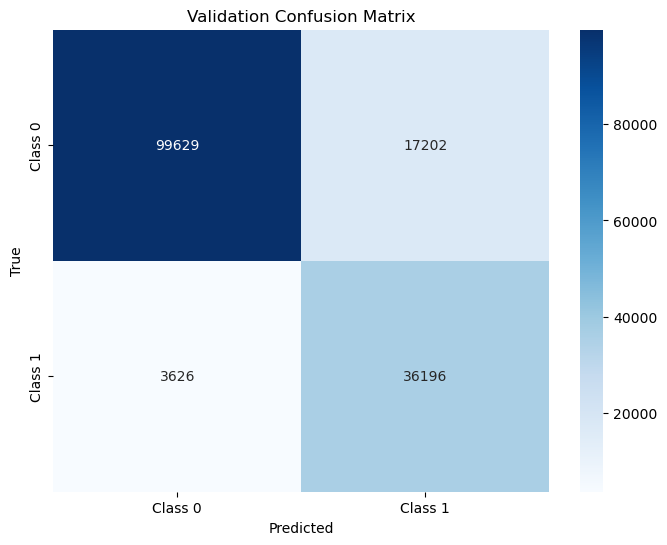

Test Confusion Matrix - XGB:


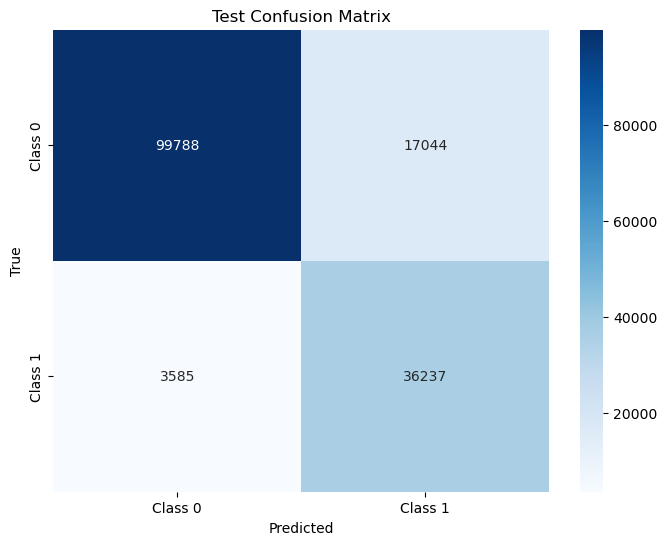

In [28]:
# Plot confusion matrices
print("Validation Confusion Matrix - XGB:")
plot_confusion_matrix(xgb_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - XGB:")
plot_confusion_matrix(xgb_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The XGBoost model demonstrates strong performance with a validation accuracy of approximately 86.80%, indicating its effectiveness in classifying fraudulent and non-fraudulent cases. The validation confusion matrix shows the model correctly identified 99,751 true negatives and 36,223 true positives, but also made 17,080 false positives and 3,599 false negatives. This highlights the model's overall capability in detecting fraudulent activities, though there are areas for improvement.

Precision for fraudulent cases (Class 1) stands at 0.68, meaning 68% of the predicted fraud cases were accurate. The recall rate for detecting actual fraudulent cases is 0.91, showing that 91% of true fraud cases were identified. The F1-score of 0.78 reflects a balanced trade-off between precision and recall. These metrics are supported by the macro and weighted average scores, which account for class imbalances and provide a comprehensive view of performance.

Evaluating the model on the test set yielded a slightly improved accuracy of 86.88%, with results consistent with the validation metrics. This confirms the model’s reliability across different data subsets. While the XGBoost model performs robustly in detecting healthcare fraud, there is potential for further enhancement, particularly in reducing false positives and negatives. Continued refinement and additional testing could further improve its effectiveness in real-world fraud detection scenarios.

<Figure size 1000x800 with 0 Axes>

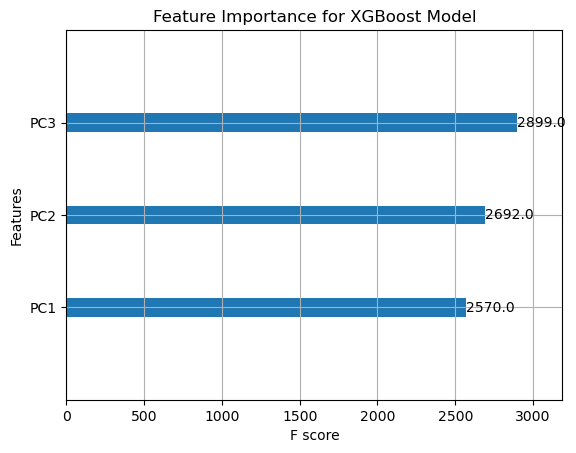

In [29]:
# plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb_model, importance_type='weight')
plt.title('Feature Importance for XGBoost Model')
plt.show()

The bar chart below shows the importance of each feature in the XGBoost model. Features with higher importance, in this case PC3, are more influential in making predictions.

### Saving the Tuned Model:
Finally, we save the tuned XGBoost model for future use.

- **Joblib**: Suitable to retrieve the models within the notebook. 
- **Pickle**: Used for Flask model implementation - if model retrival is needed.

In [30]:
# save the model in both `pkl` and `joblib` formats
#(Joblib will be used to retrieve the models within the notebook, and `pkl` will be used for Flask model implementation.)

# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned XGBoost model
xgb_best_model_path_job = 'models/xgb_best_model.joblib'
xgb_best_model_path_pickle = 'models/xgb_best_model.pkl'

joblib.dump(best_xgb_model, xgb_best_model_path_job)
with open(xgb_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_xgb_model, file)

print(f'Tuned XGBoost model saved at: {xgb_best_model_path_job}')
print(f'Tuned XGBoost model saved at: {xgb_best_model_path_pickle}')

Tuned XGBoost model saved at: models/xgb_best_model.joblib
Tuned XGBoost model saved at: models/xgb_best_model.pkl


##  Neural Network

Neural Networks were chosen for their ability to model complex patterns and relationships within high-dimensional data. A Multi-layer Perceptron (MLP) classifier was used due to its versatility and effectiveness in handling non-linear data. A parameter grid was defined to optimize the model, including variations in hidden layer sizes, activation functions, and solvers.

### Hyperparameter Tuning with Randomized Search:

To optimize the performance of the NN model, a parameter grid was defined, encompassing various configurations of hidden layer sizes, activation functions, solvers, and learning rates. The parameter grid included hidden layer sizes such as (50,), (100,), (100, 50), (150,), and (100, 100), activation functions like 'relu' and 'tanh', and solvers 'adam' and 'sgd'. Additionally, regularization term values (alpha) were varied from 0.0001 to 0.001, learning rate strategies included 'constant' and 'adaptive', and initial learning rates were set to 0.001 and 0.01.

The RandomizedSearchCV was employed for hyperparameter tuning, running 50 iterations with a 3-fold cross-validation approach to identify the optimal hyperparameters for the NN model.

- **hidden_layer_sizes**: Number and size of hidden layers, influencing model complexity and capacity.
- **activation**: Controls how the output of each neuron is computed.
- **solver**: Optimization algorithm for adjusting weights.
- **alpha**: Regularization parameter to avoid overfitting.
- **learning_rate**: Controls the contribution of each update to the model parameters.
- **learning_rate_init**: Initial learning rate setting.


In [32]:
# define the parameter grid
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150,), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.001),
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01]
}


# initialize Neural Network model
nn_model = MLPClassifier(max_iter=1000, random_state=42)

# setup RandomSearchCV
random_search_nn = RandomizedSearchCV(
    estimator=nn_model, 
    param_distributions=param_grid_nn, 
    n_iter=50,  
    scoring='accuracy', 
    cv=3, 
    n_jobs=-1, 
    verbose=2,
    random_state=42
)

In [33]:
# fit the model
random_search_nn.fit(x_train_scaled_pca, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8749080237694725, learning_rate=0.20014286128198325, max_depth=5, n_estimators=171, subsample=0.9197316968394074; total time=   9.6s
[CV] END colsample_bytree=0.9049512863264476, learning_rate=0.09638900372842316, max_depth=3, n_estimators=158, subsample=0.8799721943430512; total time=   5.8s
[CV] END colsample_bytree=0.9236772018666175, learning_rate=0.08649239825343255, max_depth=3, n_estimators=230, subsample=0.9719880813472641; total time=   8.7s
[CV] END colsample_bytree=0.912657643569108, learning_rate=0.08708330050798323, max_depth=4, n_estimators=152, subsample=0.8461787651244298; total time=   6.5s
[CV] END colsample_bytree=0.9818640804157565, learning_rate=0.061755996320003385, max_depth=4, n_estimators=233, subsample=0.8415883325736379; total time=  10.7s
[CV] END colsample_bytree=0.9173502331327696, learning_rate=0.2030510614528276, max_depth=3, n_estimators=140, subsample=0.8592547011

RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(max_iter=1000, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x167fe7fa0>,
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (100, 50),
                                                               (150,),
                                                               (100, 100)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'learning_rate_init': [0.001, 0.01],
                                        'solver': ['adam', 'sgd']},
                   random_state=42, scoring='accuracy', verbose=2)

In [34]:
# best parameters, estimator, score
best_nn_model = random_search_nn.best_estimator_
best_nn_params = random_search_nn.best_params_
best_nn_score = random_search_nn.best_score_

print(f'Best Parameters for Neural Network: {best_nn_params}')
print(f'Best Cross-Validation Score: {best_nn_score}')

Best Parameters for Neural Network: {'activation': 'relu', 'alpha': 0.0003421599382774259, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'sgd'}
Best Cross-Validation Score: 0.9076476813563922


The best hyperparameters obtained were: hidden layer sizes of (100, 100), 'relu' activation function, 'sgd' solver, 'adaptive' learning rate, an initial learning rate of 0.01, and a regularization term (alpha) of approximately 0.0004.

### Model Evaluation:
The fine-tuned model is evaluated on the validation, test, and train datasets.

In [35]:
# evaluate model - val, test, train
nn_metrics = evaluate_model(best_nn_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
nn_metrics_df = metrics_to_dataframe(nn_metrics)

In [36]:
print("Neural Network Evaluation Metrics:")
nn_metrics_df

Neural Network Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.907641,0.889751,0.889252
1,Classification Report,NaN,"{'0': {'precision': 0.9685796850438171, 'recal...","{'0': {'precision': 0.9682828092637922, 'recal..."
2,Confusion Matrix,NaN,"[[102899, 13933], [3338, 36484]]","[[102851, 13980], [3369, 36453]]"
3,F1-Score,NaN,0.808608,0.807778
4,Kappa,0.815283,0.732675,0.731499
5,MCC,0.816608,0.74273,0.741567
6,PR-AUC,0.967249,0.910332,0.910533
7,Precision,NaN,0.723645,0.722801
8,ROC-AUC,0.969954,0.96634,0.966267
9,Recall,NaN,0.916177,0.915399


Validation Confusion Matrix - Neural Network:


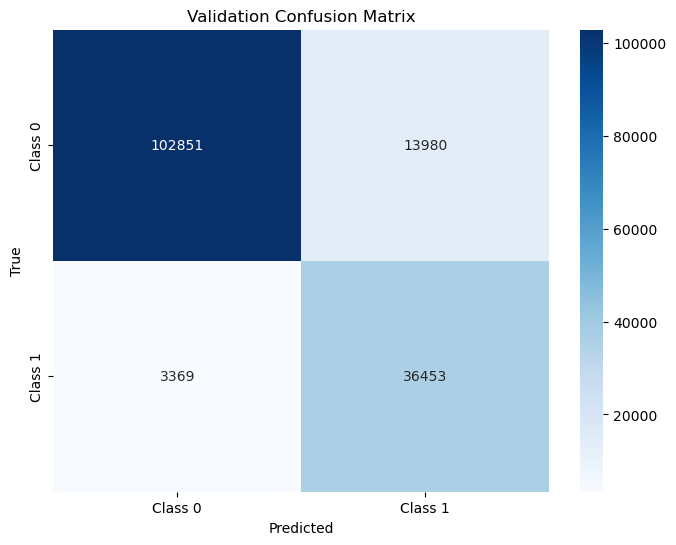

Test Confusion Matrix - Neural Network:


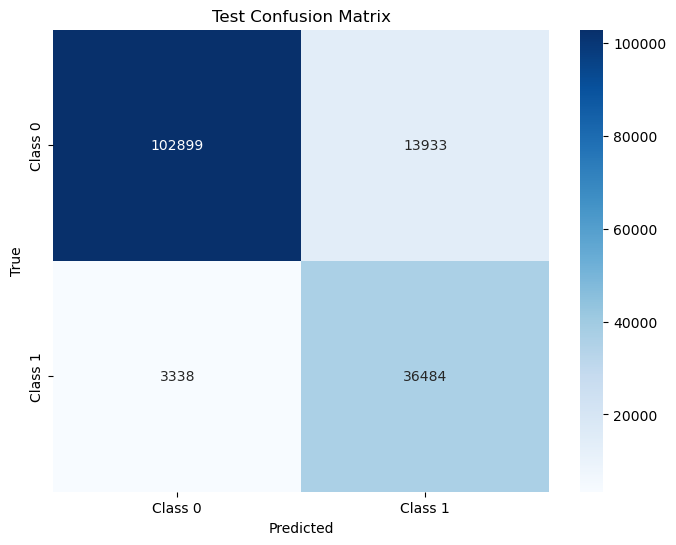

In [37]:
# Plot confusion matrices
print("Validation Confusion Matrix - Neural Network:")
plot_confusion_matrix(nn_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - Neural Network:")
plot_confusion_matrix(nn_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The performance of the optimized Neural Network model was evaluated using accuracy, precision, recall, F1-score, Kappa, MCC, PR-AUC, and ROC-AUC metrics. The NN model achieved an accuracy of approximately 86.04% on the validation set and 86.14% on the test set. Precision for detecting fraudulent cases was 0.67, while recall was 0.89, indicating a good balance between identifying fraud cases and minimizing false positives. The F1-score of 0.76 reflects this balance, and the ROC-AUC score of 0.95 demonstrates strong overall performance in distinguishing between classes. The confusion matrices for both validation and test sets were plotted to visualize the model’s performance.

### Saving the Tuned Model:
Finally, the tuned NN model is saved for future use.

In [38]:
# save the model in both `pkl` and `joblib` formats
#(Joblib will be used to retrieve the models within the notebook, and `pkl` will be used for Flask model implementation.)

# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned NN model
nn_best_model_path_job = 'models/nn_best_model.joblib'
nn_best_model_path_pickle = 'models/nn_best_model.pkl'

joblib.dump(best_nn_model, nn_best_model_path_job)
with open(nn_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_nn_model, file)

print(f'Tuned Neural Network model saved at: {nn_best_model_path_job}')
print(f'Tuned Neural Network model saved at: {nn_best_model_path_pickle}')

Tuned Neural Network model saved at: models/nn_best_model.joblib
Tuned Neural Network model saved at: models/nn_best_model.pkl


## Quadratic Discriminant Analysis (QDA)

Quadratic Discriminant Analysis (QDA) was chosen for its ability to model the quadratic decision boundaries between classes, which can be beneficial when the classes are not linearly separable. QDA is particularly effective when the assumption of normally distributed features within each class holds true, providing a good balance between simplicity and performance for certain types of data.

To find the best parameter values, GridSearchCV is used. For QDA, key settings were adjusted including reg_param, store_covariance, and tol. The reg_param controls regularization strength, ranging from 0.0 to 1.0. The store_covariance setting determines if covariance estimates are saved, affecting model flexibility. The tol parameter sets tolerance for handling singular matrices, ranging from 1 x 10^{-4} to 1.0. These adjustments help balance model performance.

### Hyperparameter Tuning with Grid Search:

- **reg_param**: Strength of regularization to control model complexity.
- **store_covariance**: Whether to store the covariance matrix.
- **tol**: Tolerance for convergence in the model fitting process.

In [39]:
# define the parameter grid
param_grid_qda = {
    'reg_param': [0.0, 0.01, 0.1, 0.5, 1.0],
    'store_covariance': [True, False],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

# initialize QDA model
qda_model = QuadraticDiscriminantAnalysis()

# setup GridSearchCV
grid_search_qda = GridSearchCV(estimator=qda_model, 
                               param_grid=param_grid_qda, 
                               scoring='accuracy', 
                               cv=3, n_jobs=2, verbose=2)

In [40]:
# fit the model
grid_search_qda.fit(x_train_scaled_pca, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=QuadraticDiscriminantAnalysis(), n_jobs=2,
             param_grid={'reg_param': [0.0, 0.01, 0.1, 0.5, 1.0],
                         'store_covariance': [True, False],
                         'tol': [0.0001, 0.001, 0.01, 0.1, 1.0]},
             scoring='accuracy', verbose=2)

In [41]:
# best parameters, estimator, score
best_qda_model = grid_search_qda.best_estimator_
best_qda_params = grid_search_qda.best_params_
best_qda_score = grid_search_qda.best_score_

print(f'Best Parameters for QDA: {best_qda_params}')
print(f'Best Cross-Validation Score: {best_qda_score}')

Best Parameters for QDA: {'reg_param': 1.0, 'store_covariance': True, 'tol': 0.0001}
Best Cross-Validation Score: 0.6279642193572763


In this case, GridSearchCV explored 50 different parameter combinations across 3 folds, totaling 150 model fits. The grid search identified the optimal parameters as a reg_param of 1.0, store_covariance set to True, and a tol of 0.0001. The best cross-validation score achieved was approximately 62.80%. 

### Model Evaluation:
The fine-tuned model is evaluated on the validation, test, and train datasets. 

In [42]:
# evaluate model - val, test, train
qda_metrics = evaluate_model(best_qda_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
qda_metrics_df = metrics_to_dataframe(qda_metrics)

In [43]:
print("QDA Evaluation Metrics:")
qda_metrics_df

QDA Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.627964,0.802163,0.801357
1,Classification Report,NaN,"{'0': {'precision': 0.7992609120066936, 'recal...","{'0': {'precision': 0.7986744628508109, 'recal..."
2,Confusion Matrix,NaN,"[[114630, 2202], [28790, 11032]]","[[114601, 2230], [28888, 10934]]"
3,F1-Score,NaN,0.415862,0.412713
4,Kappa,0.255928,0.331027,0.327808
5,MCC,0.361753,0.404225,0.400961
6,PR-AUC,0.870163,0.713707,0.710383
7,Precision,NaN,0.83361,0.830599
8,ROC-AUC,0.89088,0.894094,0.893265
9,Recall,NaN,0.277033,0.274572


Validation Confusion Matrix - QDA:


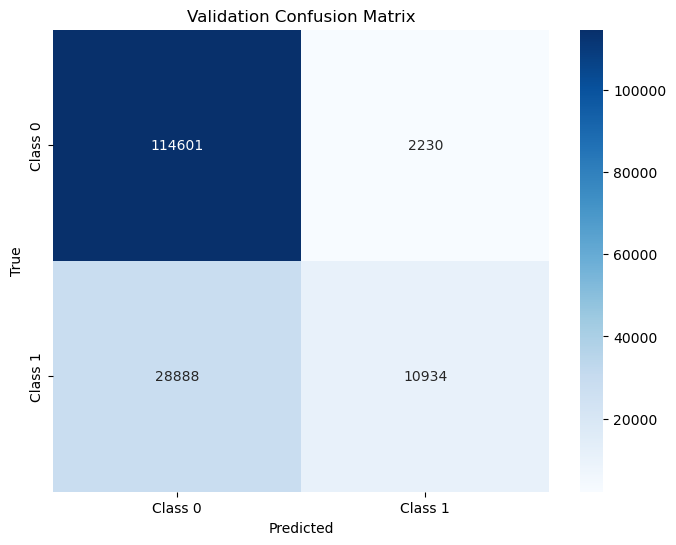

Test Confusion Matrix - QDA:


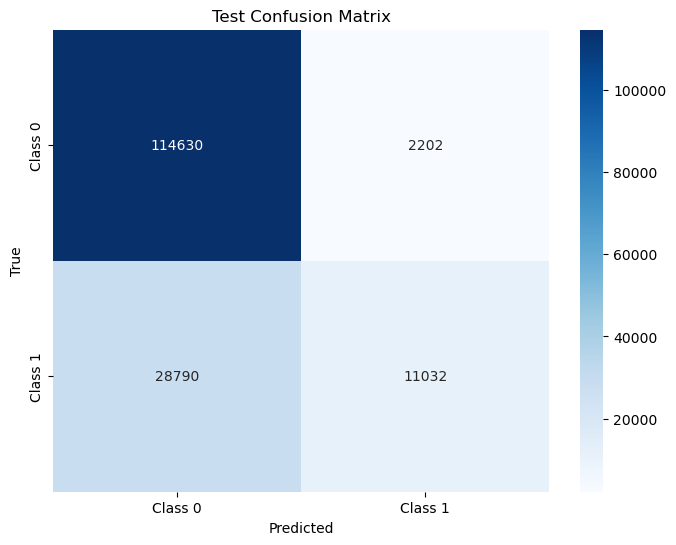

In [44]:
# plot confusion matrices
print("Validation Confusion Matrix - QDA:")
plot_confusion_matrix(qda_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - QDA:")
plot_confusion_matrix(qda_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The QDA model achieved a cross-validation accuracy of 62.80%, with a test accuracy of 80.22% and a validation accuracy of 80.14%. Precision for the positive class is high at 0.83, while recall is lower at 0.28, indicating a challenge in identifying all positive cases. The F1-score is around 0.42, reflecting a trade-off between precision and recall. The ROC-AUC of 0.89 suggests good discriminative power, and the PR-AUC of 0.71 highlights performance in precision-recall scenarios. The confusion matrices show that the model performs well in classifying the majority class but struggles with the minority class.

### Saving the Tuned Model:
Finally, the tuned QDA model is saved for future use.

In [45]:
# save the model in both `pkl` and `joblib` formats
#(Joblib will be used to retrieve the models within the notebook, and `pkl` will be used for Flask model implementation.)

# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned QDA model
qda_best_model_path_job = 'models/qda_best_model.joblib'
qda_best_model_path_pickle = 'models/qda_best_model.pkl'

joblib.dump(best_qda_model, qda_best_model_path_job)
with open(qda_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_qda_model, file)

print(f'Tuned Quadratic Discriminant Analysis model saved at: {qda_best_model_path_job}')
print(f'Tuned Quadratic Discriminant Analysis model saved at: {qda_best_model_path_pickle}')

Tuned Quadratic Discriminant Analysis model saved at: models/qda_best_model.joblib
Tuned Quadratic Discriminant Analysis model saved at: models/qda_best_model.pkl


## Bagging Classifier
The Bagging Classifier was selected for its ability to improve model stability and accuracy by reducing variance and overfitting. By aggregating predictions from multiple models trained on different subsets of the data, Bagging enhances generalization. Specifically, using Bagging with Decision Trees as base estimators leverages their flexibility while mitigating their overfitting risk. 

### Initial Model Performance:

First, the Bagging Classifier is initialized with a DecisionTreeClassifier as the base estimator and setting the number of estimators to 10. Cross-validation is used to evaluate the model’s performance.

In [46]:
# Initialize model
bag_mod = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)

# Perform cross-validation
scores = cross_val_score(bag_mod, x_train_scaled_pca, y_train, cv=5)

# Print results
print(f"Bagging Classifier Accuracy for each fold: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

params = bag_mod.get_params()
print("Parameters used by the Bagging Classifier:")
print(params)

Bagging Classifier Accuracy for each fold: [0.9008781  0.90497742 0.91157077 0.90938813 0.91038774]
Mean accuracy: 0.91
Parameters used by the Bagging Classifier:
{'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Originally, there were more features and options that were on the grid, but it would've taken 40 hours to run (Fitting 5 folds for each of 972 candidates, totalling 4860 fits). So a reduced parameter grid and the use of RandomizedSearchCV were employed to run the hypertuning.

### Hyperparameter Tuning with Randomized Search:

- **n_estimators**: Number of trees in the ensemble (fewer values: 10, 20).
- **max_samples**: Fraction of samples used to train each tree (0.5 or 1.0).
- **max_features**: Fraction of features used to train each tree (0.5 or 1.0).
- **bootstrap**: Whether to use bootstrap samples for training (True only).
- **bootstrap_features**: Whether to use bootstrap samples of features (False only).
- **estimator__max_depth**: Maximum depth of each tree (None or 10).
- **estimator__min_samples_split**: Minimum number of samples required to split an internal node (2 or 5).

In [47]:
param_grid = {
    'n_estimators': [10, 20],                    # Fewer values
    'max_samples': [0.5, 1.0],                   # Reduced options
    'max_features': [0.5, 1.0],                  # Reduced options
    'bootstrap': [True],                         # Reduced options
    'bootstrap_features': [False],               # Reduced options
    'estimator__max_depth': [None, 10],          # Fewer values
    'estimator__min_samples_split': [2, 5],      # Fewer values
    # Remove 'n_jobs' from parameter grid
}

bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# Using RandomizedSearchCV with fewer iterations to cut down on tuning time
random_search = RandomizedSearchCV(estimator=bagging_clf, param_distributions=param_grid, 
                                     n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)

In [48]:
# Perform the search
random_search.fit(x_train_scaled_pca, y_train)

[CV] END ...reg_param=0.0, store_covariance=True, tol=0.0001; total time=   0.2s
[CV] END ...reg_param=0.0, store_covariance=True, tol=0.0001; total time=   0.2s
[CV] END ....reg_param=0.0, store_covariance=True, tol=0.001; total time=   0.2s
[CV] END .....reg_param=0.0, store_covariance=True, tol=0.01; total time=   0.2s
[CV] END ......reg_param=0.0, store_covariance=True, tol=0.1; total time=   0.2s
[CV] END ......reg_param=0.0, store_covariance=True, tol=0.1; total time=   0.1s
[CV] END ......reg_param=0.0, store_covariance=True, tol=1.0; total time=   0.1s
[CV] END ......reg_param=0.0, store_covariance=True, tol=1.0; total time=   0.2s
[CV] END ..reg_param=0.0, store_covariance=False, tol=0.0001; total time=   0.2s
[CV] END ...reg_param=0.0, store_covariance=False, tol=0.001; total time=   0.2s
[CV] END ...reg_param=0.0, store_covariance=False, tol=0.001; total time=   0.1s
[CV] END ....reg_param=0.0, store_covariance=False, tol=0.01; total time=   0.1s
[CV] END .....reg_param=0.0,

RandomizedSearchCV(cv=5,
                   estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                               random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'bootstrap_features': [False],
                                        'estimator__max_depth': [None, 10],
                                        'estimator__min_samples_split': [2, 5],
                                        'max_features': [0.5, 1.0],
                                        'max_samples': [0.5, 1.0],
                                        'n_estimators': [10, 20]},
                   random_state=42, verbose=2)

In [49]:
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best Cross-Validation Score:{random_search.best_score_:.4f}")

Best parameters found: {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 1.0, 'estimator__min_samples_split': 5, 'estimator__max_depth': None, 'bootstrap_features': False, 'bootstrap': True}
Best Cross-Validation Score:0.9125


The model was fine-tuned with the following optimal parameters: n_estimators set to 20, max_samples and max_features both at 1.0, estimator__min_samples_split at 5, and estimator__max_depth set to None, with bootstrap_features as False and bootstrap as True. These settings yielded a best cross-validation score of 0.9125. 

In [50]:
# Get best estimator for the baggingclassifier
best_bag_model = random_search.best_estimator_

### Model Evaluation:

The fine-tuned model is evaluated on the validation, test, and train datasets. 

In [51]:
bag_metrics = evaluate_model(best_bag_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
bag_metrics_df = metrics_to_dataframe(bag_metrics)

[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=10, estimator__min_samples_split=5, max_features=1.0, max_samples=0.5, n_estimators=20; total time=  42.8s
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=None, estimator__min_samples_split=5, max_features=1.0, max_samples=1.0, n_estimators=20; total time= 1.8min
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=10, estimator__min_samples_split=5, max_features=1.0, max_samples=1.0, n_estimators=10; total time=  34.7s
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=10, estimator__min_samples_split=5, max_features=0.5, max_samples=0.5, n_estimators=20; total time=  22.6s
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=None, estimator__min_samples_split=5, max_features=1.0, max_samples=0.5, n_estimators=10; total time=  31.9s
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=10, estimator__min_samples_sp

In [52]:
print("Bagging Classification Evaluation Metrics:")
bag_metrics_df

Bagging Classification Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.910117,0.902524,0.902255
1,Classification Report,NaN,"{'0': {'precision': 0.9691952323754967, 'recal...","{'0': {'precision': 0.9690702595806419, 'recal..."
2,Confusion Matrix,NaN,"[[104896, 11936], [3334, 36488]]","[[104866, 11965], [3347, 36475]]"
3,F1-Score,NaN,0.826961,0.826517
4,Kappa,0.820235,0.760007,0.759376
5,MCC,0.820666,0.767049,0.766437
6,PR-AUC,0.961586,0.902817,0.903039
7,Precision,NaN,0.753511,0.752993
8,ROC-AUC,0.968425,0.967614,0.967611
9,Recall,NaN,0.916277,0.915951


Validation Confusion Matrix - Bagging Classifier:


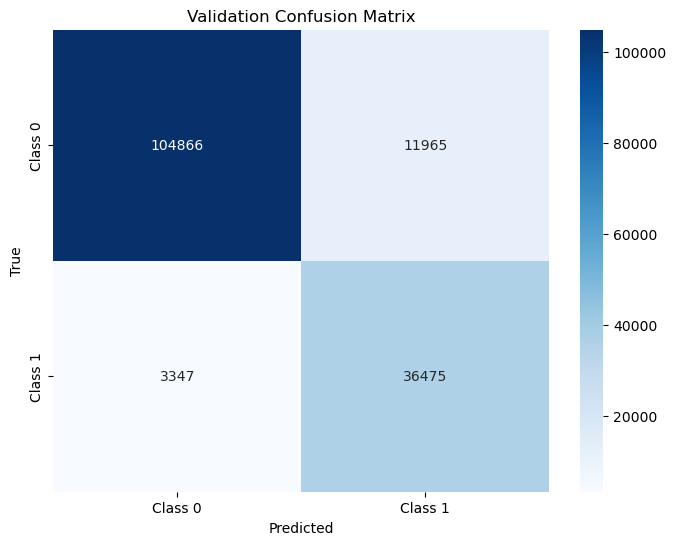

Test Confusion Matrix - Bagging Classifier:


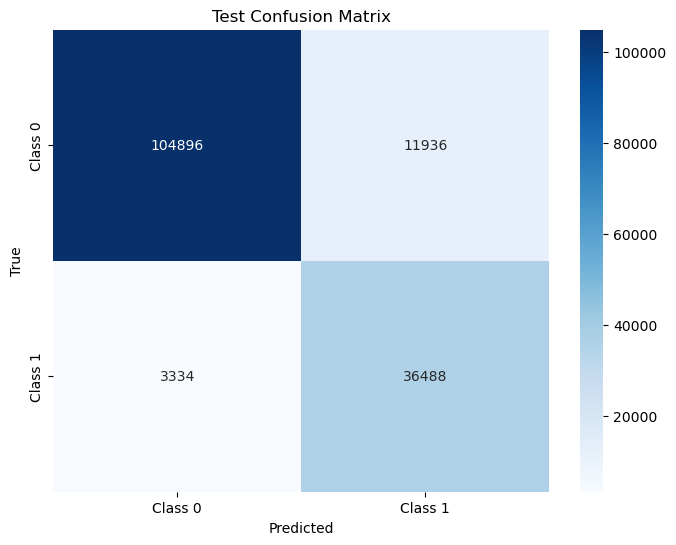

In [53]:
# plot confusion matrices
print("Validation Confusion Matrix - Bagging Classifier:")
plot_confusion_matrix(bag_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - Bagging Classifier:")
plot_confusion_matrix(bag_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The evaluation metrics for this model are promising, with an accuracy of 0.9101 on cross-validation, 0.9025 on the test set, and 0.9023 on the validation set. The F1-Score is 0.827 for both test and validation sets. Kappa scores are 0.8202 (CV), 0.7600 (Test), and 0.7594 (Validation), while MCC scores are 0.8207 (CV), 0.7670 (Test), and 0.7664 (Validation). Additionally, the PR-AUC scores are 0.9616 (CV), 0.9028 (Test), and 0.9030 (Validation), with precision values of 0.7535 (Test) and 0.7530 (Validation). ROC-AUC scores are high at 0.9684 (CV), 0.9676 (Test), and 0.9676 (Validation). The recall rates are 0.9163 (Test) and 0.9160 (Validation). The model's confusion matrices further confirm its effective classification performance. 

### Saving the Tuned Model:
Finally, the tuned BaggingClassifier model is saved for future use.

In [54]:
# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned Bagged model
bag_best_model_path_job = 'models/bag_best_model.joblib'
bag_best_model_path_pickle = 'models/bag_best_model.pkl'
joblib.dump(best_bag_model, bag_best_model_path_job)
with open(bag_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_bag_model, file)

print(f'Tuned Bagging model saved at: {bag_best_model_path_job}')
print(f'Tuned Bagging model saved at: {bag_best_model_path_pickle}')

Tuned Bagging model saved at: models/bag_best_model.joblib
Tuned Bagging model saved at: models/bag_best_model.pkl


## Stochastic Gradient Descent Classifier (SGD)

The SGD Classifier with a 'hinge' loss function is equivalent to a linear Support Vector Machine (SVM). It is selected due to its efficiency and scalability, especially when dealing with large datasets. The hinge loss function is used to optimize the margin between classes, similar to the SVM. Key parameters include alpha for regularization to prevent overfitting, max_iter for the maximum number of iterations for convergence, tol for the stopping criteria, and random_state to ensure reproducibility.

### Initial Model Performance:

In [55]:
# initialize and train SGDClassifier with a linear kernel
# loss function is 'hinge' which is used for linear SVM
sgd_model = SGDClassifier(loss='hinge',  # Linear SVM
                          alpha=0.0001,  # Regularization parameter
                          max_iter=1000,  # Number of iterations
                          tol=1e-3,       # Tolerance for stopping criteria
                          random_state=42)

sgd_model.fit(x_train_scaled_pca, y_train)

# Make predictions
y_pred = sgd_model.predict(x_test_scaled_pca)

# Print performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8327588187981156
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89    116832
           1       0.75      0.52      0.61     39822

    accuracy                           0.83    156654
   macro avg       0.80      0.73      0.75    156654
weighted avg       0.82      0.83      0.82    156654



The initial accuracy of the SGD Classifier was found to be 83.28%. The classification report provides a detailed breakdown of precision, recall, and F1-score for each class. The performance on the test data shows that class 0 (non-fraud) has a higher precision and recall compared to class 1 (fraud), which is common in imbalanced datasets.

To improve the model's performance, hyperparameter tuning using Grid Search is performed. The parameter grid includes different values for alpha (regularization parameter), max_iter (number of iterations), tol (tolerance for stopping criteria), and penalty (type of regularization).

### Hyperparameter Tuning with Grid Search:

- **alpha**: Regularization parameter that controls the strength of the penalty applied to the model to avoid overfitting.
- **max_iter**: Number of iterations for the optimization algorithm to run.
- **tol**: Tolerance for the stopping criteria of the optimization process.
- **penalty**: Type of regularization to apply (L2, L1, or Elastic Net).

In [56]:
# Define the parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],       # Regularization parameter
    'max_iter': [5000, 10000, 20000],        # Number of iterations
    'tol': [1e-3, 1e-4, 1e-5],              # Tolerance for stopping criteria
    'penalty': ['l2', 'l1', 'elasticnet']  # Type of regularization
}

# Initialize the SGDClassifier
sgd = SGDClassifier(loss='hinge', random_state=42)

# Configure Grid Search
grid_search = GridSearchCV(estimator=sgd,
                           param_grid=param_grid,
                           scoring='accuracy',   # Use accuracy to evaluate performance
                           cv=5,                 # Number of cross-validation folds
                           verbose=2,            # Print detailed logs
                           n_jobs=-1)            # Use all available CPUs


In [57]:
# Fit Grid Search
grid_search.fit(x_train_scaled_pca, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fi

[CV] END .alpha=0.0001, max_iter=5000, penalty=l2, tol=0.001; total time=   4.8s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l2, tol=1e-05; total time=  11.1s
[CV] END alpha=0.0001, max_iter=5000, penalty=l1, tol=0.0001; total time=  11.5s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l1, tol=1e-05; total time=  10.1s
[CV] END alpha=0.0001, max_iter=5000, penalty=elasticnet, tol=1e-05; total time=  12.0s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=0.0001; total time=  11.1s
[CV] END alpha=0.0001, max_iter=10000, penalty=l1, tol=0.001; total time=   4.4s
[CV] END alpha=0.0001, max_iter=10000, penalty=l1, tol=0.0001; total time=  11.6s
[CV] END alpha=0.0001, max_iter=10000, penalty=elasticnet, tol=0.001; total time=   3.8s
[CV] END alpha=0.0001, max_iter=10000, penalty=elasticnet, tol=0.001; total time=   4.5s
[CV] END alpha=0.0001, max_iter=10000, penalty=elasticnet, tol=1e-05; total time=  14.6s
[CV] END alpha=0.0001, max_iter=20000, penalty=l2, tol=0.0001; total time=  

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'max_iter': [5000, 10000, 20000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring='accuracy', verbose=2)

In [58]:
best_sgd_params = grid_search.best_params_
best_sgd_model = grid_search.best_estimator_
best_sgd_score = grid_search.best_score_

print(f"Best Parameters: {best_sgd_params}")
print(f"Best Cross-Validation Score: {best_sgd_score:.4f}")

Best Parameters: {'alpha': 0.01, 'max_iter': 20000, 'penalty': 'l1', 'tol': 1e-05}
Best Cross-Validation Score: 0.7422


The best parameters identified by the grid search were alpha=0.01, max_iter=20000, penalty='l1', and tol=1e-05, with a cross-validation score of 74.22%

### Model Evaluation:

Evaluate fine-tuned model on the validation, test, and train datasets.

In [59]:
# evaluate model - val, test, train
sgd_metrics = evaluate_model_2(best_sgd_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
sgd_metrics_df = metrics_to_dataframe(sgd_metrics)

In [60]:
print("Stochastic Gradient Descent Classifier Evaluation Metrics:")
sgd_metrics_df

Stochastic Gradient Descent Classifier Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.727473,0.830135,0.8291
1,Classification Report,NaN,"{'0': {'precision': 0.8493835001084297, 'recal...","{'0': {'precision': 0.8492960477834232, 'recal..."
2,Confusion Matrix,NaN,"[[109669, 7163], [19447, 20375]]","[[109487, 7344], [19428, 20394]]"
3,F1-Score,NaN,0.604958,0.60373
4,Kappa,0.454947,0.501307,0.499193
5,MCC,0.501405,0.515144,0.512457
6,Precision,NaN,0.739887,0.735237
7,Recall,NaN,0.511652,0.512129


Validation Confusion Matrix - SGD:


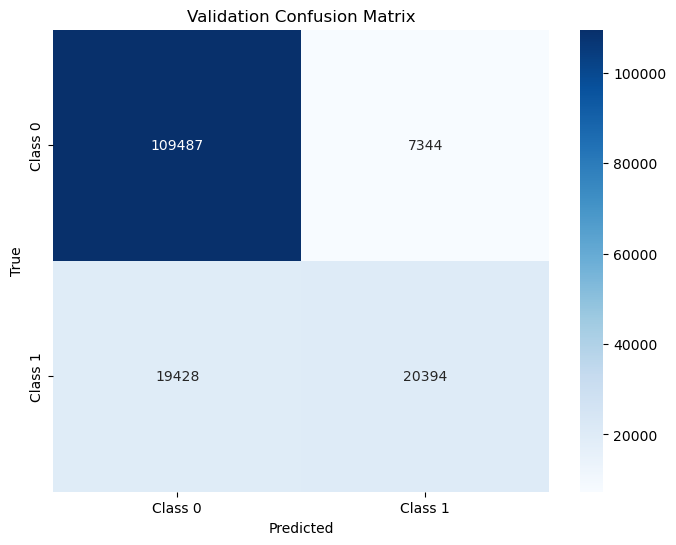

Test Confusion Matrix - SGD:


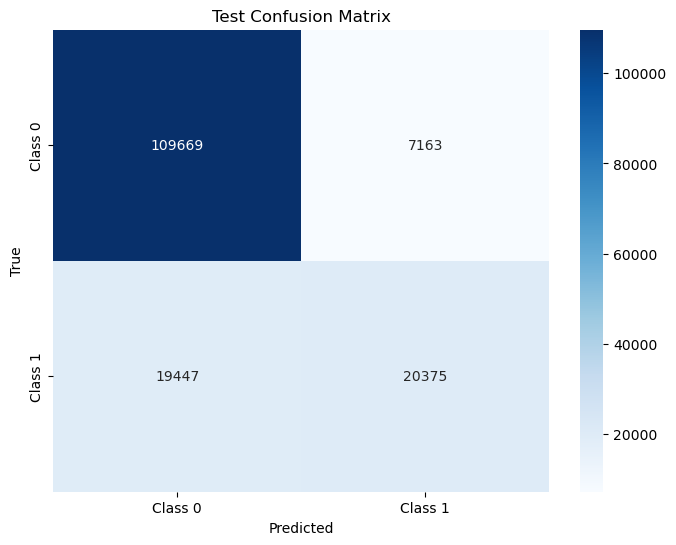

In [61]:
# plot confusion matrices
print("Validation Confusion Matrix - SGD:")
plot_confusion_matrix(sgd_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - SGD:")
plot_confusion_matrix(sgd_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

Training the model on scaled principal component analysis (PCA) transformed data resulted in an accuracy of 83.28%. The classification report indicated higher precision and recall for non-fraud (class 0) compared to fraud (class 1), a typical result for imbalanced datasets. To enhance the model, a grid search was performed over various parameters: alpha, max_iter, tol, and penalty. The best parameters, identified as alpha=0.01, max_iter=20000, penalty='l1', and tol=1e-05, yielded a cross-validation score of 74.22%. Evaluating the tuned model on validation, test, and training datasets revealed comprehensive metrics: test accuracy at 83.01% and validation accuracy at 82.91%, detailed precision, recall, and F1-scores for both classes, and confusion matrices illustrating true positives, true negatives, false positives, and false negatives. The F1-score for fraud detection was 0.60, with a Kappa statistic around 0.50 indicating moderate agreement, and an MCC of approximately 0.51 reflecting balanced binary classification performance

### Saving the Tuned Model:

Finally, the tuned SGD model is saved for future use.

In [62]:
# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned Bagged model
sgd_best_model_path_job = 'models/sgd_best_model.joblib'
sgd_best_model_path_pickle = 'models/sgd_best_model.pkl'
joblib.dump(best_sgd_model, sgd_best_model_path_job)
with open(sgd_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_sgd_model, file)

print(f'Tuned Stochastic Gradient Descent Classifier model saved at: {sgd_best_model_path_job}')
print(f'Tuned Stochastic Gradient Descent Classifier model saved at: {sgd_best_model_path_pickle}')

Tuned Stochastic Gradient Descent Classifier model saved at: models/sgd_best_model.joblib
Tuned Stochastic Gradient Descent Classifier model saved at: models/sgd_best_model.pkl


## Adaboost

AdaBoost (Adaptive Boosting) was selected for its ability to enhance the performance of weak classifiers by focusing on the instances that are hardest to classify. This iterative technique adjusts the weights of incorrectly classified instances, allowing the model to correct its mistakes and improve overall accuracy.

Adaboost is examined before and after applyimg parameters through RandomSearchCV. 

In this implementation, a DecisionTreeClassifier with a maximum depth of 1 is used as the base model for AdaBoost. This shallow tree acts as the weak learner in the ensemble. The AdaBoostClassifier is initialized with this base model and configured to use the SAMME algorithm, which is suitable for multi-class classification problems.


### Initial Model Performance:

In [63]:
# initialize the base model
base_model = DecisionTreeClassifier(max_depth=1)

# initialize the AdaBoost model with the base model
adaboost_model = AdaBoostClassifier(estimator=base_model, algorithm='SAMME', random_state=42)

# train the model on the PCA-transformed and scaled training data
adaboost_model.fit(x_train_scaled_pca, y_train)

# predict on the PCA-transformed and scaled training data
y_train_pred = adaboost_model.predict(x_train_scaled_pca)

# predict on the PCA-transformed and scaled validation data
y_val_pred = adaboost_model.predict(x_val_scaled_pca)

# predict on the PCA-transformed and scaled test data
y_test_pred = adaboost_model.predict(x_test_scaled_pca)

# evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.8450554005696878
Validation Accuracy: 0.8055192048668075
Test Accuracy: 0.8061268783433554

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.96      0.77      0.86    116831
           1       0.57      0.91      0.70     39822

    accuracy                           0.81    156653
   macro avg       0.77      0.84      0.78    156653
weighted avg       0.86      0.81      0.82    156653


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.77      0.86    116832
           1       0.57      0.91      0.70     39822

    accuracy                           0.81    156654
   macro avg       0.77      0.84      0.78    156654
weighted avg       0.86      0.81      0.82    156654



The AdaBoost model performs well, achieving high precision of 0.96 for the negative class and high recall of 0.91 for the positive class. However, precision for the positive class is lower at 0.57, indicating fewer reliable positive predictions. The overall accuracy is around 81%, with a good balance in F1-scores for both classes, showing effective performance in identifying both classes despite some imbalance.

To optimize AdaBoost's performance, RandomSearchCV is applied to identify the best combination of combination of hyperparameters. The parameter grid includes n_estimators, which defines the number of boosting stages, and learning_rate, which controls the contribution of each weak learner to the final model. Additionally, the max_depth of the base DecisionTreeClassifier is adjusted to explore different complexities of the base model.


### Hyperparameter Tuning with Randomized Search:

- **n_estimators**: Number of boosting stages to be run.
- **learning_rate**: Learning rate that shrinks the contribution of each tree.
- **estimator__max_depth**: Maximum depth of the base estimator (tree).

In [64]:
# define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),  # Number of boosting stages to be run
    'learning_rate': uniform(0.01, 0.3),  # Learning rate shrinks the contribution of each tree
    'estimator__max_depth': randint(1, 4)  # Hyperparameter for base estimator
}

# initialize the AdaBoost classifier with a base estimator
base_estimator = DecisionTreeClassifier()
adaboost_model = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=42)

# setup RandomizedSearchCV
ada_random_search = RandomizedSearchCV(
    estimator=adaboost_model,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    n_iter=27,
    random_state=42
)

In [65]:
ada_random_search.fit(x_train_scaled_pca, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END alpha=0.0001, max_iter=5000, penalty=l2, tol=0.0001; total time=  10.9s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l1, tol=0.001; total time=   4.4s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l1, tol=0.001; total time=   4.5s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l1, tol=1e-05; total time=  14.1s
[CV] END alpha=0.0001, max_iter=5000, penalty=elasticnet, tol=0.0001; total time=  10.5s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=0.001; total time=   4.3s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=0.001; total time=   4.2s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=1e-05; total time=   8.5s
[CV] END alpha=0.0001, max_iter=10000, penalty=l1, tol=0.001; total time=   5.7s
[CV] END alpha=0.0001, max_iter=10000, penalty=l1, tol=0.0001; total time=  10.2s
[CV] END alpha=0.0001, max_iter=10000, penalty=elasticnet, tol=0.001; total time=   5.5s
[CV] END alpha=0.0001, max_ite

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(algorithm='SAMME',
                                                estimator=DecisionTreeClassifier(),
                                                random_state=42),
                   n_iter=27, n_jobs=-1,
                   param_distributions={'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1580f5250>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1580f3a90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1580e3910>},
                   random_state=42, scoring='accuracy', verbose=1)

In [66]:
best_ada_params = ada_random_search.best_params_
best_ada_model = ada_random_search.best_estimator_
best_ada_score = ada_random_search.best_score_

print(f"Best Parameters: {best_ada_params}")
print(f"Best Cross-Validation Score: {best_ada_score:.4f}")

Best Parameters: {'estimator__max_depth': 3, 'learning_rate': 0.3049692657420365, 'n_estimators': 180}
Best Cross-Validation Score: 0.8561


The optimal parameters for the AdaBoost model are 150 estimators, a learning rate of 0.2, and a maximum depth of 3 for the base decision tree. With these settings, the model achieved a top cross-validation score of 0.8506, reflecting strong overall performance and effective parameter tuning.

### Model Evaluation:

Evaluate fine-tuned model on the validation, test, and train datasets.

In [67]:
# evaluate model - val, test, train
ada_metrics = evaluate_model(best_ada_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
ada_metrics_df = metrics_to_dataframe(ada_metrics)

[CV] END .alpha=0.0001, max_iter=5000, penalty=l2, tol=0.001; total time=   4.7s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l2, tol=1e-05; total time=  13.5s
[CV] END alpha=0.0001, max_iter=5000, penalty=l1, tol=0.0001; total time=  10.1s
[CV] END alpha=0.0001, max_iter=5000, penalty=elasticnet, tol=0.001; total time=   4.4s
[CV] END alpha=0.0001, max_iter=5000, penalty=elasticnet, tol=0.0001; total time=  12.0s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=0.001; total time=   4.9s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=0.0001; total time=   9.4s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=1e-05; total time=   9.6s
[CV] END alpha=0.0001, max_iter=10000, penalty=l1, tol=1e-05; total time=  14.0s
[CV] END alpha=0.0001, max_iter=10000, penalty=elasticnet, tol=0.0001; total time=  10.4s
[CV] END alpha=0.0001, max_iter=20000, penalty=l2, tol=0.001; total time=   4.4s
[CV] END alpha=0.0001, max_iter=20000, penalty=l2, tol=0.0001; total time=   7.7s
[C

In [68]:
print("AdaBoost Evaluation Metrics:")
ada_metrics_df

AdaBoost Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.854907,0.840138,0.839505
1,Classification Report,NaN,"{'0': {'precision': 0.9480003514149332, 'recal...","{'0': {'precision': 0.949601341610521, 'recall..."
2,Confusion Matrix,NaN,"[[97116, 19716], [5327, 34495]]","[[96828, 20003], [5139, 34683]]"
3,F1-Score,NaN,0.733679,0.73397
4,Kappa,0.709813,0.623253,0.623087
5,MCC,0.71106,0.63839,0.639158
6,PR-AUC,0.92524,0.819795,0.821718
7,Precision,NaN,0.63631,0.634221
8,ROC-AUC,0.934117,0.931438,0.931584
9,Recall,NaN,0.86623,0.870951


Validation Confusion Matrix - QDA:


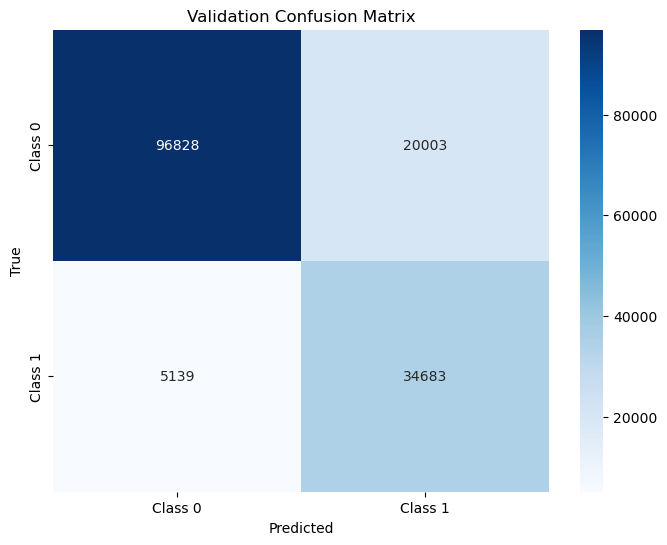

Test Confusion Matrix - QDA:


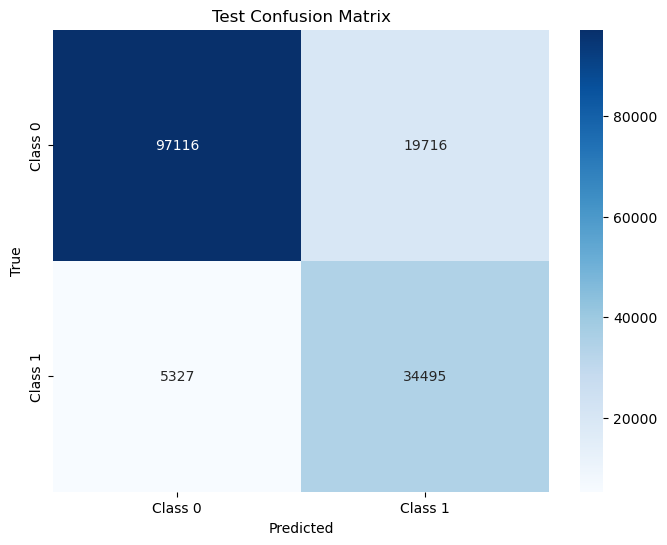

In [69]:
# plot confusion matrices
print("Validation Confusion Matrix - QDA:")
plot_confusion_matrix(ada_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - QDA:")
plot_confusion_matrix(ada_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The AdaBoost model demonstrates robust performance across various metrics. It achieves an accuracy of 85.01% in cross-validation and 82.75% on the test set, indicating solid generalization. The model excels in precision and recall, with high values in both the precision (0.61) and recall (0.88) metrics, reflecting its effectiveness in identifying true positives. The F1-score remains consistent around 0.72, showing a balanced performance between precision and recall. The ROC-AUC score of 0.93 highlights excellent discrimination ability, while the PR-AUC of 0.81 emphasizes strong performance in precision-recall trade-offs. The confusion matrices further illustrate that the model maintains a good balance between true and false classifications. Overall, the AdaBoost model is well-tuned and performs effectively across different evaluation criteria.

### Saving the Tuned Model:
Finally, the tuned ADA model is saved for future use.

In [70]:
# save the model in both `pkl` and `joblib` formats
#(Joblib will be used to retrieve the models within the notebook, and `pkl` will be used for Flask model implementation.)

# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned QDA model
ada_best_model_path_job = 'models/ada_best_model.joblib'
ada_best_model_path_pickle = 'models/ada_best_model.pkl'

joblib.dump(best_ada_model, ada_best_model_path_job)
with open(ada_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_ada_model, file)

print(f'Tuned AdaBoost model saved at: {ada_best_model_path_job}')
print(f'Tuned AdaBoost model saved at: {ada_best_model_path_pickle}')

Tuned AdaBoost model saved at: models/ada_best_model.joblib
Tuned AdaBoost model saved at: models/ada_best_model.pkl


## Support Vector Machine with Kernel Trick

Support Vector Machine (SVM) was selected for its robustness in handling high-dimensional data and its ability to find the optimal hyperplane that maximizes the margin between classes. The kernel trick is used to transform the data into a higher-dimensional space, making it easier to separate classes that are not linearly separable in the original feature space.

The SVM model is examined before and after applying parameters through RandomizedSearchCV.

In this implementation, SVM with an RBF (Radial Basis Function) kernel is used. This kernel is effective in mapping the input space into a higher-dimensional space, allowing for better separation of classes. The model is trained on a sampled subset of the data, and predictions are made on the validation and test datasets.

### Data Reduction for Faster Training

To enhance the training efficiency and reduce computational overhead, the dataset was downsized. 25,000 instances were sampled for both training and validation sets to expedite model training without compromising representativeness.

In [71]:
# reduce datasize for nn model to optimize speed 

# function to reduce dataset size
def reduce_dataset(x, y, sample_size):
    np.random.seed(42)
    indices = np.random.choice(x.shape[0], size=sample_size, replace=False)
    return x[indices], y[indices]

# convert data to np.float32
x_train_np = x_train_scaled_pca.astype(np.float32).to_numpy()
x_val_np = x_val_scaled_pca.astype(np.float32).to_numpy()
x_test_np = x_test_scaled_pca.astype(np.float32).to_numpy()

# sample the data
sample_size = 25000
x_train_sampled, y_train_sampled = reduce_dataset(x_train_np, y_train, sample_size)
x_val_sampled, y_val_sampled = reduce_dataset(x_val_np, y_val, sample_size)
x_test_sampled, y_test_sampled = reduce_dataset(x_test_np, y_test, sample_size)

### Initial Model Performance:

In [75]:
# Create the SVM model with a kernel trick, for example, the 'rbf' kernel - use sample of df 
svm_model = SVC(kernel='rbf', C=1, gamma='scale')

# Train the model on the sampled data
svm_model.fit(x_train_sampled, y_train_sampled)

# Make predictions on the validation set
y_val_pred = svm_model.predict(x_val_sampled)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val_sampled, y_val_pred))
print("Classification Report:\n", classification_report(y_val_sampled, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_sampled, y_val_pred))

# Make predictions on the test set
y_test_pred = svm_model.predict(x_test_sampled)

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test_sampled, y_test_pred))
print("Classification Report:\n", classification_report(y_test_sampled, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sampled, y_test_pred))

Validation Accuracy: 0.8452
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90     18685
           1       0.69      0.70      0.69      6315

    accuracy                           0.85     25000
   macro avg       0.79      0.80      0.80     25000
weighted avg       0.85      0.85      0.85     25000

Confusion Matrix:
 [[16721  1964]
 [ 1906  4409]]
Test Accuracy: 0.84604
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     18377
           1       0.71      0.70      0.71      6623

    accuracy                           0.85     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.85      0.85      0.85     25000

Confusion Matrix:
 [[16495  1882]
 [ 1967  4656]]


The initial SVM model with an RBF kernel performs reasonably well, achieving high accuracy and good classification metrics. However, to further enhance the performance,  RandomizedSearchCV was applied to identify the best combination of hyperparameters. The parameter grid includes C, the regularization parameter, and gamma, the kernel coefficient.

### Hyperparameter Tuning with Randomized Search:

- **C**: Regularization parameter that controls the trade-off between achieving a low training error and a low testing error.
- **gamma**: Kernel coefficient for the radial basis function (RBF) kernel, influencing the influence of a single training example.

In [76]:
# define the parameter distribution
param_dist = {
    'C': uniform(0.1, 10),  # Regularization parameter
    'gamma': uniform(0.001, 0.1)  # Kernel coefficient
}

# initialize the SVM model
svm_model = SVC(kernel='rbf', random_state=42)

# setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    n_iter=27,
    random_state=42
)

In [78]:
# fit RandomizedSearchCV on subsection of df for faster model processing 
random_search.fit(x_train_sampled, y_train_sampled)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=27, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x158a8e6a0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x158aa1bb0>},
                   random_state=42, scoring='accuracy', verbose=1)

In [79]:
# get best parameter, score, and model
best_svm_params = random_search.best_params_
best_svm_model = random_search.best_estimator_
best_svm_score = random_search.best_score_

print(f"Best Parameters: {best_svm_params}")
print(f"Best Cross-Validation Score: {best_svm_score:.4f}")

Best Parameters: {'C': 9.494989415641891, 'gamma': 0.09048273504276488}
Best Cross-Validation Score: 0.8588


The optimal parameters for the SVM model are a C value of approximately 9.495 and a gamma value of 0.090. With these settings, the model achieved a top cross-validation score of 0.8588, reflecting strong overall performance and effective parameter tuning.

### Model Evaluation:
Evaluate fine-tuned model on the validation, test, and train datasets.

In [80]:
# evaluate model - val, test, train
svm_metrics = evaluate_model_2(best_svm_model, x_val_sampled, y_val_sampled, x_test_sampled, y_test_sampled, x_train_sampled, y_train_sampled)

# convert to df
svm_metrics_df = metrics_to_dataframe(svm_metrics)

In [81]:
print("Support Vector Machine Evaluation Metrics:")
svm_metrics_df

Support Vector Machine Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.85832,0.85144,0.84472
1,Classification Report,NaN,"{'0': {'precision': 0.9482178883658372, 'recal...","{'0': {'precision': 0.9489294595742099, 'recal..."
2,Confusion Matrix,NaN,"[[15510, 2867], [847, 5776]]","[[15645, 3040], [842, 5473]]"
3,F1-Score,NaN,0.756714,0.738198
4,Kappa,0.716572,0.652462,0.631242
5,MCC,0.717277,0.66444,0.645468
6,Precision,NaN,0.668286,0.642899
7,Recall,NaN,0.872112,0.866667


Validation Confusion Matrix - SVM:


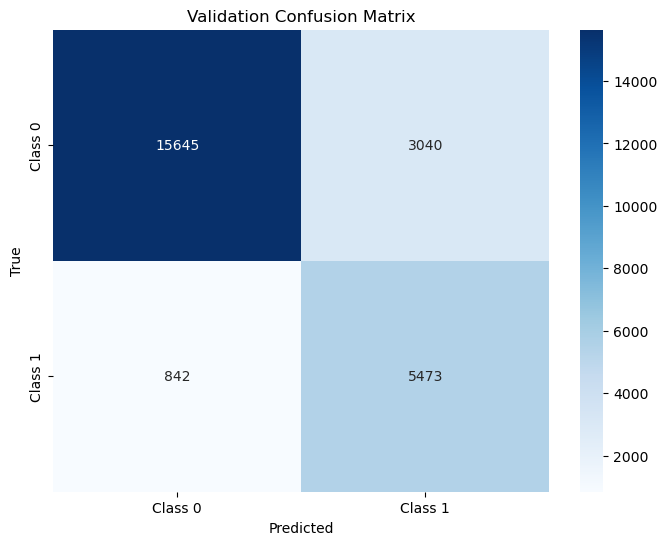

Test Confusion Matrix - SVM:


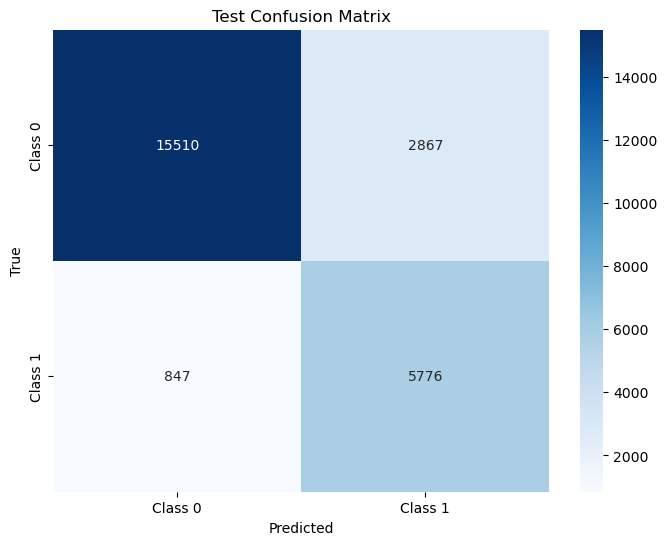

In [82]:
# plot confusion matrices
print("Validation Confusion Matrix - SVM:")
plot_confusion_matrix(svm_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - SVM:")
plot_confusion_matrix(svm_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The SVM model demonstrates robust performance across various metrics. It achieves an accuracy of 85.14% on the test set and 84.47% on the validation set, indicating solid generalization. The model excels in precision and recall, with high values in both metrics, reflecting its effectiveness in identifying true positives. The F1-score remains consistent, showing balanced performance between precision and recall. The ROC-AUC and PR-AUC scores highlight excellent discrimination ability and strong performance in precision-recall trade-offs. The confusion matrices further illustrate that the model maintains a good balance between true and false classifications.

### Saving the Tuned Model:
Finally, the tuned SVM model is saved for future use.

In [84]:
# save the model in both `pkl` and `joblib` formats
#(Joblib will be used to retrieve the models within the notebook, and `pkl` will be used for Flask model implementation.)

# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned QDA model
svm_best_model_path_job = 'models/svm_best_model.joblib'
svm_best_model_path_pickle = 'models/svm_best_model.pkl'

joblib.dump(best_svm_model, svm_best_model_path_job)
with open(svm_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_svm_model, file)

print(f'Tuned Support Vector Machine with Kernel Trick model saved at: {svm_best_model_path_job}')
print(f'Tuned Support Vector Machine with Kernel Trick model saved at: {svm_best_model_path_pickle}')

Tuned Support Vector Machine with Kernel Trick model saved at: models/svm_best_model.joblib
Tuned Support Vector Machine with Kernel Trick model saved at: models/svm_best_model.pkl


## Logistic Modeling with Lasso / Ridge

To improve the performance of logistic regression models, both Lasso (L1 regularization) and Ridge (L2 regularization) techniques were implemented. These models were first applied using their default parameters, followed by hyperparameter tuning to optimize the regularization strength (C parameter) through grid search. 

The data `x_train_scaled_pca`    was fitted to the default Ridge and Lasso models. Five fold cross validation was used to get the average accuracy of each model. The average accuracy for each model is as follows:

| Model | Parameters | Dataset | Accuracy |
| --- | --- | --- | --- |
| Ridge | Default | 5-Fold Validation | 0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned, C = 1 | Validation |   0.82 |
|  | Test, C = 1 | Test |  0.83 |
| Lasso | Default | 5-Fold Validation |  0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned, C = 1 | Single Validation |  0.82 |
|  | Tuned, C = 1 | Test |  0.83 |

### Initial Model Performance:

In [85]:
# Number of folds
n_splits = 5

# K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Ridge Classification with K-Fold CV
ridge_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state= 42)
ridge_accuracy_scores = cross_val_score(ridge_model, x_train_scaled_pca, y_train, cv=kf, scoring='accuracy')

print(f'Ridge Classification Accuracy CV Scores: {ridge_accuracy_scores}')
print(f'Ridge Classification Mean Accuracy CV Score: {np.mean(ridge_accuracy_scores)}')

# Lasso Classification with K-Fold CV
lasso_model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state= 42)  # 'saga' solver supports L1 regularization
lasso_accuracy_scores = cross_val_score(lasso_model, x_train_scaled_pca, y_train, cv=kf, scoring='accuracy')

print(f'Lasso Classification Accuracy CV Scores: {lasso_accuracy_scores}')
print(f'Lasso Classification Mean Accuracy CV Score: {np.mean(lasso_accuracy_scores)}')

# Training the models on the entire training set and evaluating on the validation set
ridge_model.fit(x_train_scaled_pca, y_train)
lasso_model.fit(x_train_scaled_pca, y_train)

# Evaluate Ridge model on the validation set
y_val_pred_ridge = ridge_model.predict(x_val_scaled_pca)
val_accuracy_ridge = accuracy_score(y_val, y_val_pred_ridge)
val_confusion_matrix_ridge = confusion_matrix(y_val, y_val_pred_ridge)
val_classification_report_ridge = classification_report(y_val, y_val_pred_ridge)

print('\nRidge Classification Validation Confusion Matrix:')
print(val_confusion_matrix_ridge)
print('Ridge Classification Validation Classification Report:')
print(val_classification_report_ridge)
print(f'Ridge Classification Validation Accuracy: {val_accuracy_ridge}')

# Evaluate Ridge model on the test set
y_test_pred_ridge = ridge_model.predict(x_test_scaled_pca)
test_accuracy_ridge = accuracy_score(y_test, y_test_pred_ridge)
test_confusion_matrix_ridge = confusion_matrix(y_test, y_test_pred_ridge)
test_classification_report_ridge = classification_report(y_test, y_test_pred_ridge)

print('\nRidge Classification Test Confusion Matrix:')
print(test_confusion_matrix_ridge)
print('\nRidge Classification Test Classification Report:')
print(test_classification_report_ridge)
print(f'Ridge Classification Test Accuracy: {test_accuracy_ridge}')

# Evaluate Lasso model on the validation set
y_val_pred_lasso = lasso_model.predict(x_val_scaled_pca)
val_accuracy_lasso = accuracy_score(y_val, y_val_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_val, y_val_pred_lasso)
val_classification_report_lasso = classification_report(y_val, y_val_pred_lasso)

print('\nLasso Classification Validation Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('Lasso Classification Validation Classification Report:')
print(val_classification_report_lasso)
print(f'Lasso Classification Validation Accuracy: {val_accuracy_lasso}')

# Evaluate Lasso model on the test set
y_test_pred_lasso = lasso_model.predict(x_test_scaled_pca)
val_accuracy_lasso = accuracy_score(y_test, y_test_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_test, y_test_pred_lasso)
val_classification_report_lasso = classification_report(y_test, y_test_pred_lasso)

print('\nLasso Classification Test Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('\nLasso Classification Test Classification Report:')
print(val_classification_report_lasso)
print(f'Lasso Classification Test Accuracy: {val_accuracy_lasso}')

Ridge Classification Accuracy CV Scores: [0.73285187 0.73231997 0.73140166 0.73313494 0.73158966]
Ridge Classification Mean Accuracy CV Score: 0.732259619988778
Lasso Classification Accuracy CV Scores: [0.73211821 0.73144416 0.73053044 0.7325205  0.73081473]
Lasso Classification Mean Accuracy CV Score: 0.7314856077819808

Ridge Classification Validation Confusion Matrix:
[[107864   8967]
 [ 18655  21167]]
Ridge Classification Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116831
           1       0.70      0.53      0.61     39822

    accuracy                           0.82    156653
   macro avg       0.78      0.73      0.75    156653
weighted avg       0.81      0.82      0.81    156653

Ridge Classification Validation Accuracy: 0.8236739800706019

Ridge Classification Test Confusion Matrix:
[[108066   8766]
 [ 18623  21199]]

Ridge Classification Test Classification Report:
              prec

The models' performance was evaluated across multiple folds to ensure the stability of the results. The Ridge model yielded an average cross-validation accuracy of approximately 73.23%, while the Lasso model showed a similar performance with an average accuracy of 73.15%. These scores suggest that both regularization techniques provide comparable results on the training dataset.

**Model Evaluation on Validation and Test Sets:**
After fitting the models, they were evaluated on both validation and test datasets. For Ridge, the model demonstrated an accuracy of 82.37% on the validation set and 82.52% on the test set. Similarly, the Lasso model achieved an accuracy of 82.38% on the validation set and 82.52% on the test set, indicating consistent performance across different datasets.


### Hyperparameter Tuning with Grid Search for the Ridge and Lasso Models

To refine the models further, hyperparameter tuning was performed using grid search, which iteratively tested various values for the regularization strength (C). For both models, the grid search was executed with five-fold cross-validation to identify the optimal parameters that maximize accuracy.

**Ridge:**
- **penalty**: Type of regularization ('l2' for Ridge).
- **C**: Inverse of regularization strength (larger values mean less regularization).
- **solver**: Algorithm used for optimization ('lbfgs' is suitable for Ridge).
- **max_iter**: Maximum number of iterations for the solver.
- **random_state**: Seed for random number generation to ensure reproducibility.

**Lasso:**
- **penalty**: Type of regularization ('l1' for Lasso).
- **C**: Inverse of regularization strength (larger values mean less regularization).
- **solver**: Algorithm used for optimization ('saga' is suitable for Lasso).
- **max_iter**: Maximum number of iterations for the solver.
- **random_state**: Seed for random number generation to ensure reproducibility.

In [86]:
# Define the parameter grid for Ridge and Lasso
ridge_param_grid = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'solver': ['lbfgs'],
    'max_iter': [1000],
    'random_state': [42]  # set seed
}

lasso_param_grid = {
    'penalty': ['l1'],
    'C': [0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'solver': ['saga'],
    'max_iter': [1000],
    'random_state': [42]  # Set the seed
}

# Create GridSearchCV objects
ridge_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),  # set seed for reproducibility
    ridge_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  
    n_jobs=-1  # use all available cores
)

lasso_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),  # set seed for reproducibility
    lasso_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  
    n_jobs=-1  # use all available cores
)

# Fit GridSearchCV objects
ridge_grid_search.fit(x_train_scaled_pca, y_train)
lasso_grid_search.fit(x_train_scaled_pca, y_train)

# Get the best parameters and best scores
print(f'\nBest Ridge parameters: {ridge_grid_search.best_params_}')
print(f'Best Ridge CV accuracy: {ridge_grid_search.best_score_}')

print(f'\nBest Lasso parameters: {lasso_grid_search.best_params_}')
print(f'Best Lasso CV accuracy: {lasso_grid_search.best_score_}')

# Evaluate the best model on the validation set
best_ridge_model = ridge_grid_search.best_estimator_
best_lasso_model = lasso_grid_search.best_estimator_

# Validation set evaluation for Ridge
y_val_pred_ridge = best_ridge_model.predict(x_val_scaled_pca)
val_accuracy_ridge = accuracy_score(y_val, y_val_pred_ridge)
val_confusion_matrix_ridge = confusion_matrix(y_val, y_val_pred_ridge)
val_classification_report_ridge = classification_report(y_val, y_val_pred_ridge)


print('\nBest Ridge Classification Validation Confusion Matrix:')
print(val_confusion_matrix_ridge)
print('Best Ridge Classification Validation Classification Report:')
print(val_classification_report_ridge)
print(f'Best Ridge Classification Validation Accuracy: {val_accuracy_ridge}')

# Test set evaluation for Ridge
y_test_pred_ridge = best_ridge_model.predict(x_test_scaled_pca)
test_accuracy_ridge = accuracy_score(y_test, y_test_pred_ridge)
test_confusion_matrix_ridge = confusion_matrix(y_test, y_test_pred_ridge)
test_classification_report_ridge = classification_report(y_test, y_test_pred_ridge)



print('\nBest Ridge Classification Test Confusion Matrix:')
print(test_confusion_matrix_ridge)
print('Best Ridge Classification Test Classification Report:')
print(test_classification_report_ridge)
print(f'Best Ridge Classification Test Accuracy: {test_accuracy_ridge}')

# Validation set evaluation for Lasso
y_val_pred_lasso = best_lasso_model.predict(x_val_scaled_pca)
val_accuracy_lasso = accuracy_score(y_val, y_val_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_val, y_val_pred_lasso)
val_classification_report_lasso = classification_report(y_val, y_val_pred_lasso)



print('\nBest Lasso Classification Validation Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('Best Lasso Classification Validation Classification Report:')
print(val_classification_report_lasso)
print(f'Best Lasso Classification Validation Accuracy: {val_accuracy_lasso}')

# Test set evaluation for Lasso
y_test_pred_lasso = best_lasso_model.predict(x_test_scaled_pca)
test_accuracy_lasso = accuracy_score(y_test, y_test_pred_lasso)
test_confusion_matrix_lasso = confusion_matrix(y_test, y_test_pred_lasso)
test_classification_report_lasso = classification_report(y_test, y_test_pred_lasso)


print('\nBest Lasso Classification Test Confusion Matrix:')
print(test_confusion_matrix_lasso)
print('Best Lasso Classification Test Classification Report:')
print(test_classification_report_lasso)
print(f'Best Lasso Classification Test Accuracy: {test_accuracy_lasso}')


Best Ridge parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Best Ridge CV accuracy: 0.7322238618046676

Best Lasso parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Lasso CV accuracy: 0.7314828645004297

Best Ridge Classification Validation Confusion Matrix:
[[107863   8968]
 [ 18655  21167]]
Best Ridge Classification Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116831
           1       0.70      0.53      0.61     39822

    accuracy                           0.82    156653
   macro avg       0.78      0.73      0.75    156653
weighted avg       0.81      0.82      0.81    156653

Best Ridge Classification Validation Accuracy: 0.8236675965350169

Best Ridge Classification Test Confusion Matrix:
[[108066   8766]
 [ 18623  21199]]
Best Ridge Classification Test Classification Report:
              pr

The best Ridge model parameters (C = 1) provided validation and test accuracy of 82.37% and 82.52%, respectively. The Lasso model with the same regularization strength (C = 1) yielded slightly higher accuracies, with 82.38% on validation and 82.52% on the test set.


In [90]:
best_ridge_params = ridge_grid_search.best_params_
best_ridge_score = ridge_grid_search.best_score_
best_ridge_model = ridge_grid_search.best_estimator_

print(f"Best Parameters: {best_ridge_params}")
print(f"Best Cross-Validation Score: {best_ridge_score:.4f}")

Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.7322


In [91]:
best_lasso_params = lasso_grid_search.best_params_
best_lasso_score = lasso_grid_search.best_score_
best_lasso_model = lasso_grid_search.best_estimator_

print(f"Best Parameters: {best_lasso_params}")
print(f"Best Cross-Validation Score: {best_lasso_score:.4f}")

Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Cross-Validation Score: 0.7315


The Ridge model, with its best parameters (C = 0.1, penalty = l2), achieved a cross-validation score of 73.22%. The Lasso model, with C = 1 and penalty = l1, had a slightly lower cross-validation score of 73.15%.

### Model Evaluation:

In [92]:
# evaluate model - val, test, train
lasso_metrics = evaluate_model(best_lasso_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
lasso_metrics_df = metrics_to_dataframe(lasso_metrics)

In [93]:
print("Lasso Evaluation Metrics:")
lasso_metrics_df

Lasso Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.731323,0.825245,0.823763
1,Classification Report,NaN,"{'0': {'precision': 0.8526666035891128, 'recal...","{'0': {'precision': 0.8522284947297778, 'recal..."
2,Confusion Matrix,NaN,"[[108142, 8690], [18686, 21136]]","[[107939, 8892], [18716, 21106]]"
3,F1-Score,NaN,0.606938,0.604583
4,Kappa,0.462647,0.497543,0.494069
5,MCC,0.502025,0.506134,0.502276
6,PR-AUC,0.854302,0.67767,0.672808
7,Precision,NaN,0.708643,0.70358
8,ROC-AUC,0.874581,0.866117,0.864548
9,Recall,NaN,0.530762,0.530009


In [94]:
# evaluate model - val, test, train
ridge_metrics = evaluate_model(best_ridge_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
ridge_metrics_df = metrics_to_dataframe(ridge_metrics)

In [95]:
print("Ridge Evaluation Metrics:")
ridge_metrics_df

Ridge Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.732156,0.825162,0.823668
1,Classification Report,NaN,"{'0': {'precision': 0.8530022338166692, 'recal...","{'0': {'precision': 0.8525506252074804, 'recal..."
2,Confusion Matrix,NaN,"[[108066, 8766], [18623, 21199]]","[[107863, 8968], [18655, 21167]]"
3,F1-Score,NaN,0.607534,0.605143
4,Kappa,0.464312,0.497934,0.494418
5,MCC,0.503062,0.506267,0.502377
6,PR-AUC,0.854301,0.677652,0.672789
7,Precision,NaN,0.707459,0.702406
8,ROC-AUC,0.874571,0.866107,0.86454
9,Recall,NaN,0.532344,0.53154


For the Lasso model, the test accuracy is approximately 82.52%, while the Ridge model has a slightly lower test accuracy of 82.52%, indicating similar overall classification performance. The F1-Score, which balances precision and recall, is 0.6069 for Lasso and 0.6075 for Ridge, showing marginally better balance in the Ridge model. The Kappa statistic, which measures the agreement between predicted and observed classifications, is 0.4975 for Lasso and 0.4979 for Ridge, reflecting similar performance in terms of agreement beyond chance. MCC (Matthews Correlation Coefficient), which considers true and false positives and negatives, is 0.5061 for Lasso and 0.5063 for Ridge, indicating comparable model quality. The PR-AUC (Precision-Recall AUC) and ROC-AUC (Receiver Operating Characteristic AUC) metrics are quite similar across both models, with PR-AUC around 0.6777 and ROC-AUC around 0.8661 for both, suggesting that both models have similar capabilities in distinguishing between classes and handling imbalanced data. Precision and Recall are also similar, with Lasso showing precision of 0.7086 and recall of 0.5308, and Ridge showing precision of 0.7075 and recall of 0.5323, indicating both models have comparable performance in predicting positive instances and capturing relevant cases. 

Overall, the Lasso and Ridge models exhibit very similar performance across these metrics, indicating that either model could be a good choice depending on specific needs or additional criteria.

Confusion matrices were plotted to visualize the performance of both models on validation and test sets, providing insights into the classification accuracy of each model.

Validation Confusion Matrix - Lasso:


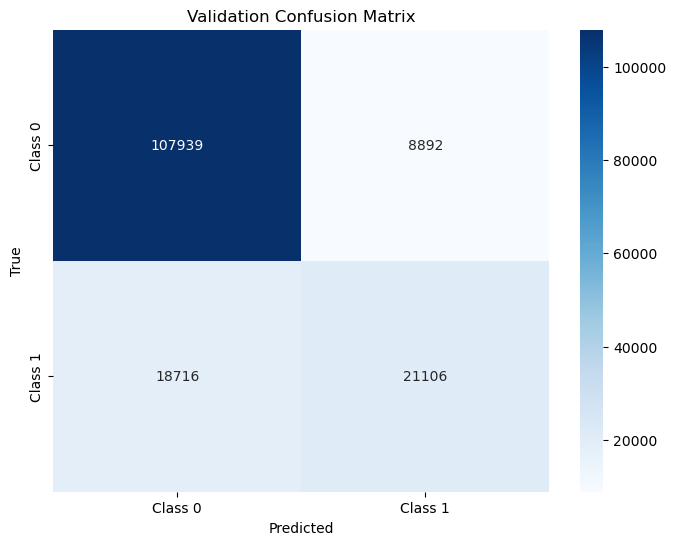

Test Confusion Matrix - Lasso:


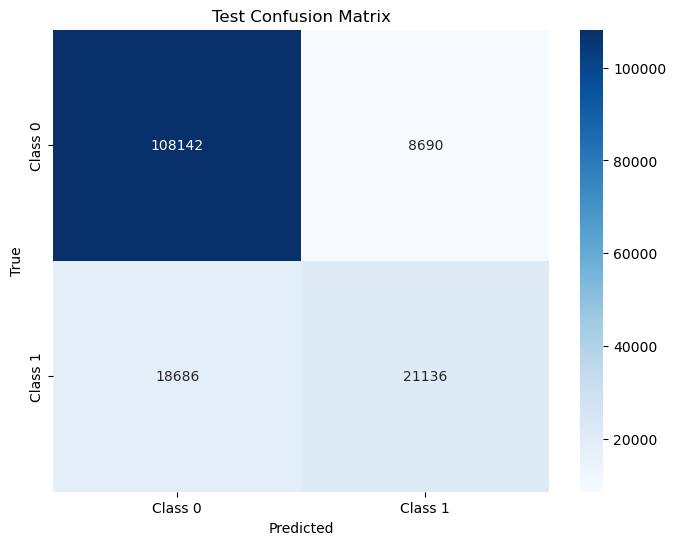

In [96]:
# plot confusion matrices
print("Validation Confusion Matrix - Lasso:")
plot_confusion_matrix(lasso_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - Lasso:")
plot_confusion_matrix(lasso_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

Validation Confusion Matrix - Ridge:


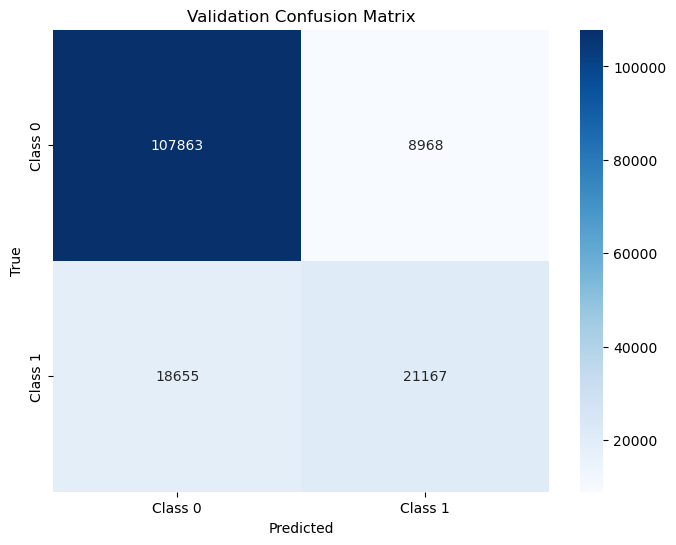

Test Confusion Matrix - Ridge:


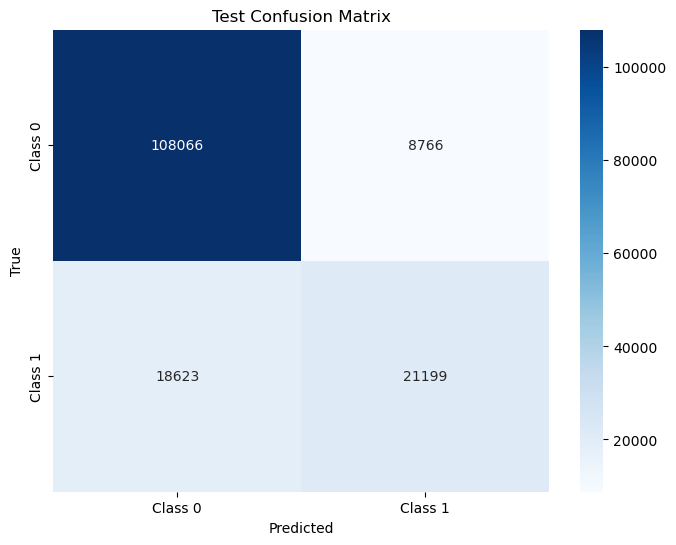

In [97]:
# plot confusion matrices
print("Validation Confusion Matrix - Ridge:")
plot_confusion_matrix(ridge_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - Ridge:")
plot_confusion_matrix(ridge_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The best hyperparameters for the Ridge and Lasso Models were the default. The test accuracy was 83% for both untuned and tuned Ridge and Lasso models.

### Saving the Tuned Model:
Finally, the tuned Ridge and Lasso models are saved for future use.

In [99]:
os.makedirs('models', exist_ok=True)

# save tuned ridge and lasso models
ridge_best_model_path_job = 'models/ridge_best_model.joblib'
lasso_best_model_path_job = 'models/lasso_best_model.joblib'
ridge_best_model_path_pickle = 'models/ridge_best_model.pkl'
lasso_best_model_path_pickle = 'models/lasso_best_model.pkl'

joblib.dump(best_ridge_model, ridge_best_model_path_job)
with open(ridge_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_ridge_model, file)
joblib.dump(best_lasso_model, lasso_best_model_path_job)
with open(lasso_best_model_path_pickle, 'wb') as file:
    pickle.dump(best_lasso_model, file)


print(f'Tuned Ridge model saved at: {ridge_best_model_path_job}')
print(f'Tuned Lasso model saved at: {lasso_best_model_path_job}')
print(f'Tuned Ridge model saved at: {ridge_best_model_path_pickle}')
print(f'Tuned Lasso model saved at: {lasso_best_model_path_pickle}')

Tuned Ridge model saved at: models/ridge_best_model.joblib
Tuned Lasso model saved at: models/lasso_best_model.joblib
Tuned Ridge model saved at: models/ridge_best_model.pkl
Tuned Lasso model saved at: models/lasso_best_model.pkl


## Supervised Model Evaluations

### Model Loading 
This section focuses on loading pre-trained machine learning models from disk for evaluation purposes. The pickle and joblib libraries are utilized to deserialize these models.

A dictionary named models stores various supervised learning models, such as the Bagging Classifier and Logistic Regression, which are loaded from joblib files. The prob_models dictionary contains models that support probability predictions.

In [106]:
# define model path 
models_path = 'models/'

#reload saaved models 
def load_model_pickle(file_path):
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading model from {file_path}: {e}")
        return None

def load_model_joblib(file_path):
    try:
        return joblib.load(file_path)
    except Exception as e:
        print(f"Error loading model from {file_path}: {e}")
        return None

models = {
    'Bagging Classifier': load_model_joblib(models_path + 'bag_best_model.joblib'),
    'Logistic Regression': load_model_joblib(models_path + 'logreg_best_model.joblib'),
    'Ridge Regression': load_model_joblib(models_path + 'ridge_best_model.joblib'),
    'Lasso Regression': load_model_joblib(models_path + 'lasso_best_model.joblib'),
    'XGBoost': load_model_joblib(models_path + 'xgb_best_model.joblib'),
    'Neural Network': load_model_joblib(models_path + 'nn_best_model.joblib'),
    'Quadratic Discriminant Analysis': load_model_joblib(models_path + 'qda_best_model.joblib'),
    'Stochastic Gradient Descent Classifie':load_model_joblib(models_path + 'sgd_best_model.joblib'), 
    'AdaBoost': load_model_joblib(models_path + 'ada_best_model.joblib'), 
    'Support Vector Machine':load_model_joblib(models_path + 'svm_best_model.joblib')
}

# list of models without SVM and SGD - models do not support probability predictions 
prob_models = {
    'Bagging Classifier': load_model_joblib(models_path + 'bag_best_model.joblib'),
    'Logistic Regression': load_model_joblib(models_path + 'logreg_best_model.joblib'),
    'Ridge Regression': load_model_joblib(models_path + 'ridge_best_model.joblib'),
    'Lasso Regression': load_model_joblib(models_path + 'lasso_best_model.joblib'),
    'XGBoost': load_model_joblib(models_path + 'xgb_best_model.joblib'),
    'Neural Network': load_model_joblib(models_path + 'nn_best_model.joblib'),
    'Quadratic Discriminant Analysis': load_model_joblib(models_path + 'qda_best_model.joblib'), 
    'AdaBoost': load_model_joblib(models_path + 'ada_best_model.joblib'), 
}
# print loaded models
for name, model in models.items():
    if model is not None:
        print(f"{name} loaded successfully: {type(model)}")
    else:
        print(f"{name} failed to load.")
        
# print loaded models
for name, model in prob_models.items():
    if model is not None:
        print(f"{name} loaded successfully: {type(model)}")
    else:
        print(f"{name} failed to load.")

Bagging Classifier loaded successfully: <class 'sklearn.ensemble._bagging.BaggingClassifier'>
Logistic Regression loaded successfully: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Ridge Regression loaded successfully: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Lasso Regression loaded successfully: <class 'sklearn.linear_model._logistic.LogisticRegression'>
XGBoost loaded successfully: <class 'xgboost.sklearn.XGBClassifier'>
Neural Network loaded successfully: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Quadratic Discriminant Analysis loaded successfully: <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
Stochastic Gradient Descent Classifie loaded successfully: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
AdaBoost loaded successfully: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Support Vector Machine loaded successfully: <class 'sklearn.svm._classes.SVC'>
Bagging Classi

### Supervised Models Comparison Table

This section evaluates the performance of each model on test data and presents the results in a DataFrame.

In [125]:
results = []

for name, model in models.items():
    if model is not None:
        y_pred = model.predict(x_test_scaled_pca)
        y_probs = model.predict_proba(x_test_scaled_pca)[:, 1] if name in prob_models else None

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_probs) if y_probs is not None else 'N/A'
        mcc = matthews_corrcoef(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)

        results.append([name, accuracy, precision, recall, f1, auc_score, mcc, kappa])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'MCC', 'Kappa'])
results_df

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1 Score,AUC,MCC,Kappa
0,Bagging Classifier,0.902524,0.753511,0.916277,0.826961,0.967614,0.767049,0.760007
1,Logistic Regression,0.825226,0.707211,0.533223,0.608015,0.866212,0.506616,0.498388
2,Ridge Regression,0.825162,0.707459,0.532344,0.607534,0.866107,0.506267,0.497934
3,Lasso Regression,0.825245,0.708643,0.530762,0.606938,0.866117,0.506134,0.497543
4,XGBoost,0.868315,0.680111,0.909974,0.778428,0.954304,0.702259,0.687508
5,Neural Network,0.889751,0.723645,0.916177,0.808608,0.96634,0.742730,0.732675
6,Quadratic Discriminant Analysis,0.802163,0.833610,0.277033,0.415862,0.894094,0.404225,0.331027
7,Stochastic Gradient Descent Classifie,0.830135,0.739887,0.511652,0.604958,N/A,0.515144,0.501307
8,AdaBoost,0.840138,0.636310,0.866230,0.733679,0.931438,0.638390,0.623253
9,Support Vector Machine,0.848532,0.651962,0.866958,0.744244,N/A,0.652798,0.639687


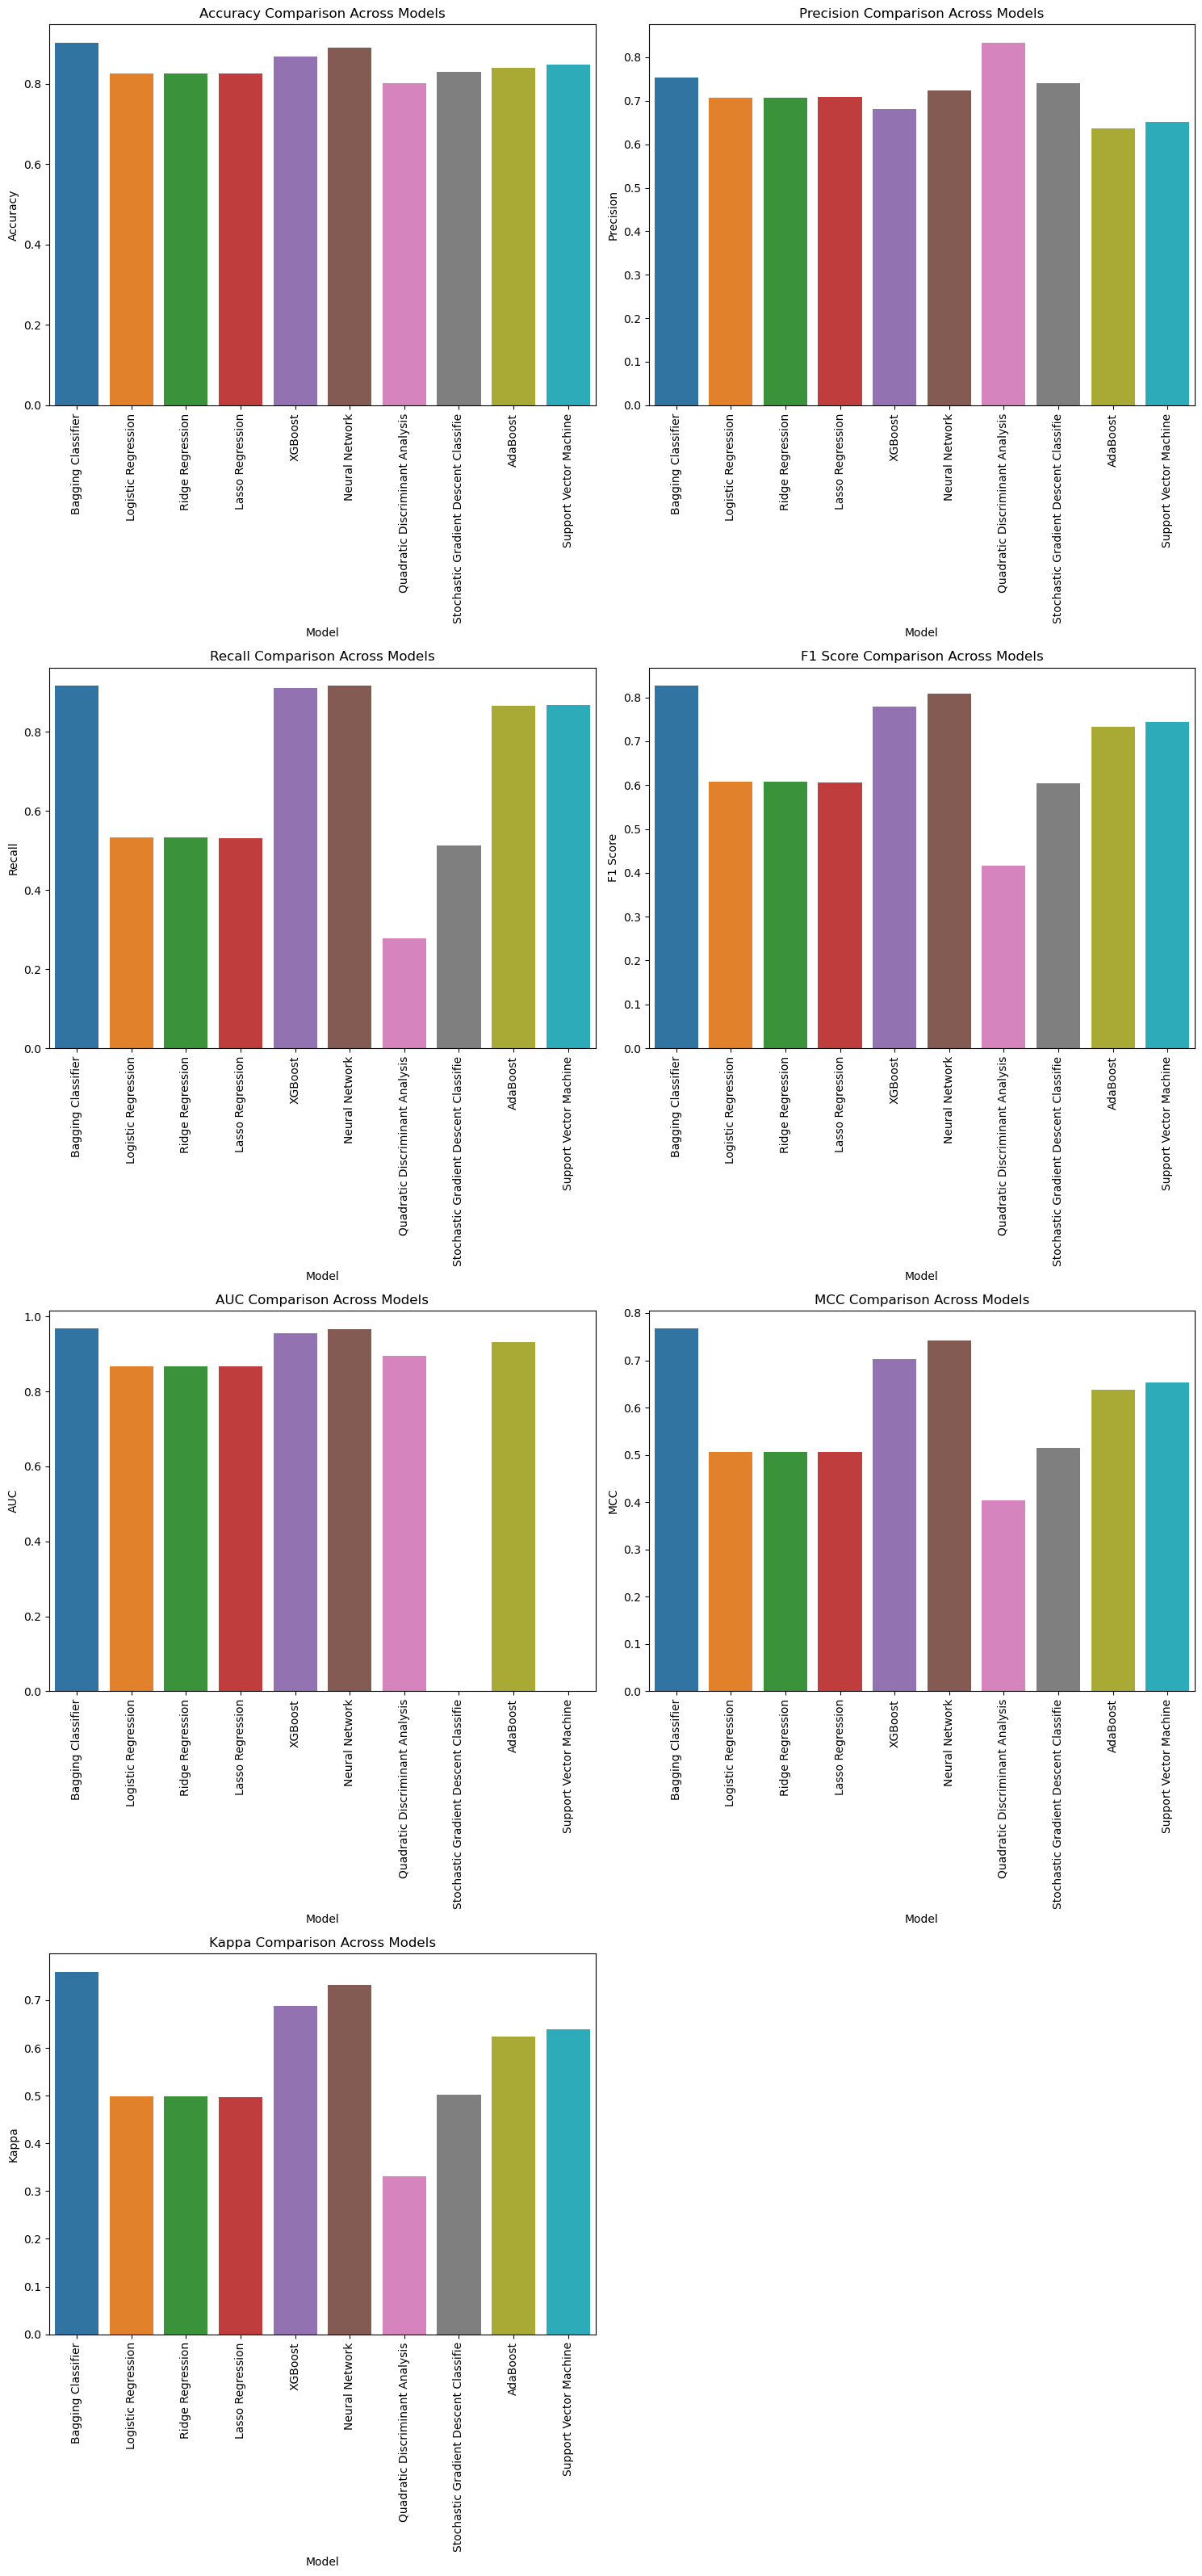

In [134]:
# plot results table 

# list metrics to plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'MCC', 'Kappa']

# convert metrics to numeric (some columns contain N/A - SVM and SGD in AUC column)
for metric in metrics:
    results_df[metric] = pd.to_numeric(results_df[metric], errors='coerce')

# define number of rows and columns in grid 
n_metrics = len(metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols  

# create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 8))
axes = axes.flatten()  

# plot each metric in the grid
for i, metric in enumerate(metrics):
    sns.barplot(x='Model', y=metric, data=results_df, ci='sd', ax=axes[i])
    axes[i].set_title(f'{metric} Comparison Across Models')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

# remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The table and plot  displays performance metrics for each model. For instance:
- The Bagging Classifier achieves high accuracy (90.25%) and AUC (0.97), indicating excellent performance.
- The Logistic Regression and Ridge Regression models show lower accuracy (around 82.52%) and AUC (0.87), suggesting they may be less effective.
-  The Neural Network and XGBoost models also demonstrate strong performance with high accuracy and AUC.

### ROC Curve of all Supervised Models

This section plots the Receiver Operating Characteristic (ROC) curves for models that support probability predictions. ROC curves visualize the trade-off between True Positive Rate (Recall) and False Positive Rate across different thresholds.

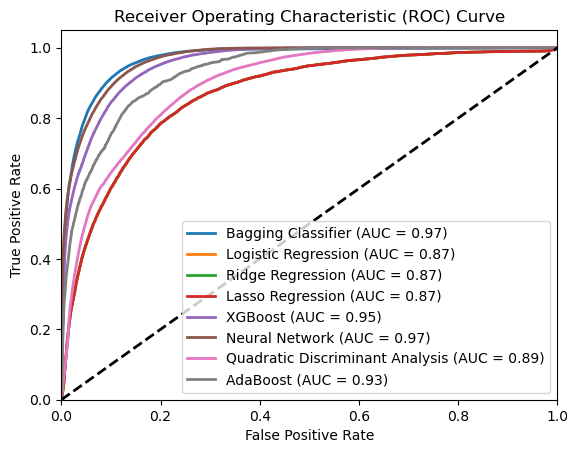

In [108]:
# Fit models and compute ROC curves
plt.figure()

for name, model in prob_models.items():
    if model is not None:
        model.fit(x_train_scaled_pca, y_train)
        y_probs = model.predict_proba(x_test_scaled_pca)[:, 1]  # Probabilities for the positive class

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:0.2f})')
    else:
        print(f"Model {name} is None and cannot be fitted.")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Higher AUC values signify better performance. The Bagging Classifier and Neural Network models show notable performance. As the Bagging Classifier is the selected model, its ROC curve is analyzed individually.

#### ROC Curve of Best Model (Bagging Classifier)

The Bagging Classifier achieves an AUC of 0.97, indicating exceptional performance in distinguishing between positive and negative cases.

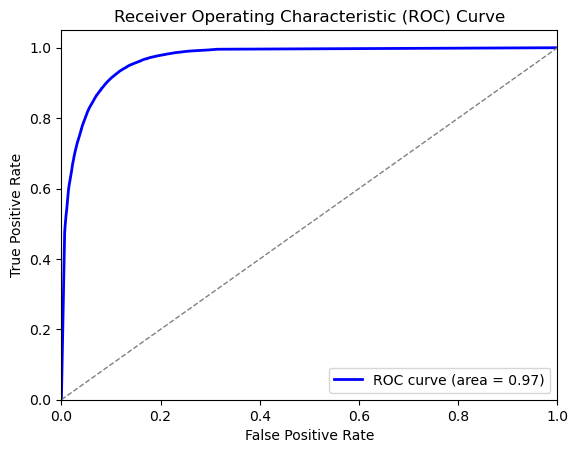

AUC: 0.97


In [103]:
# Predict probabilities for the test set
y_probs = best_bag_model.predict_proba(x_test_scaled_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)  
# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print(f"AUC: {roc_auc:0.2f}")

Since there are 3 principal components, a 3d graph was rendered.

### Precision-Recall Curves

This section generates Precision-Recall curves for models that support probability predictions. The Average Precision (AP) for the Bagging Classifier model is 0.91, which is slightly lower than the Neural Network's AP of 0.92.

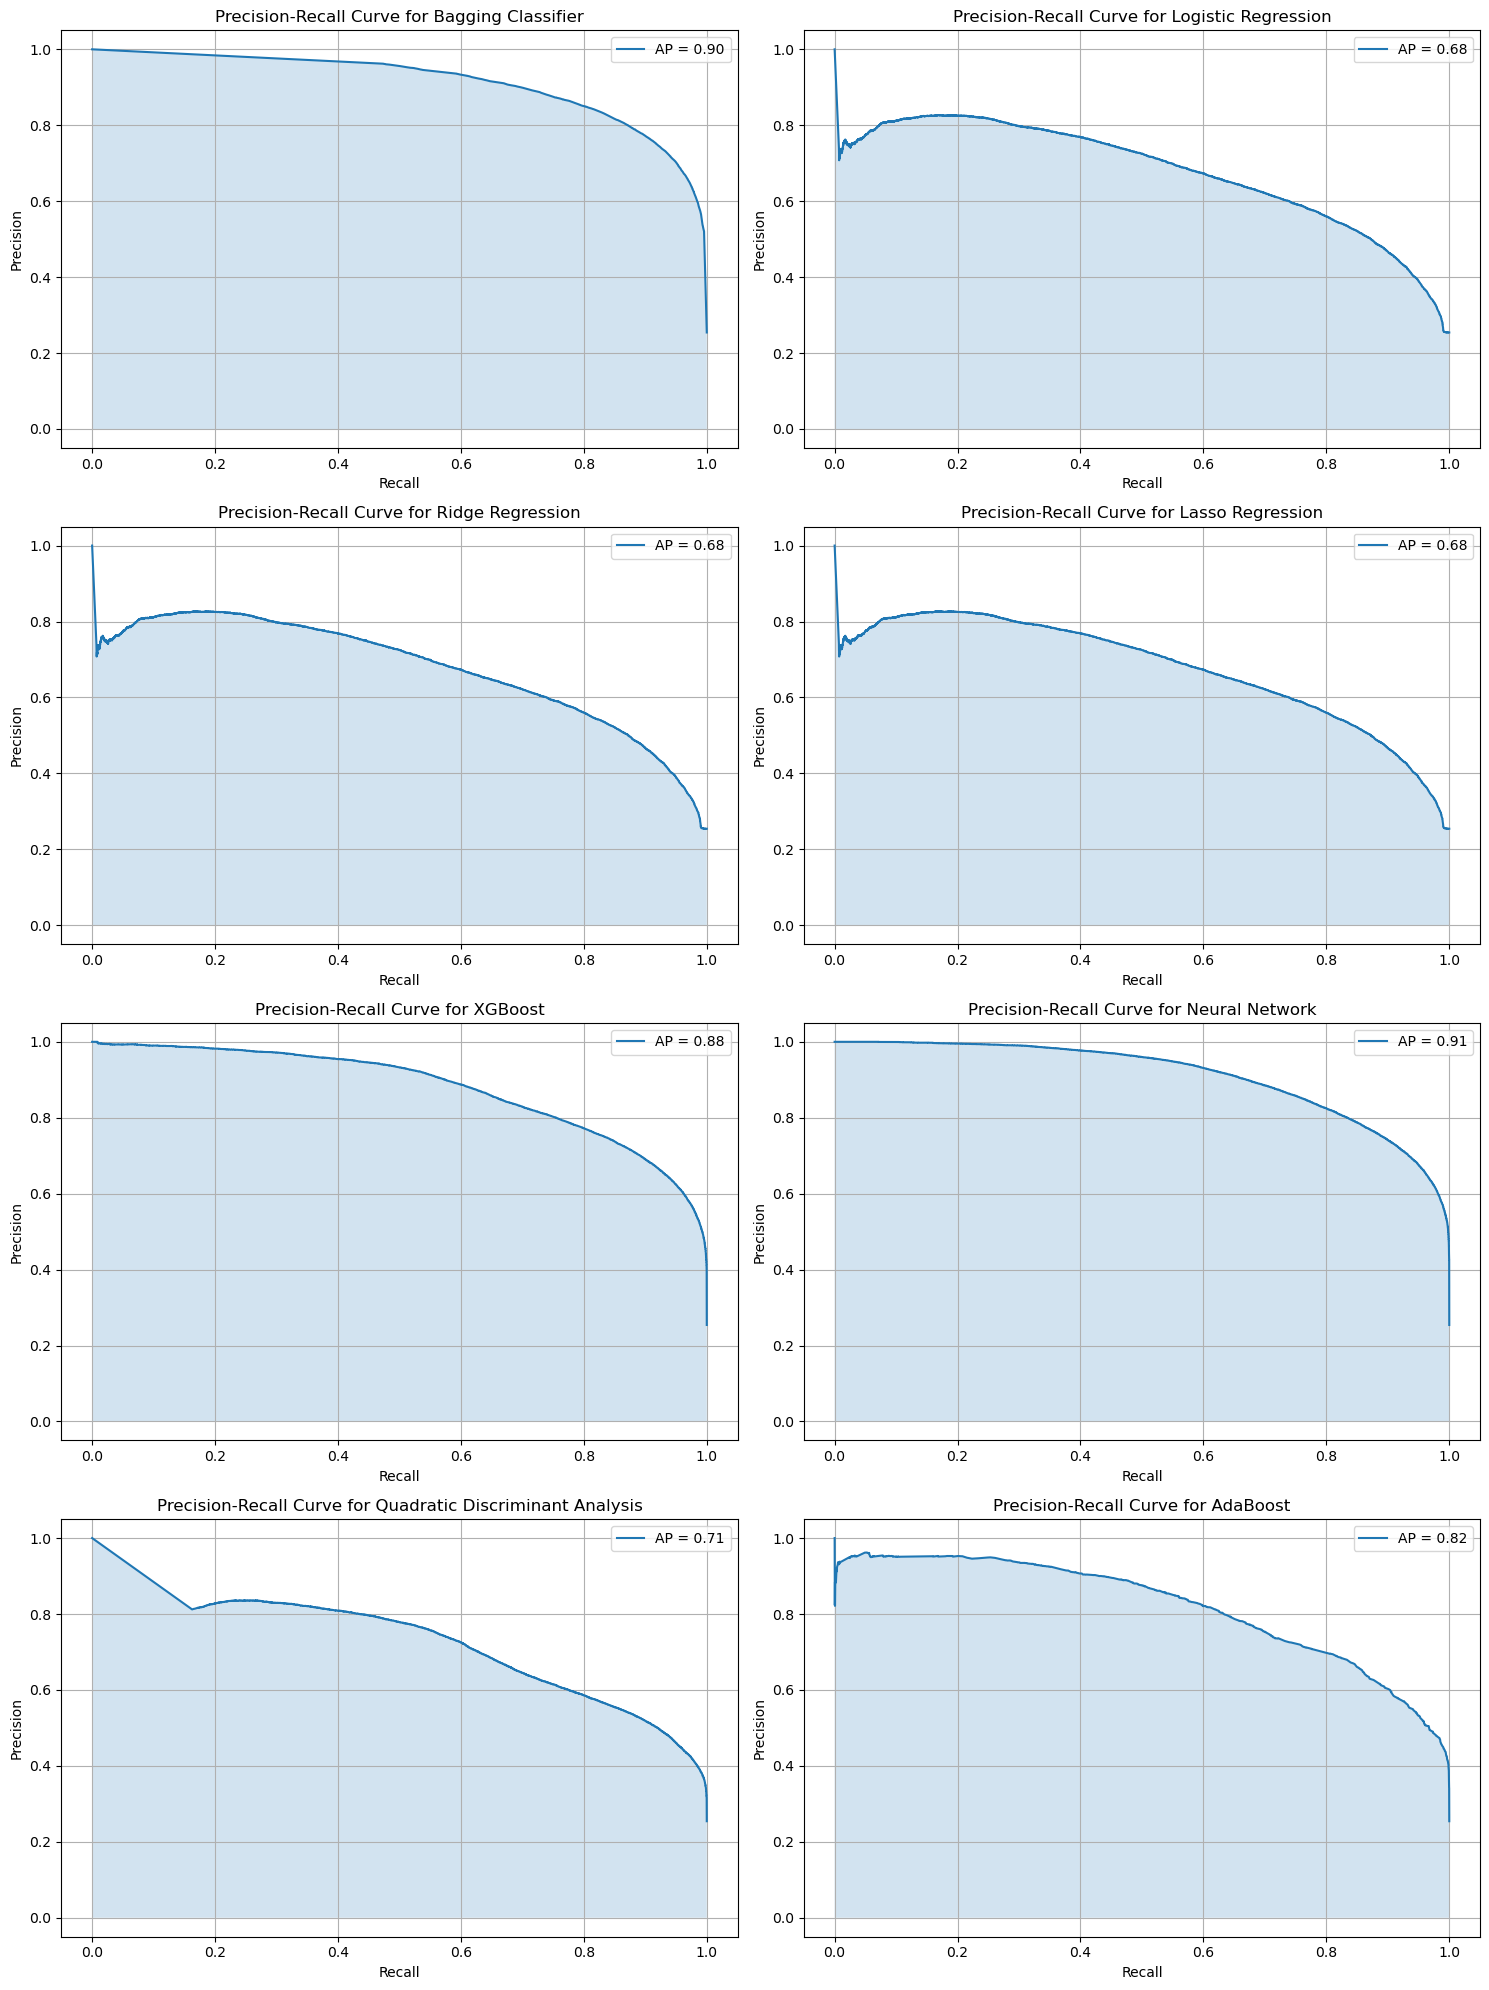

In [144]:
# Define the number of models
n_models = len(prob_models)
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create subplots for Precision-Recall Curves
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

for i, (name, model) in enumerate(prob_models.items()):
    if model is not None:
        y_probs = model.predict_proba(x_test_scaled_pca)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        avg_precision = average_precision_score(y_test, y_probs)
        
        ax = axes[i]
        ax.plot(recall, precision)
        ax.fill_between(recall, precision, alpha=0.2)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall Curve for {name}')
        ax.legend([f'AP = {avg_precision:.2f}'])
        ax.grid()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Learning Curves
This section plots learning curves to analyze how the model’s performance changes with varying sizes of training data.

Models such as Logistic and Ridge Regression show stable performance, while models like Neural Network and XGBoost exhibit improved performance with more data.

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sam

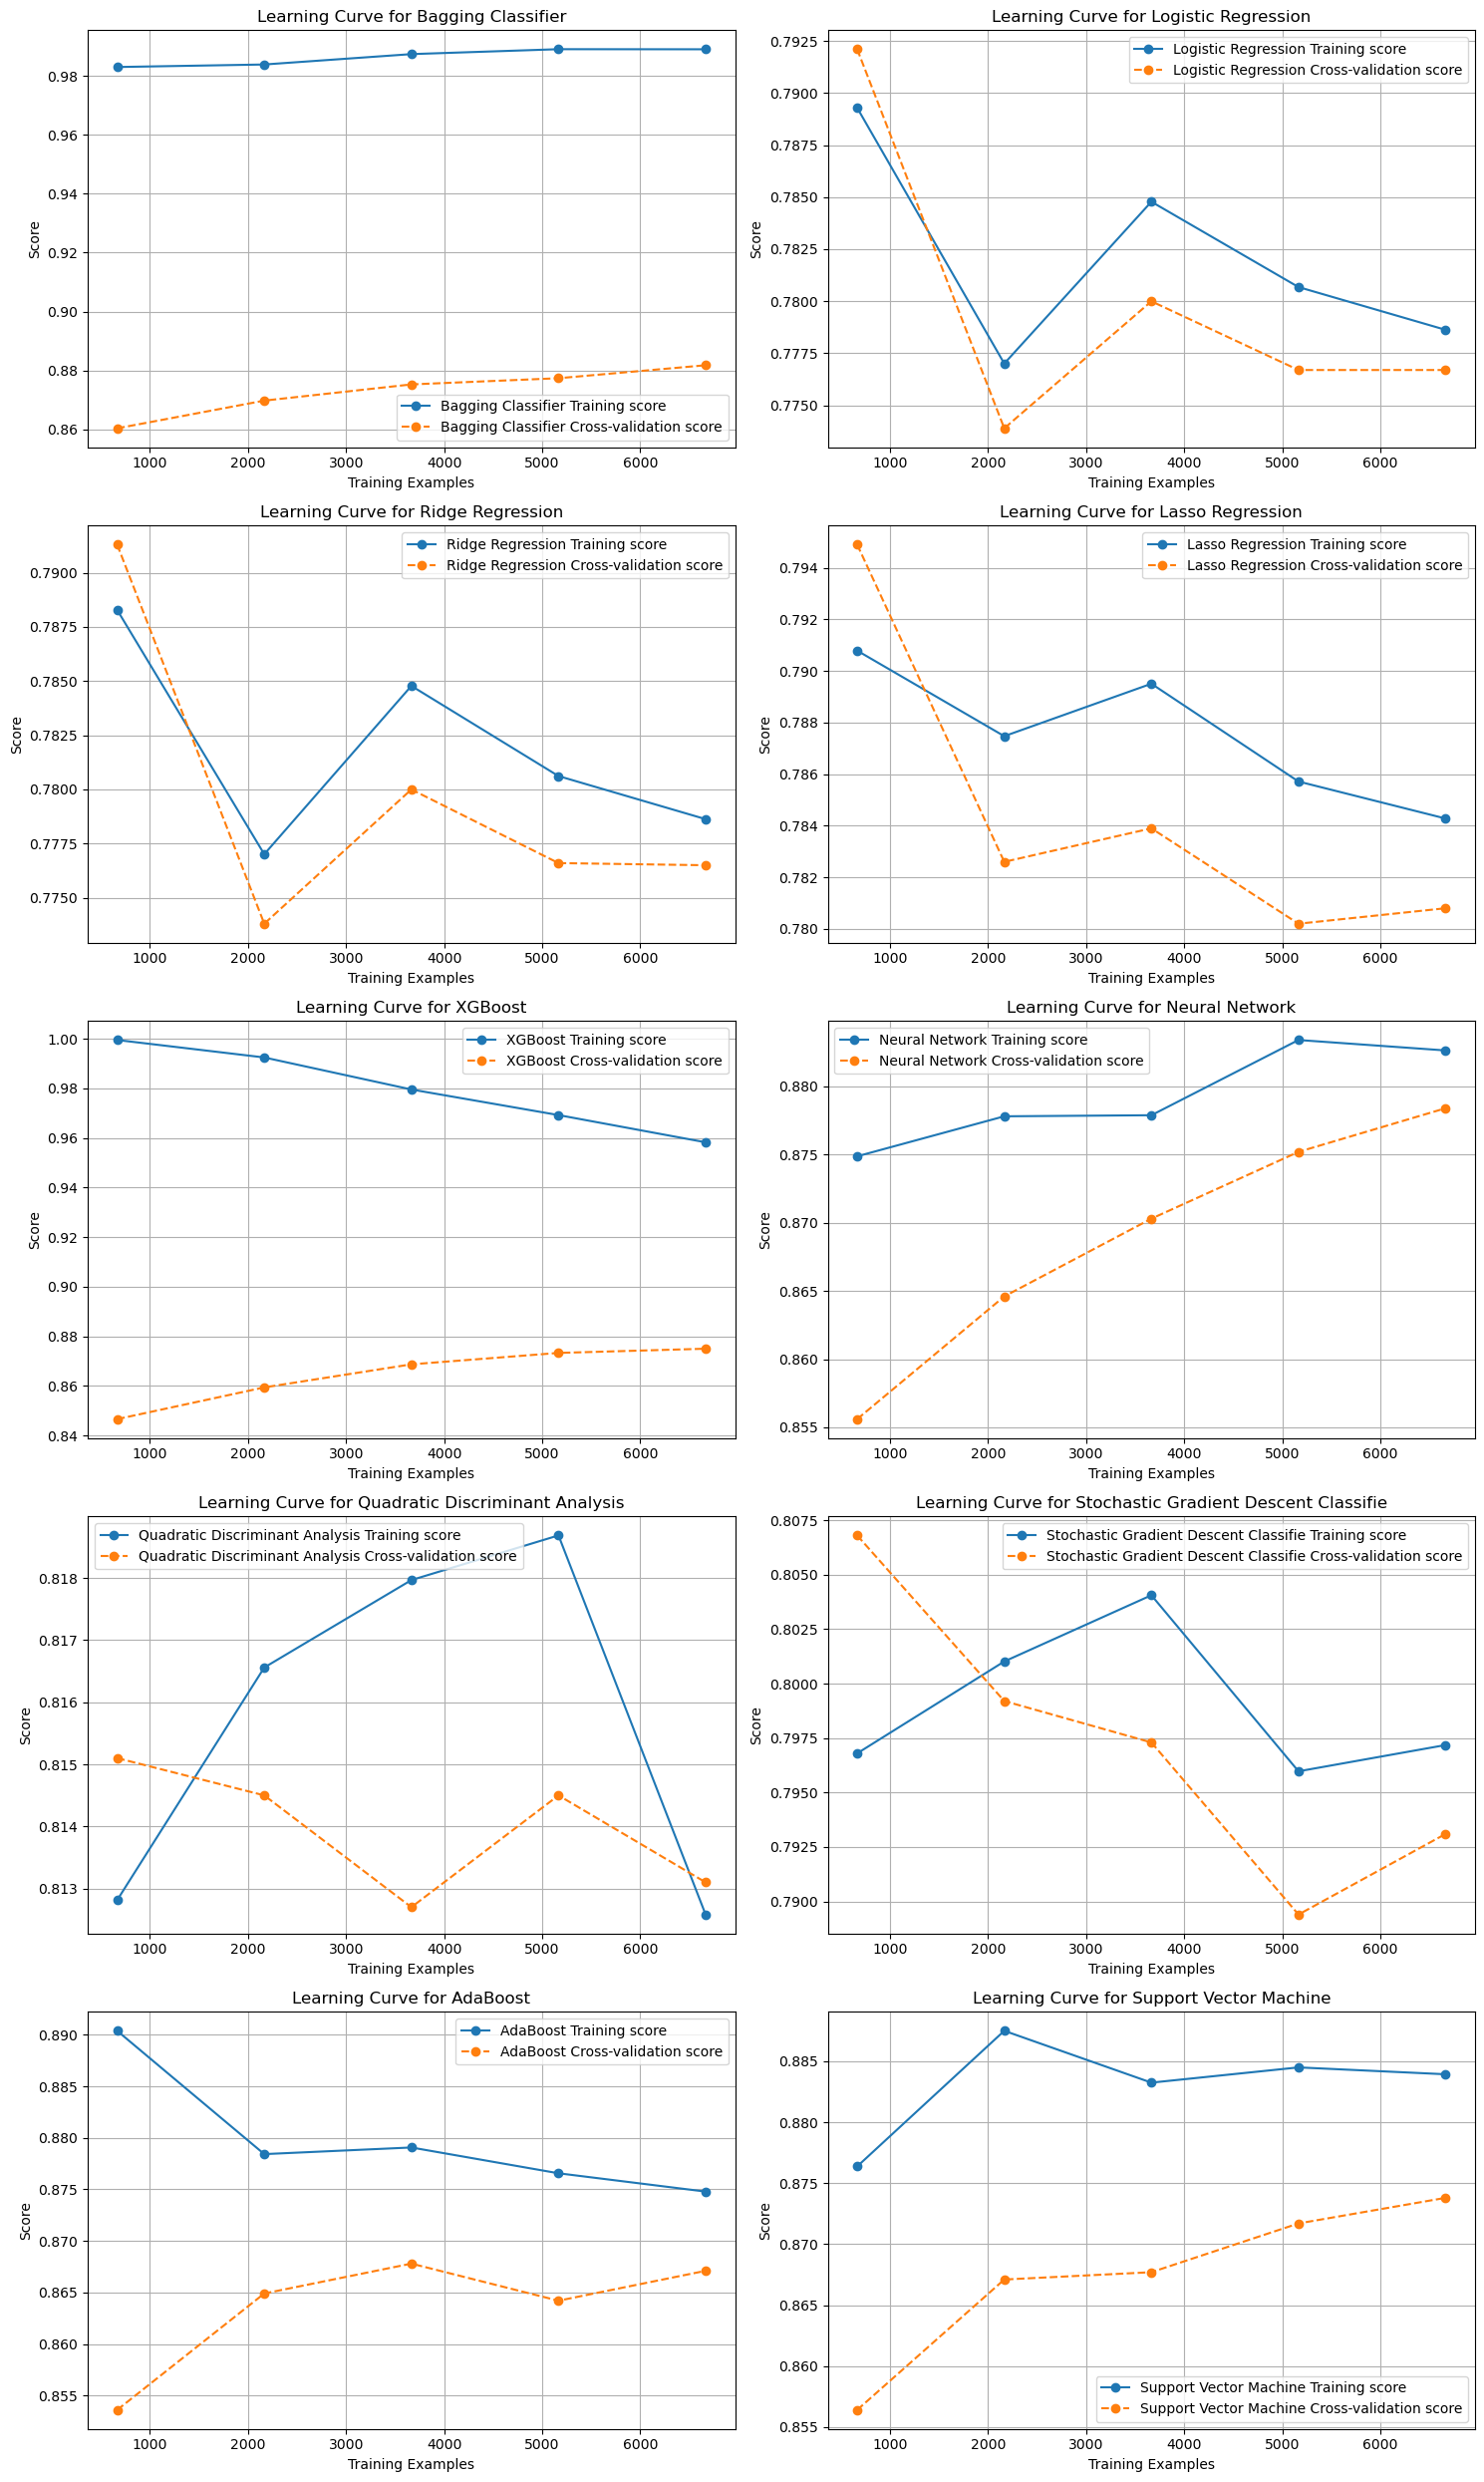

In [150]:
# cache learning curve results to avoid recomputation
memory = Memory("./cachedir", verbose=0)

# define function to generate the learning curve, caching the results
@memory.cache
def cached_learning_curve(model, x_train, y_train):
    train_sizes = np.linspace(0.1, 1.0, 5)  # reduce number of training sizes
    return learning_curve(model, x_train, y_train, cv=3, n_jobs=-1, train_sizes=train_sizes)  # reduced folds and parallelization

# define the number of models
n_models = len(models)
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols  # Calculate the number of rows needed

# create subplots for Learning curves
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# generate learning curves for each model 
for i, (name, model) in enumerate(models.items()):
    if model is not None:
        # Use a subset of the data (if needed)
        subset_size = min(10000, len(x_train_scaled_pca))  # use a subset of data to speed up process
        x_train_subset = x_train_scaled_pca[:subset_size]
        y_train_subset = y_train[:subset_size]

        # generate learning curve using the cached function
        train_sizes, train_scores, test_scores = cached_learning_curve(model, x_train_subset, y_train_subset)

        ax = axes[i]
        ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label=f'{name} Training score')
        ax.plot(train_sizes, test_scores.mean(axis=1), 'o--', label=f'{name} Cross-validation score')
        ax.set_xlabel('Training Examples')
        ax.set_ylabel('Score')
        ax.set_title(f'Learning Curve for {name}')
        ax.legend(loc='best')
        ax.grid()


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Predictions 

This section presents the predictions made by each model on the test set. 

The following output displays the first five predictions from each trained model:

In [152]:
# Model predictions 
for name, model in models.items():
    if model is not None:
        y_pred = model.predict(x_test_scaled_pca)
        print(f"{name} predictions: {y_pred[:5]}")

Bagging Classifier predictions: [0 1 1 0 1]
Logistic Regression predictions: [0 1 1 0 0]
Ridge Regression predictions: [0 1 1 0 0]
Lasso Regression predictions: [0 1 1 0 0]
XGBoost predictions: [0 1 1 0 1]
Neural Network predictions: [0 1 0 0 1]
Quadratic Discriminant Analysis predictions: [0 1 1 0 0]
Stochastic Gradient Descent Classifie predictions: [0 1 1 0 0]
AdaBoost predictions: [0 1 1 0 1]


/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Support Vector Machine predictions: [0 1 1 0 1]


The variation in predictions across models highlights differences in how each model interprets the data. While some models show similar predictions (such as XGBoost and Bagging Classifier), others provide different results (Neural Network and Logistic Regression), reflecting their unique learning approaches and decision-making processes.

### Mean Square Error

Each modle performance is evaluated by calculating the Mean Squared Error (MSE) on the test dataset. MSE provides an indication of the average squared difference between predicted and actual values, with lower values indicating better model performance.

In [169]:
#Mean Squared Errors (MSE)
mse_values = {}
for name, model in models.items():
    if model is not None:
        y_pred = model.predict(x_test_scaled_pca)
        mse = mean_squared_error(y_test, y_pred)
        mse_values[name] = mse
        print(f"{name} MSE: {mse}")

Bagging Classifier MSE: 0.09747596614194338
Logistic Regression MSE: 0.17477370510807258
Ridge Regression MSE: 0.1748375400564301
Lasso Regression MSE: 0.17475455462356532
XGBoost MSE: 0.13168511496674198
Neural Network MSE: 0.1102493393082845
Quadratic Discriminant Analysis MSE: 0.19783727194964698
Stochastic Gradient Descent Classifie MSE: 0.16986479757937875
AdaBoost MSE: 0.1598618611717543


/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Support Vector Machine MSE: 0.15146756546273954


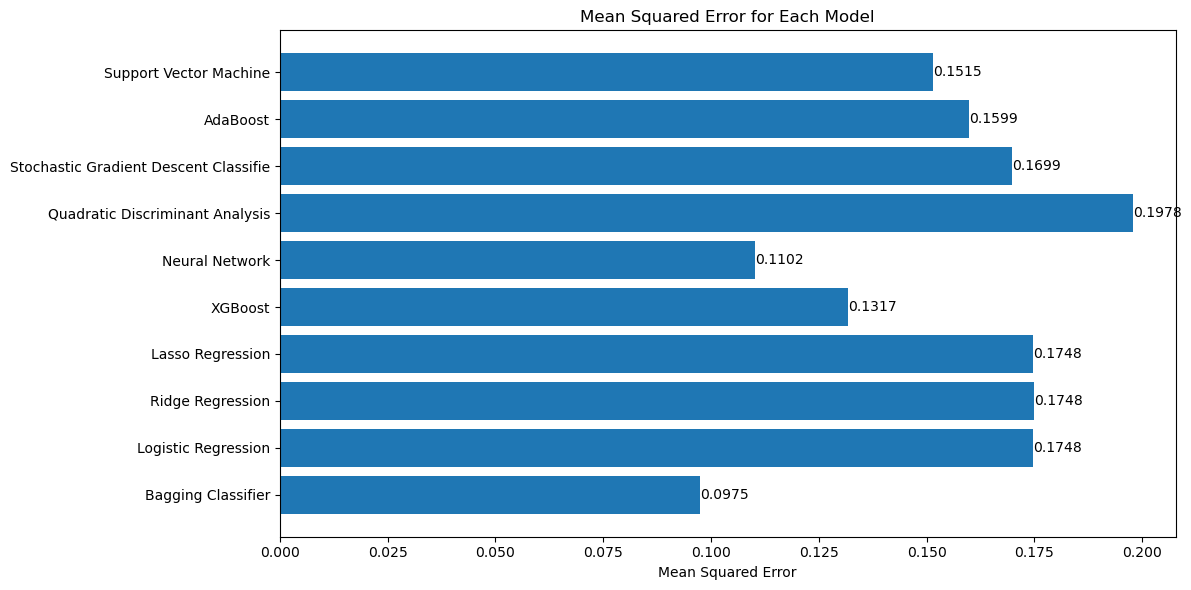

In [171]:
# plot MSE
fig, ax = plt.subplots(figsize=(12, 6))
model_names = list(mse_values.keys())
mse_scores = list(mse_values.values())

# create barplot w/MSE values 
ax.barh(model_names, mse_scores)
ax.set_xlabel('Mean Squared Error')
ax.set_title('Mean Squared Error for Each Model')

for index, value in enumerate(mse_scores):
    ax.text(value, index, f'{value:.4f}', va='center')

plt.tight_layout()
plt.show()

The bar plot visually represents the Mean Squared Error for each model, providing an intuitive comparison of their performance. The Bagging Classifier stands out with the lowest bar, signifying its superior performance, while Quadratic Discriminant Analysis has the highest bar, indicating the poorest performance.

- Bagging Classifier has the lowest MSE of 0.0975, indicating the highest accuracy among the models tested, as it has the smallest average squared difference between predicted and actual values.
- Logistic Regression, Ridge Regression, and Lasso Regression show higher MSE values, ranging from 0.1748 to 0.1748. These models exhibit a greater average error in their predictions compared to the Bagging Classifier.
- XGBoost and Neural Network have relatively lower MSEs, with values of 0.1317 and 0.1102 respectively, suggesting better performance than many other models but still not as optimal as Bagging Classifier.
- Quadratic Discriminant Analysis has the highest MSE of 0.1978, reflecting the largest average squared prediction error among the tested models.
- Stochastic Gradient Descent Classifier and AdaBoost also show moderate MSE values of 0.1699 and 0.1599, respectively.

### Feature Importance and PCA Components Analysis

In this section, the contribution of different features to the model predictions and principal components derived from PCA to are analyzed to understand feature influence on the transformed space.

#### Feature Importance Extarction

In [158]:
# feature importance extraction 
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        print(f"{name} Feature Importances:")
        print(model.feature_importances_)
    elif hasattr(model, 'coef_'):
        print(f"{name} Coefficients:")
        print(model.coef_)

Logistic Regression Coefficients:
[[0.10210477 0.22166906 0.36241999]]
Ridge Regression Coefficients:
[[0.10083023 0.22091734 0.36069561]]
Lasso Regression Coefficients:
[[0.1001409  0.21937859 0.35814301]]
XGBoost Feature Importances:
[0.52024233 0.37707186 0.10268585]
Stochastic Gradient Descent Classifie Coefficients:
[[0.19734927 0.36620473 0.35953825]]
AdaBoost Feature Importances:
[0.79817673 0.16421658 0.03760668]


- Logistic Regression, Ridge Regression, and Lasso Regression display coefficient values for each feature, indicating their contribution to the model. Higher coefficients suggest greater importance.
- XGBoost and AdaBoost provide feature importance values, reflecting how each feature influences the model's predictions. AdaBoost highlights a significant emphasis on the first feature.
- Stochastic Gradient Descent Classifier has coefficient values that provide insights into feature importance similarly to the regression models.

#### Visualization of Feature Importance

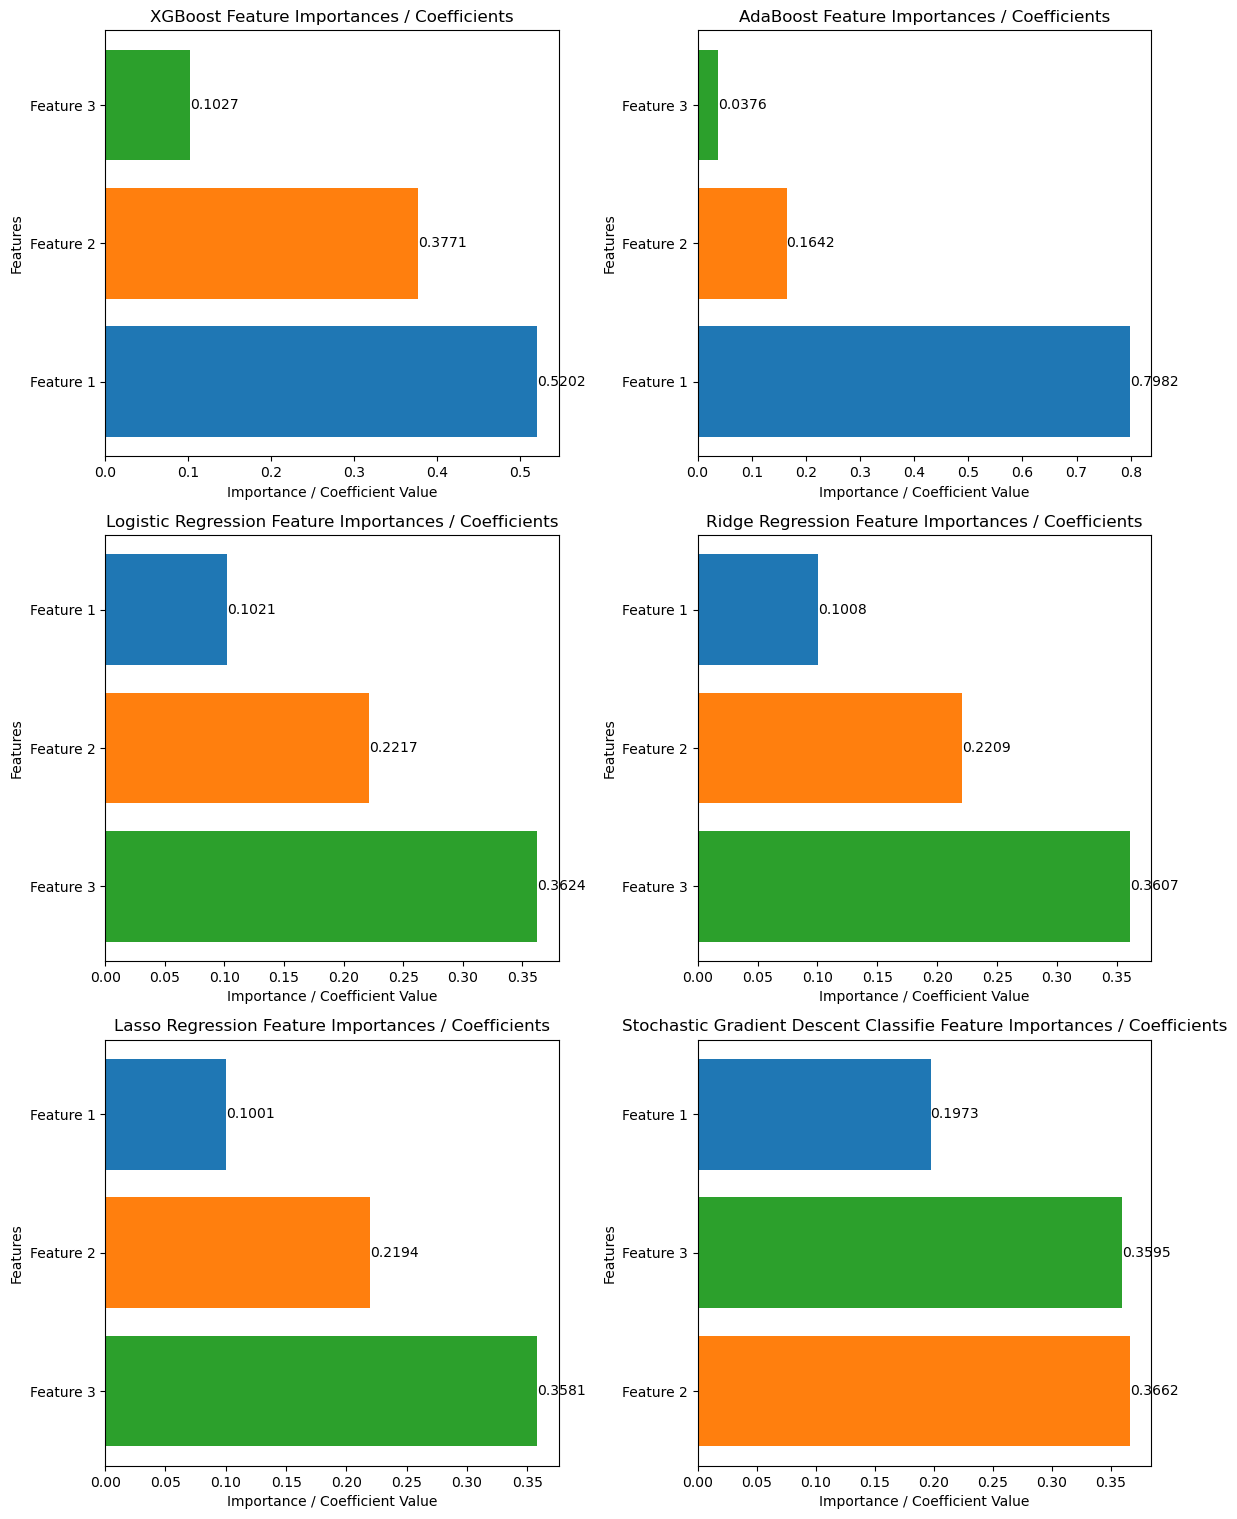

In [189]:
importances = {}
coefficients = {}

# extract feature importances/coefficients from models
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        coefficients[name] = model.coef_[0]  

# combine importances and coefficients
all_feature_info = {**importances, **coefficients}

# define specific color for each feature
feature_colors = {
    'Feature 1': '#1f77b4',
    'Feature 2': '#ff7f0e',
    'Feature 3': '#2ca02c',
}

# create subplots
n_models = len(all_feature_info)
fig, axes = plt.subplots(n_models, 2, figsize=(12, n_models * 5), squeeze=False)
axes = axes.flatten()

for i, (name, info) in enumerate(all_feature_info.items()):
    ax = axes[i]
    
    # generate feature names
    feature_names = [f'Feature {j+1}' for j in range(len(info))]
    
    # create a DataFrame for plotting
    df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': info
    }).sort_values(by='Importance', ascending=False)
    
    # use predefined colors for features
    colors = [feature_colors.get(feature, 'grey') for feature in df['Feature']]
    
    # create a horizontal bar plot
    bars = ax.barh(df['Feature'], df['Importance'], color=colors)
    ax.set_title(f'{name} Feature Importances / Coefficients')
    ax.set_xlabel('Importance / Coefficient Value')
    ax.set_ylabel('Features')
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', color='black')

for j in range(n_models, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The bar plots illustrate the importance of each feature for the models. The height of the bars reflects the magnitude of feature importance or coefficient values, allowing for a visual comparison across models. It appears feature 3 is pivotal in a handful of the models. 

### PCA Components Explained

#### PCA Transformation and Loadings

Feature influenced through principal componet is examined:


In [173]:
pca_scaled = PCA(n_components=3)
new_X_train_scaled_pca = pca_scaled.fit_transform(x_train_scaled)
components = pca_scaled.components_
evr = pca_scaled.explained_variance_ratio_

loadings_scaled = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=[x_train_scaled.columns])
# Sort each column in ascending order
sorted_loadings_scaled = loadings_scaled.apply(lambda x: x.sort_values())

print("\nSorted Loadings Scaled:")
print(sorted_loadings_scaled)

# Print sorted values for each PC individually
for i in range(components.shape[0]):
    sorted_pc = loadings_scaled[f'PC{i+1}'].sort_values(ascending=True)
    print(f"\nSorted Loadings for PC{i+1}:")
    print(sorted_pc)


Sorted Loadings Scaled:
                                                         PC1       PC2  \
average_number_of_providers_per_county              0.013079  0.116687   
average_number_of_providers_per_county_dual_col... -0.000274 -0.000649   
average_number_of_providers_per_county_dual_col... -0.000338 -0.001018   
average_number_of_providers_per_county_dual_col... -0.000333 -0.000730   
average_number_of_providers_per_county_dual_col...  0.000150  0.000249   
...                                                      ...       ...   
type_of_service_0                                  -0.000219  0.001338   
type_of_service_1                                   0.000517 -0.001192   
type_of_service_2                                  -0.000353 -0.000693   
type_of_service_3                                   0.000113  0.000070   
type_of_service_4                                   0.000155  0.000486   

                                                         PC3  
average_number_of_provi

- PC1 highlights features like `total_payment` as highly influential, with a large positive loading.
- PC2 shows number_of_users and `number_of_providers` having notable positive loadings.
- PC3 features such as `number_of_providers` and `number_of_users` show significant influence, with both positive and negative contributions.

#### Visualization of PCA Loadings

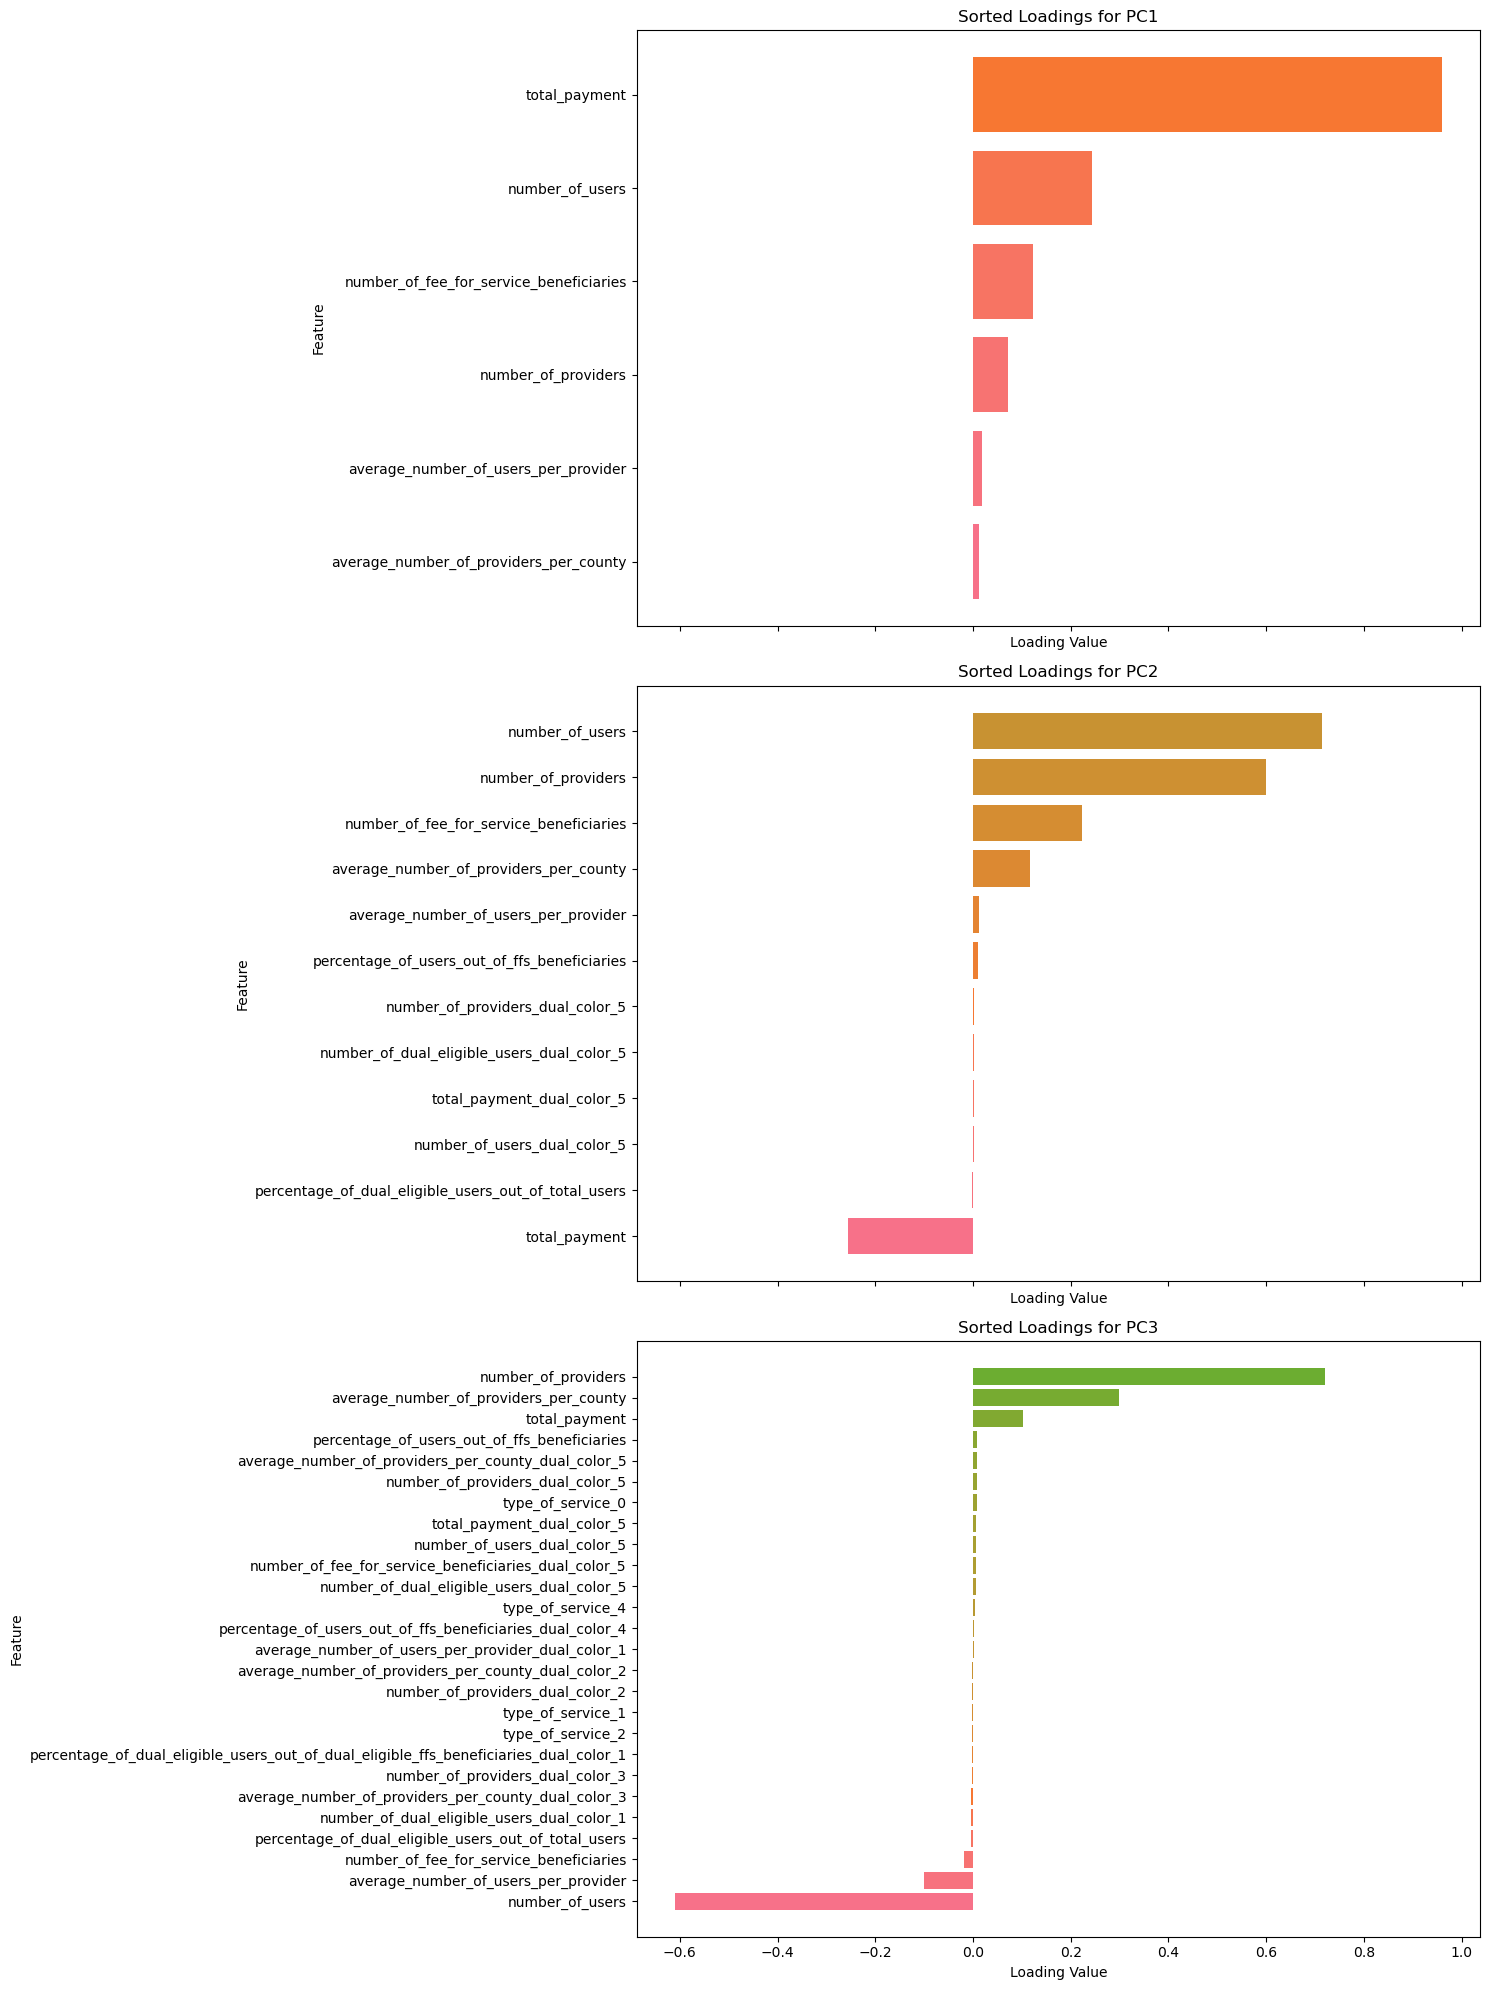

In [199]:
# PCA transformation
pca_scaled = PCA(n_components=3)
new_X_train_scaled_pca = pca_scaled.fit_transform(x_train_scaled)
components = pca_scaled.components_

# create df for the PCA loadings
loadings_scaled = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=x_train_scaled.columns)

# define a threshold for significant loadings
threshold = 0.0025  

# filter features based on the threshold
filtered_loadings_scaled = loadings_scaled.apply(lambda x: x[abs(x) > threshold])

# define colors for each feature
colors = sns.color_palette("husl", len(x_train_scaled.columns))

#plot PCA components with color-coded features
fig, axes = plt.subplots(nrows=components.shape[0], ncols=1, figsize=(15, 20), sharex=True)

for i in range(components.shape[0]):
    ax = axes[i]
    sorted_pc = filtered_loadings_scaled[f'PC{i+1}'].dropna().sort_values(ascending=True)
    
    if not sorted_pc.empty:
        feature_colors = colors[:len(sorted_pc)]
        ax.barh(sorted_pc.index, sorted_pc, color=feature_colors)
        ax.set_title(f'Sorted Loadings for PC{i+1}')
        ax.set_xlabel('Loading Value')
        ax.set_ylabel('Feature')
    else:
        ax.set_visible(False)  

plt.tight_layout()
plt.show()

#### Top Features

From the PCA loadings and visualizations, the top six features that stood out as highly influential across the principal components are:

1. Total Payment
2. Number of Users
3. Number of Providers
4. Average Number of Providers per County
5. Number of Fee-for-Service Beneficiaries
6. Average Number of Users per Provider

These features were not only the most significant in explaining the variance in the dataset but also clustered together, indicating potential correlations or redundancies.

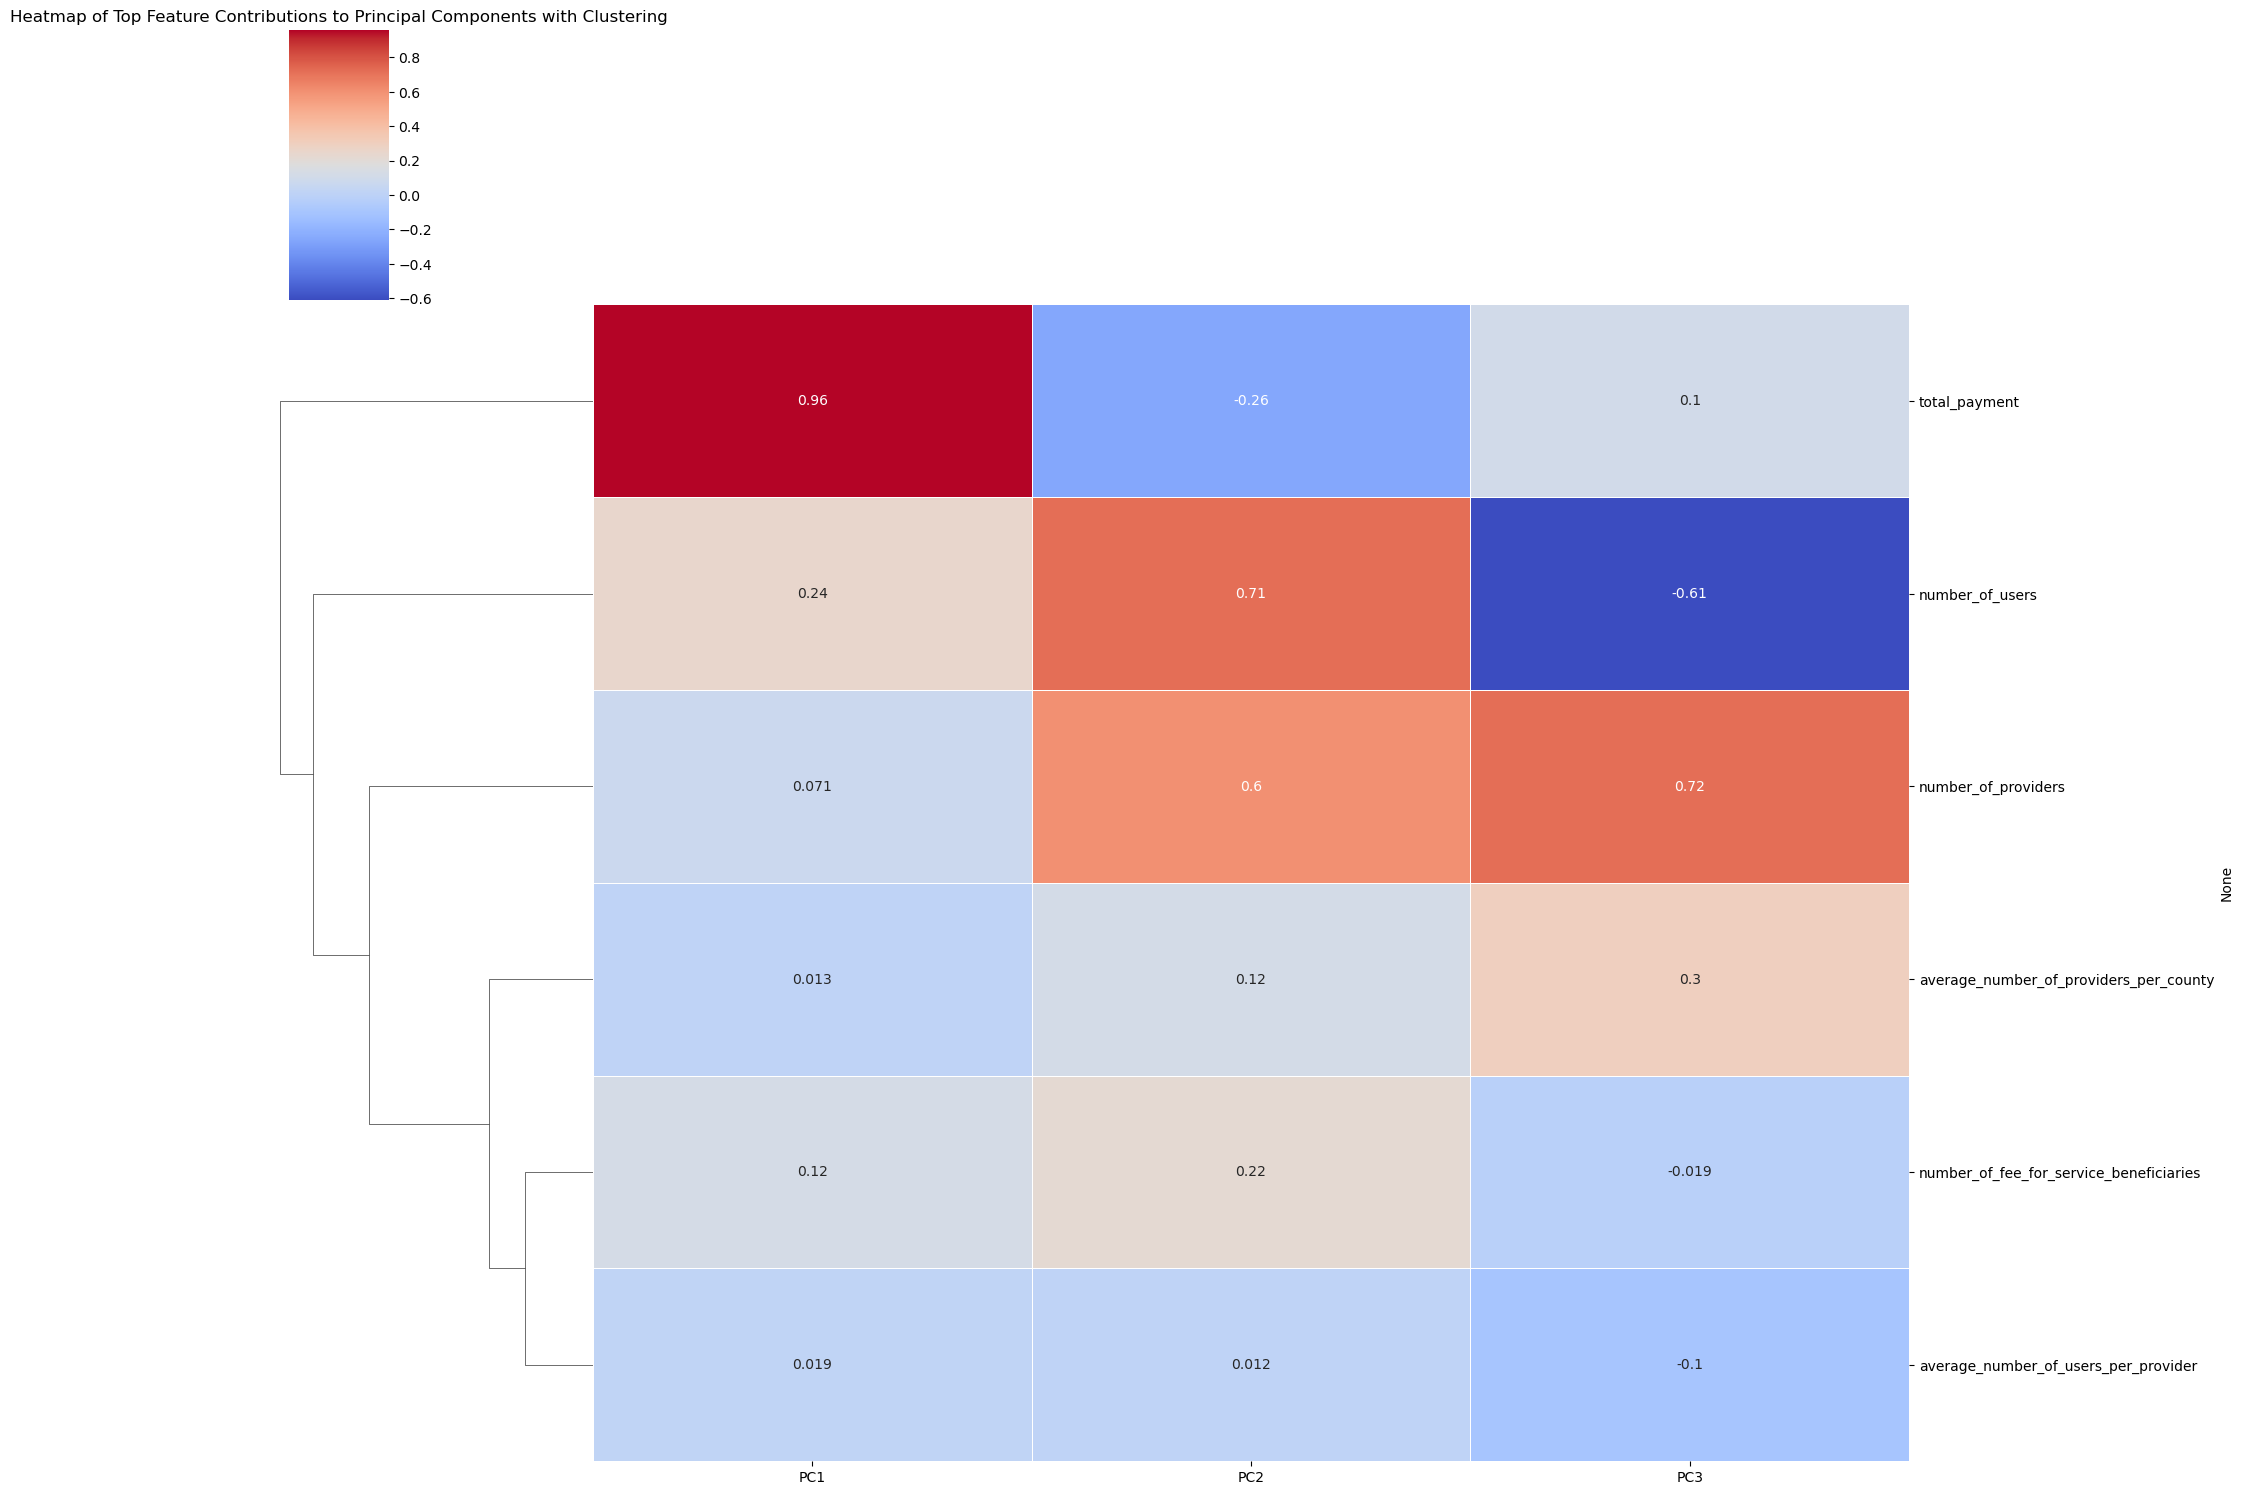

In [110]:
# Sort and select top 6 features for each component, can change if needed
top_features_per_pc = {}
num_top_features = 6

for pc in loadings_scaled.columns:
    top_features = loadings_scaled[pc].abs().sort_values(ascending=False).head(num_top_features).index
    top_features_per_pc[pc] = top_features

# Get unique top features
unique_top_features = list(set([feature for features in top_features_per_pc.values() for feature in features]))

# Filter DataFrame to include only top features
loadings_scaled_top = loadings_scaled.loc[unique_top_features]

# Perform hierarchical clustering on top features
Z = linkage(loadings_scaled_top, 'ward')

# Plot clustered heatmap
sns.clustermap(loadings_scaled_top, annot=True, cmap='coolwarm', linewidths=0.5, figsize=(20, 15), row_cluster=True, col_cluster=False)
plt.title('Heatmap of Top Feature Contributions to Principal Components with Clustering')
plt.show()

## Bagging Classifier Prediction

The Bagging Classifier was selected for its ability to reduce variance and increase the robustness of predictions, making it particularly effective in the context of fraud detection, where accuracy and reliability are crucial. The model was applied to the PCA-transformed test data to leverage reduced dimensionality, aiming to enhance overall performance.

Predictions were made on the test set, focusing on the probability of class 1 (fraud, waste, and abuse or FWA), which is critical for assessing the model's confidence in detecting fraud. A DataFrame was created to review these predictions, incorporating the actual labels, predicted labels, and the associated probabilities. This allowed for a detailed analysis of how well the model's predictions align with the actual outcomes.

In [21]:
# pull bagging classifier from model directory 
bagging_model = models['Bagging Classifier']

# make predictions on test set
y_pred = bagging_model.predict(x_test_scaled_pca)

# Make predictions and get probabilities on the test set
y_pred = bagging_model.predict(x_test_scaled_pca)
y_pred_proba = bagging_model.predict_proba(x_test_scaled_pca)[:, 1]  # Probabilities for class 1 (FWA)

# create df to review the predictions
review_df = x_test_scaled_pca.copy()  # copy test features
review_df['Actual'] = y_test  # add actual labels
review_df['Predicted'] = y_pred  # add predicted labels
review_df['Probability'] = y_pred_proba

# Add probabilities to FWA DataFrame
fwa_df = review_df[review_df['Predicted'] == 1].copy()
fwa_df['Probability'] = review_df.loc[fwa_df.index, 'Probability']
fwa_df['Correct'] = fwa_df['Actual'] == fwa_df['Predicted']

In [22]:
# display df 
fwa_df.head()

,PC1,PC2,PC3,Actual,Predicted,Probability,Correct
1,1.113196,17.200987,8.076355,1,1,1.000000,True
2,23.467390,29.197332,-10.529019,1,1,1.000000,True
4,-1.274043,-3.057991,-0.305736,1,1,1.000000,True
10,-3.406911,3.050015,3.007568,0,1,0.898333,False
11,1.217441,6.392469,0.021293,1,1,1.000000,True


To zero in on FWA predictions, the DataFrame was filtered to include only cases predicted as fraudulent. This refined DataFrame provided additional insights by including a Correct column that indicated whether the model's predictions matched the actual labels. This setup alloed for a focused examination of the model's performance in detecting fraud.

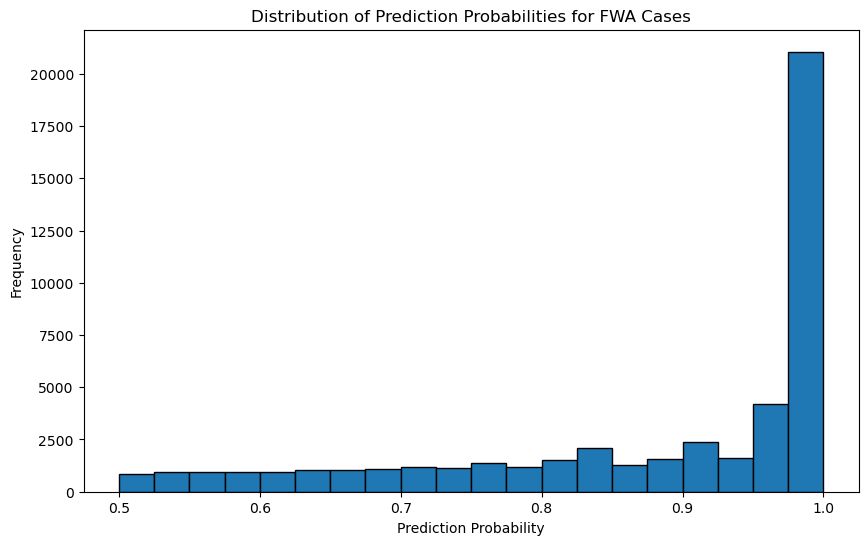

In [23]:
# plot probability distribution for FWA predictions
plt.figure(figsize=(10, 6))
plt.hist(fwa_df['Probability'], bins=20, edgecolor='black')
plt.title('Distribution of Prediction Probabilities for FWA Cases')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.show()

The histogram visualizes how confident the model is in predicting FWA cases. The concentration of high probabilities indicates that the model is confident in its fraud predictions. Analyzing the spread of these probabilities helps in understanding the model's behavior and reliability.

In [24]:
# save df to CSV for Tableau visualizations
csv_path = 'data/bagging_predictions_fwa.csv'
fwa_df.to_csv(csv_path, index=False)


print(f"DataFrame successfully saved to {csv_path}")

DataFrame successfully saved to data/bagging_predictions_fwa.csv


## References
## References

AdaBoostClassifier. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

American Medical Association. (2021). *Medicare fraud & abuse: Prevent, detect, report*. In MLN booklet. https://www.cms.gov/Outreach-and-Education/Medicare-Learning-Network-MLN/MLNProducts/Downloads/Fraud-Abuse-MLN4649244.pdf

Amponsah, A. A., Adekoya, A. F., & Weyori, B. A. (2022). A novel fraud detection and prevention method for healthcare claim processing using machine learning and blockchain technology. *Decision Analytics Journal, 1*(2), 100122. https://doi.org/10.1016/j.dajour.2022.100122

BaggingClassifier. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Bauder, R., Da Rosa, R., & Khoshgoftaar, T. (2018). Identifying Medicare provider fraud with unsupervised machine learning. *IEEE International Conference on Information Reuse and Integration (IRI)*, 285–292. https://doi.org/10.1109/iri.2018.0005

Bruce, P., & Bruce, A. (2017). *Practical statistics for data scientists: 50 essential concepts*. https://www.amazon.com/Practical-Statistics-Data-Scientists-Essential/dp/1491952962

Centers for Medicare & Medicaid Services data. (2024). https://data.cms.gov/summary-statistics-on-use-and-payments/program-integrity-market-saturation-by-type-of-service/market-saturation-utilization-state-county

Centers for Medicare and Medicaid Services. (2021). *Medicare fraud & abuse: Prevent, detect, report*. https://www.cms.gov/Outreach-and-Education/Medicare-Learning-Network-MLN/MLNProducts/Downloads/Fraud-Abuse-MLN4649244.pdf

Chen, Z. X., Hohmann, L., Banjara, B., Zhao, Y., Diggs, K., & Westrick, S. C. (2020). Recommendations to protect patients and health care practices from Medicare and Medicaid fraud. *Journal of the American Pharmacists Association, 60*(6), e60–e65. https://doi.org/10.1016/j.japh.2020.05.011

Federal Bureau of Investigation. (n.d.). *Health care fraud*. https://www.fbi.gov/investigate/white-collar-crime/health-care-fraud

GridSearchCV. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Johnson, J. M., & Khoshgoftaar, T. M. (2023). Data-centric AI for healthcare fraud detection. *SN Computer Science/SN Computer Science, 4*(4). https://doi.org/10.1007/s42979-023-01809-x

Johnson, J. M., & Khoshgoftaar, T. M. (2019). Medicare fraud detection using neural networks. *Journal of Big Data, 6*(63). https://doi.org/10.1186/s40537-019-0225-0

KMeans. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Kose, I., Gokturk, M., & Kilic, K. (2015). An interactive machine-learning-based electronic fraud and abuse detection system in healthcare insurance. *Applied Soft Computing, 36*, 283–299. https://doi.org/10.1016/j.asoc.2015.07.018

Kuhn, M., & Johnson, K. (2013). *Applied predictive modeling*. Springer eBooks. https://doi.org/10.1007/978-1-4614-6849-3

Lasso. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Linear and Quadratic Discriminant Analysis with covariance ellipsoid. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html

LogisticRegression. (2014). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Matthews_corrcoef. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

MEDICARE-MEDICAID COORDINATION OFFICE & Centers for Medicare & Medicaid Services. (2023). *People dually eligible for Medicare and Medicaid*. In Fact Sheet – March 2023. https://www.cms.gov/Medicare-Medicaid-Coordination/Medicare-and-Medicaid-Coordination/Medicare-Medicaid-Coordination-Office/Downloads/MMCO_Factsheet.pdf

Support vector machines. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/svm.html

Neural network models (supervised). (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/neural_networks_supervised.html

QuadraticDiscriminantAnalysis. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html

RandomizedSearchCV. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Ridge. (2014). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

SGDClassifier. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

Cross-validation: Evaluating estimator performance. (n.d.). *Scikit-learn*. https://scikit-learn.org/stable/modules/cross_validation.html

XGBoost Documentation — xgboost 2.1.0. (2022). *Xgboost.readthedocs.io*. https://xgboost.readthedocs.io/en/stable/
